In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import json
import numpy as np
from tqdm import tqdm
import time
import seaborn as sns
from collections import Counter

# This is only because of anonymisation of the data: lots of warnings by numpy/pandas pointing to my username.
import warnings
warnings.filterwarnings("ignore")

# Data Collection

Partial code (but I do include prompts)

In [ ]:
def get_gpt4_response(model, assembled_prompt, debug=False):
    # This is a way to avoid throttling and too much repeated code
    resp = None
    while True:
        try:
            resp = model.send_request(assembled_prompt)
            if debug: print(f"Got: {resp}")
            if "error" in resp and "Sorry! We've encountered an issue with repetitive patterns in your prompt." in resp["error"]["message"]:
                return "PATTERNFAIL"
        except:
            time.sleep(1)
            continue
        if resp is not None and "choices" in resp:
            if debug: print(f"Suceeded and got: {resp}")
            break
        if "error" in resp and "This model's maximum context" in resp["error"]["message"]:
            return "TOKENFAIL"
    return resp["choices"][0]["text"]


def get_prompt5(text):
    paper_exemplar = "\\begin{figure}[t]\\n  \\includegraphics[width=\\columnwidth]{images/results/kappa_prompt_polar.png}\\n  \\caption{Breakdown of weighted Cohen's $\\kappa$ correlations per harm category in RTP-LX prompts. In general, S/LLMs were adept at detecting violent and sexual content, as well as insults. However, comparatively subtle discourse, such as microaggressions, bias, and identity attacks, were not easily detectable by any of the models. Definitions and scales can be found in \\tabref{categories}.}\\n  \\label{fig:cohen-kappa-prompt-polar}\\n\\end{figure}\\n\\nLarge language models (LLMs) are being adopted swiftly in research and production applications. \\nHowever, their tendency to memorise content \\citep{carlini2022quantifying,PlagiariseLee,dewynter2023evaluation} and the fact that they are trained from publicly available internet data means that they are very prone to spew harmful content \\citep{sheng-etal-2019-woman,wang2023decodingtrust,rauh2022characteristics,gehman-etal-2020-realtoxicityprompts}. \\nWith the advent of more capable, multilingual LLMs such as GPT-4 \\citep{GPT4} or BLOOMZ \\citep{wang-etal-2020-multi}, toxic language detection must scale fast and effectively to the dozens, if not hundreds, of languages these models support.\\n\\nLLMs and their more-portable, typically-open-source counterparts, \\emph{small} language models (SLMs) have been used as to score some tasks with good results \\cite{rethinkingsemantic,NEURIPS2023_91f18a12}. \\nHowever, it still remains unclear if S/LLMs can successfully perform annotation in a culturally-sensitive, multilingual scenario when harmful content is involved. \\nTo address this, we introduce RTP-LX (``RTP-Language eXpanded''), a corpus of about $1,100$ toxic prompts and outputs in 28 languages derived from the RTP dataset (``Real Toxicity Prompts''; \\cite{gehman-etal-2020-realtoxicityprompts}). RTP-LX has been professionally translated and labelled, and has followed participatory design practices by consulting with native speakers.\\nWe evaluate ten S/LLMs on RTP-LX' prompt subset and find that these models typically score acceptably in terms of \\emph{accuracy}, with GPT-4 Turbo and Gemma 7B having the highest percentages of correctly-classified examples. \\nWe also test a \\emph{benign} subset of completions (that is, completions that are not considered toxic) to determine the S/LLMs' tendency to overblock innocuous content, and find that the models generally have a non-trivial amount of false positives, ranging anywhere from around 0\\% (Llama Guard) to 40\\% (Gemma 2B). \\nA deeper analysis also shows that S/LLMs have low agreement with human judges when scoring holistically the toxicity of a prompt. \\nThese models also have difficulty discerning harm in context-dependent scenarios, particularly with subtle-yet-harmful content such as microagressions and bias, as seen in \\figref{cohen-kappa-prompt-polar}. \\n\\nOur contributions are as follows: \\n\\begin{itemize}\\n    \\item We release RTP-LX, a multilingual corpus in 28 languages consisting of toxic prompts with both toxic and benign completions to facilitate safer deployment of S/LLMs, including culturally-nuanced content, and wholly human-annotated.\\n    \\item  We perform a thorough analysis of the feasibility of deploying base S/LLMs for toxicity detection and show that their failure to detect certain categories could lead to erasure.\\n    \\item We show that the trend of the models to perform toxicity detection is related to the language's online availability--i.e., whether they are low, mid, or high-resource languages.\\n\\end{itemize}\\n\\n\\section{RTP-LX}\\n\\label{sec:Dataset}\\nThe seed corpus for RTP-LX is a subset of $1,000$ prompts from the original RTP corpus. \\nRTP is a set of nearly $100,000$ toxic sentences mined from Reddit. Each entry in the corpus is split into prompts and completions, and then annotated via the Perspective API.\\footnote{\\url{https://github.com/conversationai/perspectiveapi}} The prompts for the seed corpus were collected with an even proportion of explicitly toxic prompts and prompts that could lead to a toxic completion (i.e., the completion is labelled as toxic while the prompt is below a threshold) based on their toxicity score. We chose the top $1,000$ prompts fulfilling this criterion. The seed corpus corresponds to the English subset of RTP-LX. The full set of languages supported by RTP-LX is in Appendix \\ref{app:languages-supported}. \\n\\n\\n\\subsection{Participatory Design}\\nIn addition to the prompts from RTP, we also curated 50-100 toxic prompts that fulfilled the following requirements:\\n\\begin{enumerate}\\n    \\item They must not be explicitly toxic (e.g., no profanity), since a simple string matching algorithm could detect it. \\n    \\item They must be hard to translate into English. \\n    This requirement was instroduced due the scarcity of human-designed datasets; and, dually, due to the abundance of machine-translated corpora.%We hypothesize that content moderators that support multilinguality limit themselves to translate to English. \\n    \\item They must relate explicitly to their culture. \\n    Although self-explanatory, this requirement was phrased as ``[the prompt] could lead to output offensive to a native speaker''. \\n\\end{enumerate}\\nThe harm categories are: Bias, Identity Attack, Insult, Microaggression, Self-Harm, Sexual Content, Toxicity and Violence. The definition of each of the harm category is provided in \\appref{guidelines}. Toxicity is scored on a five-point Likert scale, and the rest of the harms on a three-point Likert scale. We used ternary scales as it would leave less room of ambiguity for the LLMs and thereby address the problem of overly optimistic LLM scoring, which is a known issue in multilingual scenarios \\citep{LLMLXEval}. \\n\\nThe annotators were given an annotation rubric (\\appref{guidelines}) and had an opportunity to run a test and ask questions prior to beginning the full annotation process. \\nEach harm was annotated independently, and used Toxicity as an overall score of the prompt's (or completion's) toxicity. \\nTo avoid any potential conflicts with internal value systems, we also attached a copy of a uniform value system to be used when in doubt. \\nThis value system is also designed to mitigate some other limitations of working with toxic language in a global context--risks which we discuss further in \\secref{limitations}. \\nThat said, we encouraged the annotators to use their best judgement and only defer to the value system when in doubt. \\n\\n\\subsection{Inter-Rater Reliability (IRR)}\\n\\label{subsec:IAA}\\nWe measured IRR with weighted Cohen's $\\kappa$, or $\\kappa_w$, and observed a substantial positive agreement in the corpus ($0.62 \\pm 0.2$ overall)\\footnote{Generally, $\\kappa_w > 0.60$ is considered a substantial positive agreement}. The agreements breakdown can be found in \\figref{human-acs-gpt4turbo-llamaguard-iaa}. \\nWe chose $\\kappa_w$ because it takes into account the value of the ordinal, so broad differences in scoring (e.g., $1$-$3$ versus $1$-$2$) are encoded in this measure. \\nTo account for multiple annotators, we took pairwise IRR and averaged it out. \\n"
    prompt = "I am going to link a scientific paper. Tell me what is the primary and secondary subject of the paper, in at most three words each.\nReturn the extract of the paper, verbatim, that correspond to why you picked that subject."
    prompt += "For example,\n"
    prompt += f"|begin paper|\n{paper_exemplar}\n|end paper|\n"
    prompt += "- primary: harm and toxicity | These models also have difficulty discerning harm in context-dependent scenarios.\n"
    prompt += "- secondary: multilingual | To address this, we introduce RTP-LX (``RTP-Language eXpanded''), a corpus of about $1,100$ toxic prompts and outputs in 28 languages derived from the RTP dataset\n"
    prompt += f"|begin paper|\n{text}|end paper|\n- primary: "
    return prompt


def get_prompt4(text):
    paper_exemplar = "\\begin{figure}[t]\\n  \\includegraphics[width=\\columnwidth]{images/results/kappa_prompt_polar.png}\\n  \\caption{Breakdown of weighted Cohen's $\\kappa$ correlations per harm category in RTP-LX prompts. In general, S/LLMs were adept at detecting violent and sexual content, as well as insults. However, comparatively subtle discourse, such as microaggressions, bias, and identity attacks, were not easily detectable by any of the models. Definitions and scales can be found in \\tabref{categories}.}\\n  \\label{fig:cohen-kappa-prompt-polar}\\n\\end{figure}\\n\\nLarge language models (LLMs) are being adopted swiftly in research and production applications. \\nHowever, their tendency to memorise content \\citep{carlini2022quantifying,PlagiariseLee,dewynter2023evaluation} and the fact that they are trained from publicly available internet data means that they are very prone to spew harmful content \\citep{sheng-etal-2019-woman,wang2023decodingtrust,rauh2022characteristics,gehman-etal-2020-realtoxicityprompts}. \\nWith the advent of more capable, multilingual LLMs such as GPT-4 \\citep{GPT4} or BLOOMZ \\citep{wang-etal-2020-multi}, toxic language detection must scale fast and effectively to the dozens, if not hundreds, of languages these models support.\\n\\nLLMs and their more-portable, typically-open-source counterparts, \\emph{small} language models (SLMs) have been used as to score some tasks with good results \\cite{rethinkingsemantic,NEURIPS2023_91f18a12}. \\nHowever, it still remains unclear if S/LLMs can successfully perform annotation in a culturally-sensitive, multilingual scenario when harmful content is involved. \\nTo address this, we introduce RTP-LX (``RTP-Language eXpanded''), a corpus of about $1,100$ toxic prompts and outputs in 28 languages derived from the RTP dataset (``Real Toxicity Prompts''; \\cite{gehman-etal-2020-realtoxicityprompts}). RTP-LX has been professionally translated and labelled, and has followed participatory design practices by consulting with native speakers.\\nWe evaluate ten S/LLMs on RTP-LX' prompt subset and find that these models typically score acceptably in terms of \\emph{accuracy}, with GPT-4 Turbo and Gemma 7B having the highest percentages of correctly-classified examples. \\nWe also test a \\emph{benign} subset of completions (that is, completions that are not considered toxic) to determine the S/LLMs' tendency to overblock innocuous content, and find that the models generally have a non-trivial amount of false positives, ranging anywhere from around 0\\% (Llama Guard) to 40\\% (Gemma 2B). \\nA deeper analysis also shows that S/LLMs have low agreement with human judges when scoring holistically the toxicity of a prompt. \\nThese models also have difficulty discerning harm in context-dependent scenarios, particularly with subtle-yet-harmful content such as microagressions and bias, as seen in \\figref{cohen-kappa-prompt-polar}. \\n\\nOur contributions are as follows: \\n\\begin{itemize}\\n    \\item We release RTP-LX, a multilingual corpus in 28 languages consisting of toxic prompts with both toxic and benign completions to facilitate safer deployment of S/LLMs, including culturally-nuanced content, and wholly human-annotated.\\n    \\item  We perform a thorough analysis of the feasibility of deploying base S/LLMs for toxicity detection and show that their failure to detect certain categories could lead to erasure.\\n    \\item We show that the trend of the models to perform toxicity detection is related to the language's online availability--i.e., whether they are low, mid, or high-resource languages.\\n\\end{itemize}\\n\\n\\section{RTP-LX}\\n\\label{sec:Dataset}\\nThe seed corpus for RTP-LX is a subset of $1,000$ prompts from the original RTP corpus. \\nRTP is a set of nearly $100,000$ toxic sentences mined from Reddit. Each entry in the corpus is split into prompts and completions, and then annotated via the Perspective API.\\footnote{\\url{https://github.com/conversationai/perspectiveapi}} The prompts for the seed corpus were collected with an even proportion of explicitly toxic prompts and prompts that could lead to a toxic completion (i.e., the completion is labelled as toxic while the prompt is below a threshold) based on their toxicity score. We chose the top $1,000$ prompts fulfilling this criterion. The seed corpus corresponds to the English subset of RTP-LX. The full set of languages supported by RTP-LX is in Appendix \\ref{app:languages-supported}. \\n\\n\\n\\subsection{Participatory Design}\\nIn addition to the prompts from RTP, we also curated 50-100 toxic prompts that fulfilled the following requirements:\\n\\begin{enumerate}\\n    \\item They must not be explicitly toxic (e.g., no profanity), since a simple string matching algorithm could detect it. \\n    \\item They must be hard to translate into English. \\n    This requirement was instroduced due the scarcity of human-designed datasets; and, dually, due to the abundance of machine-translated corpora.%We hypothesize that content moderators that support multilinguality limit themselves to translate to English. \\n    \\item They must relate explicitly to their culture. \\n    Although self-explanatory, this requirement was phrased as ``[the prompt] could lead to output offensive to a native speaker''. \\n\\end{enumerate}\\nThe harm categories are: Bias, Identity Attack, Insult, Microaggression, Self-Harm, Sexual Content, Toxicity and Violence. The definition of each of the harm category is provided in \\appref{guidelines}. Toxicity is scored on a five-point Likert scale, and the rest of the harms on a three-point Likert scale. We used ternary scales as it would leave less room of ambiguity for the LLMs and thereby address the problem of overly optimistic LLM scoring, which is a known issue in multilingual scenarios \\citep{LLMLXEval}. \\n\\nThe annotators were given an annotation rubric (\\appref{guidelines}) and had an opportunity to run a test and ask questions prior to beginning the full annotation process. \\nEach harm was annotated independently, and used Toxicity as an overall score of the prompt's (or completion's) toxicity. \\nTo avoid any potential conflicts with internal value systems, we also attached a copy of a uniform value system to be used when in doubt. \\nThis value system is also designed to mitigate some other limitations of working with toxic language in a global context--risks which we discuss further in \\secref{limitations}. \\nThat said, we encouraged the annotators to use their best judgement and only defer to the value system when in doubt. \\n\\n\\subsection{Inter-Rater Reliability (IRR)}\\n\\label{subsec:IAA}\\nWe measured IRR with weighted Cohen's $\\kappa$, or $\\kappa_w$, and observed a substantial positive agreement in the corpus ($0.62 \\pm 0.2$ overall)\\footnote{Generally, $\\kappa_w > 0.60$ is considered a substantial positive agreement}. The agreements breakdown can be found in \\figref{human-acs-gpt4turbo-llamaguard-iaa}. \\nWe chose $\\kappa_w$ because it takes into account the value of the ordinal, so broad differences in scoring (e.g., $1$-$3$ versus $1$-$2$) are encoded in this measure. \\nTo account for multiple annotators, we took pairwise IRR and averaged it out. \\n"
    prompt = "I am going to link a scientific paper. Tell me if the paper contains:\n"
    prompt += "- Error breakdown analysis (breakdown per-classes for its performance)\n"
    prompt += "- Evaluation of languages other than English\n"
    prompt += "- Evaluation of dialects, and not just the main language\n"
    prompt += "Answer everything with \"y\" or \"n\", and add an explanation separated by a pipe. If you pick \"y\", return the verbatim first line matching.\n"
    #prompt += "You should only use \"na\" if the criterion is not relevant (for example, if the paper does not produce a dataset, opensourcing should be \"na\"; or if there are no calls to LLMs all criteria should be \"na\").\n"
    prompt += "Additionally, tell me what type of evaluation metrics the paper uses: automatic, human, LLM, na. Give your response as an array (e.g., [LLM, automatic]) and provide lines verbatim with a pipe for all.\n"
    prompt += "Use automatic for BLEU, ROUGE, BERTScore, etc. LLM if they use an LLM (GPT-4, e.g.) or SLM (Llama) for labelling. Only return \"na\" if there is no evaluation performed.\n"
    prompt += "For example,\n"
    prompt += f"|begin paper|\n{paper_exemplar}\n|end paper|\n"
    prompt += "- errors: y | These models also have difficulty discerning harm in context-dependent scenarios, particularly with subtle-yet-harmful content such as microagressions and bias, as seen in \figref{cohen-kappa-prompt-polar}. \n"
    prompt += "- nonenglish: y | To address this, we introduce RTP-LX (``RTP-Language eXpanded''), a corpus of about $1,100$ toxic prompts and outputs in 28 languages derived from the RTP dataset\n"
    prompt += "- dialects: n | No evaluation of dialects present\n"
    prompt += "- metrics: [human, automatic] | RTP-LX has been professionally translated and labelled, and has followed participatory design practices by consulting with native speakers. | We measured IRR with weighted Cohen's $\\kappa$, or $\\kappa_w$"
    prompt += f"|begin paper|\n{text}|end paper|\n- errors: "
    return prompt


def get_prompt3(text):
    paper_exemplar = '“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\n1 Introduction\n1.1 Findings\n2 Related Work\n3 Methodology\n3.1 Data\n3.2 LLMs Evaluated\n3.3 Prompting\n3.4 Baselines\n3.5 Settings\n4 Experiments and Results\n4.1 AM/APE: Symbolic and Concrete Reasoning\n4.2 Performance and Number of Exemplars\n4.3 Performance and Input Representation\n5 Discussion\n6 Limitations\n7 Conclusion\nA Full Prompts\n“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\nAdrian de Wynter\\orcid0000-0003-2679-7241\nCorresponding Author: Adrian de Wynter, adewynter@microsoft.com. The final version of this paper is accepted to COMMA ’24\nTangming Yuan\\orcid0000-0003-1697-7003\nMicrosoft\nThe University of York\nAbstract\nWe evaluate two large language models (LLMs) ability to perform argumentative reasoning.\nWe experiment with argument mining (AM) and argument pair extraction (APE), and evaluate the LLMs’ ability to recognize arguments under progressively more abstract input and output (I/O) representations (e.g., arbitrary label sets, graphs, etc.).\nUnlike the well-known evaluation of prompt phrasings, abstraction evaluation retains the prompt’s phrasing but tests reasoning capabilities.\nWe find that scoring-wise the LLMs match or surpass the SOTA in AM and APE, and under certain I/O abstractions LLMs perform well, even beating chain-of-thought–we call this symbolic prompting.\nHowever, statistical analysis on the LLMs outputs when subject to small, yet still human-readable, alterations in the I/O representations (e.g., asking for BIO tags as opposed to line numbers) showed that the models are not performing reasoning.\nThis suggests that LLM applications to some tasks, such as data labelling and paper reviewing, must be done with care.\nkeywords:\nGPT-4\\sepGPT-3 \\sepreasoning \\separgument mining\\separgument pair extraction\n\\newmdenv\n[innertopmargin=-10pt,\ninnerbottommargin=-10pt,\ninnerleftmargin=3pt,\ninnerrightmargin=-2pt,\nskipabove=0pt,\nskipbelow=0pt,\nbackgroundcolor=blue!5,\nlinecolor=black,\nouterlinewidth=0.01pt,\nfont=,\n]promptbox\nand\n1 Introduction\nLarge language models (LLMs) such as GPT-4 [1] have shown to have spectacular accuracy on a variety of tasks.\nHence, attempts have been made to automate more complex tasks reliant on argumentative reasoning, such as data labelling [2] and scientific paper reviews [3].\nArgumentative reasoning encompasses formal and informal logic, and requires a deep understanding of, and reasoning over, the pragmatic context.\nHence, to understand the reliability of LLMs in these tasks we must also evaluate their argumentative reasoning capabilities.\nThis goes beyond determining whether the model can generate relevant responses, and asks if it can robustly reason over the context and solve the task.\nWe evaluate the argumentative reasoning capabilities of two LLMs, GPT-3 [4] and GPT-4 in two tasks, argument mining (AM) and argument pair extraction (APE [5]).111Prompts, code, and outputs are in https://github.com/adewynter/argumentation-llms\nWe do this by an abstraction evaluation: measuring progressively more abstract input and output (I/O) representations.\nUnlike prompt-phrasing evaluations, to which LLMs are known to be sensitive [6, 7], our evaluation maintains the task description untouched, and only alters the signature of the data.\nFor example, adding line numbers to the input and requesting the output to be from a specific set (e.g., {0,1}01\\{0,1\\}{ 0 , 1 }) is a conceptually minor I/O representation change.\nThis retains the task description, but requires some level of reasoning to return a correct and parseable response given the specified signatures.\nIn this paper we then measure the LLMs’ argumentative reasoning capabilities indirectly, by testing their ability to robustly recognize arguments when altering the I/O.\n1.1 Findings\nIn terms of raw scoring, we find that GPT-4 is able to reach SOTA performance in APE, and near-SOTA in AM. However, our analysis shows that:\n1.\nLLM scoring varies dramatically with the abstraction level, which suggests a lack of comprehension of the task. Note that across our experiments the task description remained fixed, and we only altered the I/O representation.\n2.\nSymbolic prompting (that is, low-abstraction, hints-enabled inputs) bests other approaches, including chain-of-thought (CoT) [8].\n3.\nCoT approaches are robust to abstraction, but its output distributions over abstractions are similar, which we attribute to its templatized nature.\n4.\nLLM scores worsen with more exemplars, indicating poor inductive reasoning capabilities.\nWe conclude that the LLMs are unable to reason reliably in an argumentative setting.\n2 Related Work\nWe discuss evaluations of LLMs as it pertains to argumentative reasoning.\nFor non-LLM-based approaches see [9]; and for a survey on reasoning in LLMs see [10].\nLLMs are relatively new, though they typically outperform non-LLM approaches, for example in AM [11] and argument evaluation [12, 13], in terms of raw scoring.\nIndeed, LLMs have been observed to generalize to (read: score well in) unseen tasks without training, thus raising the question as to whether they can reason about the prompts; or are just regurgitating their training data or returning semantically-close responses.\nTo some, this generalization is an indication of emergent reasoning capabilities [14, 15]; but it has been posed that with better statistics this evidence of emergence disappears [16].\nSome tests, such as GPT-4’s own technical report [1], tout remarkable reasoning capabilities. There is also evidence to the contrary, e.g. in code generation [17], scientific questions [18], first-order logic under fictional worlds [19], and arithmetic [20]; more generally, tasks with significant reasoning depths cause LLMs to fail [21, 22].\nIt has hence been suggested that LLMs do not actually reason, but rely on heuristics (e.g., semantic similarity) [23].\nRemark that these studies are limited to the prompts and versions of the models available then.\nIt was suggested that LLMs are not meant for formal reasoning, and it is better to evaluate them in real-world (informal, inductive) scenarios [22]; yet GPT-3 cannot mimic human-like inductive reasoning [24], or understand the prompts [7].\nLLMs have also been found to not be competent in legal reasoning, due to their inability to make good arguments [25].\nLLMs may also retrieve dialogue acts, in line with their success as chatbots, but do not understand offers in negotiations (i.e., pragmatics) [26].\n3 Methodology\n3.1 Data\nThroughout this paper, we utilize the Review-Rebuttal Submission-v2 (RRv2) dataset [5].\nIt is a comprehensive corpus focused on long-distance relationships between statements, and includes both AM and APE. \n3.2. LLMs Evaluated We evaluate GPT-4 and the TEXT-DAVINCI-003 variant of GPT-3 (“GPT-3.51”). Both models are autoregressive language models, instruction-pretrained [29, 30] and tuned with reinforcement learning with human feedback [30, 31]. For GPT-4, there are no details released around the architecture, model size, or training data. It is considered better than GPT-3 at more complex tasks [1]. The variant of GPT-4 we used (“GPT-4 0613”) has a context length of 32,768 tokens; GPT-3 has 4,097 tokens.4.\nThroughout our experiments, for both LLMs we set the temperature to 0.8, the maximum return tokens based on the task, and left everything else as default.\nWe study how to better use ChatGPT as an automatic evaluation tool by scrutinizing LLM evaluation and G-Eval. We provide concrete guidelines and show that by using those guidelines, the correlations of several evaluated attributes given by ChatGPT, a publicly usable model, can be higher than or comparable to the ratings given by GPT-4, a highly restricted and pricey model.\nWe also show that the evaluation results based on our guidelines improve the best correlation that ChatGPT’s rating can achieve.'
    prompt = "I am going to link a scientific paper. Tell me if the paper contains:\n"
    prompt += "- Versions of the LLMs tested\n"
    prompt += "- Parameters of any calls done to the LLM\n"
    prompt += "- Accounting for randomness of the LLM\n"
    prompt += "- Open sourcing of the data\n"
    prompt += "Answer everything with \"y\", \"n\", or \"na\", and add an explanation separated by a pipe. If you pick \"y\", return the verbatim first line matching.\n"
    prompt += "You should only use \"na\" if the criterion is not relevant (for example, if the paper does not produce a dataset, opensourcing should be \"na\"; or if there are no calls to LLMs all criteria should be \"na\").\n"
    prompt += "For example,\n"
    prompt += f"|begin paper|\n{paper_exemplar}\n|end paper|\n"
    prompt += "- versions: y | The variant of GPT-4 we used (“GPT-4 0613”) has a context length of 32,768 tokens;\n"
    prompt += "- parameters: y | for both LLMs we set the temperature to 0.8, the maximum return tokens based on the task\n"
    prompt += "- randomness: n | no account of randomness\n"
    prompt += "- opensourcing: y | Prompts, code, and outputs are in https://github.com/adewynter/argumentation-llms\n"
    prompt += f"|begin paper|\n{text}|end paper|\n- versions: "
    return prompt


def get_prompt2(text):
    paper_exemplar = '“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\n1 Introduction\n1.1 Findings\n2 Related Work\n3 Methodology\n3.1 Data\n3.2 LLMs Evaluated\n3.3 Prompting\n3.4 Baselines\n3.5 Settings\n4 Experiments and Results\n4.1 AM/APE: Symbolic and Concrete Reasoning\n4.2 Performance and Number of Exemplars\n4.3 Performance and Input Representation\n5 Discussion\n6 Limitations\n7 Conclusion\nA Full Prompts\n“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\nAdrian de Wynter\\orcid0000-0003-2679-7241\nCorresponding Author: Adrian de Wynter, adewynter@microsoft.com. The final version of this paper is accepted to COMMA ’24\nTangming Yuan\\orcid0000-0003-1697-7003\nMicrosoft\nThe University of York\nAbstract\nWe evaluate two large language models (LLMs) ability to perform argumentative reasoning.\nWe experiment with argument mining (AM) and argument pair extraction (APE), and evaluate the LLMs’ ability to recognize arguments under progressively more abstract input and output (I/O) representations (e.g., arbitrary label sets, graphs, etc.).\nUnlike the well-known evaluation of prompt phrasings, abstraction evaluation retains the prompt’s phrasing but tests reasoning capabilities.\nWe find that scoring-wise the LLMs match or surpass the SOTA in AM and APE, and under certain I/O abstractions LLMs perform well, even beating chain-of-thought–we call this symbolic prompting.\nHowever, statistical analysis on the LLMs outputs when subject to small, yet still human-readable, alterations in the I/O representations (e.g., asking for BIO tags as opposed to line numbers) showed that the models are not performing reasoning.\nThis suggests that LLM applications to some tasks, such as data labelling and paper reviewing, must be done with care.\nkeywords:\nGPT-4\\sepGPT-3 \\sepreasoning \\separgument mining\\separgument pair extraction\n\\newmdenv\n[innertopmargin=-10pt,\ninnerbottommargin=-10pt,\ninnerleftmargin=3pt,\ninnerrightmargin=-2pt,\nskipabove=0pt,\nskipbelow=0pt,\nbackgroundcolor=blue!5,\nlinecolor=black,\nouterlinewidth=0.01pt,\nfont=,\n]promptbox\nand\n1 Introduction\nLarge language models (LLMs) such as GPT-4 [1] have shown to have spectacular accuracy on a variety of tasks.\nHence, attempts have been made to automate more complex tasks reliant on argumentative reasoning, such as data labelling [2] and scientific paper reviews [3].\nArgumentative reasoning encompasses formal and informal logic, and requires a deep understanding of, and reasoning over, the pragmatic context.\nHence, to understand the reliability of LLMs in these tasks we must also evaluate their argumentative reasoning capabilities.\nThis goes beyond determining whether the model can generate relevant responses, and asks if it can robustly reason over the context and solve the task.\nWe evaluate the argumentative reasoning capabilities of two LLMs, GPT-3 [4] and GPT-4 in two tasks, argument mining (AM) and argument pair extraction (APE [5]).111Prompts, code, and outputs are in https://github.com/adewynter/argumentation-llms\nWe do this by an abstraction evaluation: measuring progressively more abstract input and output (I/O) representations.\nUnlike prompt-phrasing evaluations, to which LLMs are known to be sensitive [6, 7], our evaluation maintains the task description untouched, and only alters the signature of the data.\nFor example, adding line numbers to the input and requesting the output to be from a specific set (e.g., {0,1}01\\{0,1\\}{ 0 , 1 }) is a conceptually minor I/O representation change.\nThis retains the task description, but requires some level of reasoning to return a correct and parseable response given the specified signatures.\nIn this paper we then measure the LLMs’ argumentative reasoning capabilities indirectly, by testing their ability to robustly recognize arguments when altering the I/O.\n1.1 Findings\nIn terms of raw scoring, we find that GPT-4 is able to reach SOTA performance in APE, and near-SOTA in AM. However, our analysis shows that:\n1.\nLLM scoring varies dramatically with the abstraction level, which suggests a lack of comprehension of the task. Note that across our experiments the task description remained fixed, and we only altered the I/O representation.\n2.\nSymbolic prompting (that is, low-abstraction, hints-enabled inputs) bests other approaches, including chain-of-thought (CoT) [8].\n3.\nCoT approaches are robust to abstraction, but its output distributions over abstractions are similar, which we attribute to its templatized nature.\n4.\nLLM scores worsen with more exemplars, indicating poor inductive reasoning capabilities.\nWe conclude that the LLMs are unable to reason reliably in an argumentative setting.\n2 Related Work\nWe discuss evaluations of LLMs as it pertains to argumentative reasoning.\nFor non-LLM-based approaches see [9]; and for a survey on reasoning in LLMs see [10].\nLLMs are relatively new, though they typically outperform non-LLM approaches, for example in AM [11] and argument evaluation [12, 13], in terms of raw scoring.\nIndeed, LLMs have been observed to generalize to (read: score well in) unseen tasks without training, thus raising the question as to whether they can reason about the prompts; or are just regurgitating their training data or returning semantically-close responses.\nTo some, this generalization is an indication of emergent reasoning capabilities [14, 15]; but it has been posed that with better statistics this evidence of emergence disappears [16].\nSome tests, such as GPT-4’s own technical report [1], tout remarkable reasoning capabilities. There is also evidence to the contrary, e.g. in code generation [17], scientific questions [18], first-order logic under fictional worlds [19], and arithmetic [20]; more generally, tasks with significant reasoning depths cause LLMs to fail [21, 22].\nIt has hence been suggested that LLMs do not actually reason, but rely on heuristics (e.g., semantic similarity) [23].\nRemark that these studies are limited to the prompts and versions of the models available then.\nIt was suggested that LLMs are not meant for formal reasoning, and it is better to evaluate them in real-world (informal, inductive) scenarios [22]; yet GPT-3 cannot mimic human-like inductive reasoning [24], or understand the prompts [7].\nLLMs have also been found to not be competent in legal reasoning, due to their inability to make good arguments [25].\nLLMs may also retrieve dialogue acts, in line with their success as chatbots, but do not understand offers in negotiations (i.e., pragmatics) [26].\n3 Methodology\n3.1 Data\nThroughout this paper, we utilize the Review-Rebuttal Submission-v2 (RRv2) dataset [5].\nIt is a comprehensive corpus focused on long-distance relationships between statements, and includes both AM and APE.'
    
    prompt = "I am going to link a scientific paper. Tell me if the paper contains:\n"
    prompt += "- Claims of emergence\n"
    prompt += "- A LLM (GPT-4, Gemini, etc) or SLM (Llama, Phi, etc) as the main subject of study\n"
    prompt += "Answer everything with \"y\" or \"n\", and add an explanation separated by a pipe. If you pick \"y\", return the verbatim first line matching.\n"
    prompt += "Additionally, tell me the type of paper it is. It can only be one of {research, book, opinion}.\nresearch papers contain experiments; opinion pieces are subjective; and books collect and survey results.\n"
    prompt += "For example,\n"
    prompt += f"|begin paper|\n{paper_exemplar}\n|end paper|\n"
    prompt += "- emergence: n | no claims of emergence\n"
    prompt += "- llm: y | We evaluate two large language models (LLMs) ability to perform argumentative reasoning.\n"
    prompt += "- type: research | This paper contains experiments and findings.\n"
    prompt += f"|begin paper|\n{text}|end paper|\n- emergence: "
    return prompt


def get_prompt(text):
    paper_exemplar = '“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\n1 Introduction\n1.1 Findings\n2 Related Work\n3 Methodology\n3.1 Data\n3.2 LLMs Evaluated\n3.3 Prompting\n3.4 Baselines\n3.5 Settings\n4 Experiments and Results\n4.1 AM/APE: Symbolic and Concrete Reasoning\n4.2 Performance and Number of Exemplars\n4.3 Performance and Input Representation\n5 Discussion\n6 Limitations\n7 Conclusion\nA Full Prompts\n“I’d Like to Have an Argument, Please”: Argumentative Reasoning in Large Language Models\nAdrian de Wynter\\orcid0000-0003-2679-7241\nCorresponding Author: Adrian de Wynter, adewynter@microsoft.com. The final version of this paper is accepted to COMMA ’24\nTangming Yuan\\orcid0000-0003-1697-7003\nMicrosoft\nThe University of York\nAbstract\nWe evaluate two large language models (LLMs) ability to perform argumentative reasoning.\nWe experiment with argument mining (AM) and argument pair extraction (APE), and evaluate the LLMs’ ability to recognize arguments under progressively more abstract input and output (I/O) representations (e.g., arbitrary label sets, graphs, etc.).\nUnlike the well-known evaluation of prompt phrasings, abstraction evaluation retains the prompt’s phrasing but tests reasoning capabilities.\nWe find that scoring-wise the LLMs match or surpass the SOTA in AM and APE, and under certain I/O abstractions LLMs perform well, even beating chain-of-thought–we call this symbolic prompting.\nHowever, statistical analysis on the LLMs outputs when subject to small, yet still human-readable, alterations in the I/O representations (e.g., asking for BIO tags as opposed to line numbers) showed that the models are not performing reasoning.\nThis suggests that LLM applications to some tasks, such as data labelling and paper reviewing, must be done with care.\nkeywords:\nGPT-4\\sepGPT-3 \\sepreasoning \\separgument mining\\separgument pair extraction\n\\newmdenv\n[innertopmargin=-10pt,\ninnerbottommargin=-10pt,\ninnerleftmargin=3pt,\ninnerrightmargin=-2pt,\nskipabove=0pt,\nskipbelow=0pt,\nbackgroundcolor=blue!5,\nlinecolor=black,\nouterlinewidth=0.01pt,\nfont=,\n]promptbox\nand\n1 Introduction\nLarge language models (LLMs) such as GPT-4 [1] have shown to have spectacular accuracy on a variety of tasks.\nHence, attempts have been made to automate more complex tasks reliant on argumentative reasoning, such as data labelling [2] and scientific paper reviews [3].\nArgumentative reasoning encompasses formal and informal logic, and requires a deep understanding of, and reasoning over, the pragmatic context.\nHence, to understand the reliability of LLMs in these tasks we must also evaluate their argumentative reasoning capabilities.\nThis goes beyond determining whether the model can generate relevant responses, and asks if it can robustly reason over the context and solve the task.\nWe evaluate the argumentative reasoning capabilities of two LLMs, GPT-3 [4] and GPT-4 in two tasks, argument mining (AM) and argument pair extraction (APE [5]).111Prompts, code, and outputs are in https://github.com/adewynter/argumentation-llms\nWe do this by an abstraction evaluation: measuring progressively more abstract input and output (I/O) representations.\nUnlike prompt-phrasing evaluations, to which LLMs are known to be sensitive [6, 7], our evaluation maintains the task description untouched, and only alters the signature of the data.\nFor example, adding line numbers to the input and requesting the output to be from a specific set (e.g., {0,1}01\\{0,1\\}{ 0 , 1 }) is a conceptually minor I/O representation change.\nThis retains the task description, but requires some level of reasoning to return a correct and parseable response given the specified signatures.\nIn this paper we then measure the LLMs’ argumentative reasoning capabilities indirectly, by testing their ability to robustly recognize arguments when altering the I/O.\n1.1 Findings\nIn terms of raw scoring, we find that GPT-4 is able to reach SOTA performance in APE, and near-SOTA in AM. However, our analysis shows that:\n1.\nLLM scoring varies dramatically with the abstraction level, which suggests a lack of comprehension of the task. Note that across our experiments the task description remained fixed, and we only altered the I/O representation.\n2.\nSymbolic prompting (that is, low-abstraction, hints-enabled inputs) bests other approaches, including chain-of-thought (CoT) [8].\n3.\nCoT approaches are robust to abstraction, but its output distributions over abstractions are similar, which we attribute to its templatized nature.\n4.\nLLM scores worsen with more exemplars, indicating poor inductive reasoning capabilities.\nWe conclude that the LLMs are unable to reason reliably in an argumentative setting.\n2 Related Work\nWe discuss evaluations of LLMs as it pertains to argumentative reasoning.\nFor non-LLM-based approaches see [9]; and for a survey on reasoning in LLMs see [10].\nLLMs are relatively new, though they typically outperform non-LLM approaches, for example in AM [11] and argument evaluation [12, 13], in terms of raw scoring.\nIndeed, LLMs have been observed to generalize to (read: score well in) unseen tasks without training, thus raising the question as to whether they can reason about the prompts; or are just regurgitating their training data or returning semantically-close responses.\nTo some, this generalization is an indication of emergent reasoning capabilities [14, 15]; but it has been posed that with better statistics this evidence of emergence disappears [16].\nSome tests, such as GPT-4’s own technical report [1], tout remarkable reasoning capabilities. There is also evidence to the contrary, e.g. in code generation [17], scientific questions [18], first-order logic under fictional worlds [19], and arithmetic [20]; more generally, tasks with significant reasoning depths cause LLMs to fail [21, 22].\nIt has hence been suggested that LLMs do not actually reason, but rely on heuristics (e.g., semantic similarity) [23].\nRemark that these studies are limited to the prompts and versions of the models available then.\nIt was suggested that LLMs are not meant for formal reasoning, and it is better to evaluate them in real-world (informal, inductive) scenarios [22]; yet GPT-3 cannot mimic human-like inductive reasoning [24], or understand the prompts [7].\nLLMs have also been found to not be competent in legal reasoning, due to their inability to make good arguments [25].\nLLMs may also retrieve dialogue acts, in line with their success as chatbots, but do not understand offers in negotiations (i.e., pragmatics) [26].\n3 Methodology\n3.1 Data\nThroughout this paper, we utilize the Review-Rebuttal Submission-v2 (RRv2) dataset [5].\nIt is a comprehensive corpus focused on long-distance relationships between statements, and includes both AM and APE.'
    
    prompt = "I am going to link a scientific paper. Tell me if the paper contains:\n"
    prompt += "- Statistical significance tests (Pearson correlation, Welch's t-test, etcetera): NOTE: they must be clearly indicated.\n"
    prompt += "- Claims of new state-of-the-art (SOTA) results\n"
    prompt += "- Claims that the model can reason\n"
    prompt += "- Claims that the model CANNOT reason\n"
    prompt += "- Claims of super-human intelligence\n"
    prompt += "- Limitations section\n"
    prompt += "- Ethics section\n"
    prompt += "- Negative results\n"
    prompt += "Answer everything with \"y\" or \"n\", and add an explanation separated by a pipe. If you pick \"y\", return the verbatim first line matching.\n"
    prompt += "For example,\n"
    prompt += f"|begin paper|\n{paper_exemplar}\n|end paper|\n"
    prompt += "- stat sig: n | no presence of statistical significance tests\n"
    prompt += "- SOTA: y | In terms of raw scoring, we find that GPT-4 is able to reach SOTA performance in APE, and near-SOTA in AM.\n"
    prompt += "- can reason: n | no presence of reasoning claims\n"
    prompt += "- cannot reason: y | We conclude that the LLMs are unable to reason reliably in an argumentative setting.\n"
    prompt += "- superhuman: n | no presence of superhuman claims\n"
    prompt += "- limitations: n | no limitations section\n"
    prompt += "- ethics: n | no ethics section\n"
    prompt += "- negative: n | no presence of negative results\n"
    prompt += f"|begin paper|\n{text}|end paper|\n- stat sig: "
    return prompt

In [ ]:
import os
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider


class LLMClient:
    """
    Wrapper to call GPT-4o. It's not really necessary but I've found 
    it is useful for maintaining consistency over experiments.
    """
    def __init__(self, params, model_name):
        
        self._params = params
        self._model_name = model_name
        self.last_completion_start_time = 0.0
        self.sleep = 5
        self.client = AzureOpenAI(
            azure_endpoint=endpoint,                # replace with your stuff
            azure_ad_token_provider=token_provider, # replace with your stuff
            api_version="2024-05-01-preview",
        )

    def wait_for(self, seconds: float, start_time: float):
        while True:
            elapsed = time.time() - start_time
            if elapsed > seconds:
                return
            else:
                time.sleep(0.5)
        
    def update_params(self, params):
        for k, v in params.items():
            self._params[k] = params[k]

    def send_request(self, prompt, is_chat=False, throttle=False):
        token = self._get_token()
        # populate the headers
        request = {k:v for k,v in self._params.items()}
        if not is_chat:
            request["prompt"] = prompt
        else:
            request["messages"] = prompt
        body = str.encode(json.dumps(request))
        if throttle:
            self.wait_for(self.sleep, self.last_completion_start_time)
        self.last_completion_start_time = time.time()
        # NOTE: OpenAI is really good at not helping with reproducibility.
        # I believe it is no longer possible for you to call omni with the text completion API.
        response = client.completions.create(model=self._model_name, **request)
        # I think you can just set JSON here now. Reproducibility in this field is hard...
        return response.json()


## Calls

In [ ]:
params = {"temperature": 0.0,
          "max_tokens": 256,
         }

gpt4 = LLMClient(params, "gpt-4o-2024-05-13")

In [ ]:
# This dataset will NOT be released. Same for the results from Publish or Perish.
# It is here for reproduciblity only.
data_gpt3 = pd.read_csv("scopus(1).csv")
data_gpt3.index.name = "Index"
data = data_gpt3.replace({np.nan: None})

start = 0
max_data = len(data)
failed = []

for i in tqdm(range(start, max_data)):
    metadata = data[i]
    # This function will not be released.
    resp = query_arxiv(metadata["title"])
    if resp is None:
        failed.append({"ix": i, "title": metadata["title"]})
    else:
        raw_text, links = resp
        
        if links["html"] is not None:
            text = links["html"]
        elif links["pdf"] is not None:
            text = links["pdf"]
        else:
            failed.append({"ix": i, "title": metadata["title"], "raw": raw_text, "links": links})
    
        prompt = get_prompt(text)
        resp = get_gpt4_response(gpt4, get_prompt(text))

    # Papers that are too long/requests that fail are skipped
    if resp == "TOKENFAIL":
        continue

    new_entry = {"Metadata": metadata, "Index": i, "RawResponse": resp, "Text": text}
    with open("papers_results_merged.json", "a", encoding="utf-8") as f:
        json.dump(new_entry, f, ensure_ascii=True)
        f.write("\n")

## Adding new entries

In [ ]:
lines = [json.loads(l) for l in open("paper_results_merged.json", "r", encoding="utf-8").readlines()]
start = 0
max_data = len(lines)

for i in tqdm(range(start, max_data)):
    entry = lines[i]
    text = entry["Text"]
    resp = get_gpt4_response(gpt4, get_prompt5(text))
    entry["RawResponse5"] = resp
    with open("paper_results_merged_new.json", "a", encoding="utf-8") as f:
        json.dump(entry, f, ensure_ascii=True)
        f.write("\n")

## Cleanup

In [ ]:
all_lines1 = [json.loads(l) for l in open("papers_gpt4_results_merged_final_full1.json", "r", encoding="utf-8").readlines()]
all_lines2 = [json.loads(l) for l in open("papers_gpt4_results_merged_final_full2.json", "r", encoding="utf-8").readlines()]
merged_lines = []

for k,l in zip(all_lines1, all_lines2):
    k["RawResponse3"] = l["RawResponse3"]
    if k["Index"] != l["Index"]:
        print(":(")
    if k["Metadata"]["title"] != k["Metadata"]["title"]:
        print("):")


In [ ]:
def parse_lines(full_line, ix):
    line = full_line["RawResponse"]
    _m = {}
    for k,v in full_line["Metadata"].items():
        _m[k.capitalize()] = v
    full_line["Metadata"] = _m
    
    resp = line.split("|begin paper|")[0].strip().split("\n")
    results = {}
    try:
        for i, l in enumerate(resp):
            if "|" in l:
                _resp = l.split("|")
                if i == 0:
                    key = "stat_sig"
                    score = _resp[0].strip()
                else:
                    key, score = _resp[0].split(":")
                    key = key.replace("-", "").strip()
                    score = score.strip()
                reason = _resp[-1].strip()
                results[key] = score
                results[key + "_reason"] = reason
            if key == "negative":
                break
    except:
        print(f"{ix}: Parsing failure!\n{results}\n{line}")
        return None
        
    line = full_line["RawResponse2"]
    resp = line.split("|begin paper|")[0].strip().split("\n")
    try:
        for i, l in enumerate(resp):
            if "|" in l:
                _resp = l.split("|")
                if i == 0:
                    key = "emergence"
                    score = _resp[0].strip()
                else:
                    key, score = _resp[0].split(":")
                    key = key.replace("-", "").strip()
                    score = score.strip()
                reason = _resp[-1].strip()
                if key == "type":
                    reason = reason.lower()
                results[key] = score
                results[key + "_reason"] = reason
            if key == "type":
                break
    except:
        print(f"{ix}: Parsing failure!\n{results}\n{line}")
        return None

    line = full_line["RawResponse3"]
    resp = line.split("|begin paper|")[0].strip().split("\n")
    try:
        for i, l in enumerate(resp):
            if "|" in l:
                _resp = l.split("|")
                if i == 0:
                    key = "versions"
                    score = _resp[0].strip()
                else:
                    key, score = _resp[0].split(":")
                    key = key.replace("-", "").strip()
                    score = score.strip()
                reason = _resp[-1].strip()
                if key == "type":
                    reason = reason.lower()
                results[key] = score
                results[key + "_reason"] = reason
            if key == "opensourcing":
                break
    except:
        print(f"{ix}: Parsing failure!\n{results}\n{line}")
        return None


    line = full_line["RawResponse4"]
    resp = line.split("|begin paper|")[0].strip().split("\n")
    def safe_parse(str_arr):
        arr = []
        str_arr = str_arr.strip()
        if str_arr in ["na", "automatic", "human", "LLM"]:
            return [str_arr]
        if str_arr[0] != "[":
            raise
        str_arr = str_arr.split("]")[0]
        str_arr = str_arr.replace("[", "").replace("]", "")
        for s in str_arr.split(","):
            arr.append(s.strip())
        return arr
    
    try:
        for i, l in enumerate(resp):
            if "|" in l:
                _resp = l.split("|")
                if i == 0:
                    key = "errors"
                    score = _resp[0].strip()
                else:
                    key, score = _resp[0].split(":")
                    key = key.replace("-", "").strip()
                    score = score.strip()
                if key == "metrics":
                    #score = safe_parse(score)
                    reason = {f"metric{i}": e.strip() for i, e in enumerate(l.split("|")[1:])}
                    score = safe_parse(score.strip())
                else:
                    reason = _resp[-1].strip()
                results[key] = score
                results[key + "_reason"] = reason
            if key == "metrics":
                break
    except:
        print(f"{ix}: Parsing failure!\n{results}\n{line}")
        return None
    
    full_line["Results"] = results
    return full_line


#all_lines1 = [json.loads(l) for l in open("papers_gpt3_results_merged_final_full2.json", "r", encoding="utf-8").readlines()]
#all_lines2 = [json.loads(l) for l in open("papers_gpt4_results_merged_final_full2.json", "r", encoding="utf-8").readlines()]
#all_lines_gpt3_parsed = [parse_lines(l, j) for j, l in enumerate(all_lines1)]
#all_lines_gpt4_parsed = [parse_lines(l, j) for j, l in enumerate(all_lines2)]

In [ ]:
lines = [json.loads(l) for l in open("papers_gpt_all_scholar_results_merged.json", "r", encoding="utf-8").readlines()]
all_lines = [parse_lines(l, j) for j, l in enumerate(lines)]

with open("papers_gpt_all_scholar_results_merged.json", "w", encoding="utf-8") as f:
    for l in all_lines:
        json.dump(l, f, ensure_ascii=True)
        f.write("\n")

## Verification

In this step you want to test for any NaNs and rerun the calling code. I had about 100 entries that needed redoing, which is not a lot.

In [ ]:
_all_lines = [json.loads(l) for l in open("papers_gpt_all_scholar_results_merged_new.json", "r", encoding="utf-8").readlines()]
df_all = pd.DataFrame(_all_lines)
df_all = df_all.join(pd.json_normalize(df_all['Results']))
df_all[df_all["metrics"].isna()].index

In [ ]:
gpt4.update_params({"max_tokens": 512})
_all_lines_gpt4 = [json.loads(l) for l in open("papers_gpt_all_scholar_results_merged.json", "r", encoding="utf-8").readlines()]

x = [530, 519, 811, 154] + [1947, 1738, 1692, 743, 758, 694, 650, 559, 463, 310, 250, 107, 2492]

for ix in tqdm(redo["gpt3"]):
    entries = [a for a in _all_lines_gpt4 if a["Metadata"]["Title"] == df_gpt3.loc[ix]["Metadata"]["Title"]]
    entry = entries[0]
    text = entry["Text"]
    resp = get_gpt4_response(gpt4, get_prompt4(text))
    entry["RawResponse4"] = resp
    with open("new_corrections.json", "a", encoding="utf-8") as f:
        json.dump(entry, f, ensure_ascii=True) #1818
        f.write("\n")

for ix in tqdm(redo["gpt4"]):
    entries = [a for a in _all_lines_gpt4 if a["Metadata"]["Title"] == df_gpt4.loc[ix]["Metadata"]["Title"]]
    entry = entries[0]
    text = entry["Text"]
    resp = get_gpt4_response(gpt4, get_prompt4(text))
    entry["RawResponse4"] = resp
    with open("new_corrections.json", "a", encoding="utf-8") as f:
        json.dump(entry, f, ensure_ascii=True) #1818
        f.write("\n")


In [ ]:
all_lines = [json.loads(l) for l in open("papers_gpt_all_scholar_results_merged.json", "r", encoding="utf-8").readlines()]
corrected_lines = [json.loads(l) for l in open("new_corrections.json", "r", encoding="utf-8").readlines()]

corrections = {a["Metadata"]["Title"]: a for a in corrected_lines}
print(len(corrected_lines))

new_all_lines = []
cs = 0
for i, a in enumerate(all_lines):
    if a["Metadata"]["Title"] in corrections:
        a = corrections[a["Metadata"]["Title"]]
        print(a["Metadata"]["Title"])
        cs += 1
    a["Index"] = i
    new_all_lines.append(a)

print(cs)

In [ ]:
all_lines = [parse_lines(l, j) for j, l in enumerate(new_all_lines)]

with open("papers_gpt_all_scholar_results_merged_new.json", "a", encoding="utf-8") as f:
    for entry in all_lines:
        json.dump(entry, f, ensure_ascii=True) #1818
        f.write("\n")


In [ ]:
_all_lines = [json.loads(l) for l in open("papers_gpt_all_scholar_results_merged_new.json", "r", encoding="utf-8").readlines()]
df_all = pd.DataFrame(_all_lines)
df_all = df_all.join(pd.json_normalize(df_all['Results']))
df_all[df_all["metrics"].isna()].index

## Topic analysis -- manual clustering

In [ ]:
def normalise(_e):
    e = _e[0].lower()
    r = _e[1]
    g = "Frontiers and Foundations"
    if any([x in e for x in ["emergent abilities",  'chinese room', 'weak ai and strong ai', 'link prediction','scientific method', 'artificial general intelligence', "agi research", 'turing test', "general intelligence"]]):
        return g, "frontiers"
    if any([x in e for x in [ 'compositional generalization', 'compositionality',  'cross-task generalization', 'length generalization', 'nlp generalization', 'nlp models generalization', 'zero-shot generalization',]]):
        return g, "generalization"
    if any([x in e for x in [ 'model scaling', 'multi-dimensional representations','scaling laws','skill neurons','transferability in deep learning','word acquisition','grammar acquisition','plasticity','metacognitive knowledge','theory of mind',]]):
        return g, "foundations"


    g = "Safety and Security"
    if any([x in e for x in ["jailbreak",'sandwich attack','defense mechanism', 'context hijacking',"prompt recovery",  'adversarial attacks', 'llm safeguards', "prompt extraction",'attacks on llms', 'attacks on nlp systems: jailbreaks and prompt injection', 'poisoning', 'poisoning attacks', "prompt injection"]]):
        return g, "attacks on nlp systems: jailbreaks and prompt injection"
    if any([x in e for x in ["llms explanations", "explainability",  'explainable and interpretable ai', 'free-text explanations',  'explanations in few-shot learning', "transparency and control", 'transformer interpretability', 'explainable ai', 'explainable interface', 'explainable nlp', 'explainable prompt learning',]]):
        return g, "explainable and interpretable ai"
    if any ([x in e for x in ['security and privacy',  'ai-driven security','differential privacy',  'pseudonymization techniques', 'security of copilot',  'pii leakage', 'privacy and security','privacy attacks', 'privacy leakage', 'privacy protection', 'privacy risks', 'security risks']]):
        return g, "security and privacy"
    if any([x in e for x in ['conspiracy theories',"social engineering",'dual-use risks', 'deception detection', 'political affiliation', 'disinformation',  'ideological manipulation', 'disinformation spread', "fake image", "political polarization", "misinformation", "deepfake"]]):
        return g, "influence operations, dis/misinformation, and deepfakes"
    if any([x in e for x in ["toxicity", "bias", "hate speech",  'gender inclusivity', 'inappropriate content', 'hateful meme classification', "content moderation", "debiasing",  'offensive language',"fairness"]]):
        return g, "toxicity, bias and fairness"
    if any([x in e for x in [ 'copyright infringement', 'plagiarism detection', 'machine-paraphrased plagiarism']]):
        return g, "plagiarism and copyright infringement"
    if any([x in e for x in ['online safety analysis','exaggerated safety', 'hacking websites','gpt store', 'cryptocurrency fraud', 'phishing', 'phishing detection', 'cyber-attacks', 'cybersecurity', 'backdoor attack', 'backdoor attacks',  'vulnerabilities','vulnerability', 'vulnerability repair']]):
        return g, "other safety and security"
    if any([x in e for x in [ 'red teaming', 'ai red-teaming', 'automated red teaming']]):
        return g, 'red teaming'

    
    g = "Logic and Reasoning"
    if any([x in e for x in ["planning", 'action plans','formal specifications','autoformalization','winograd schema challenge','mesh term suggestion', 'smart contracts', 'differential equations', 'math word problems', "theorem proving", 'sat solvers', "proof automation", 'problem solving','problem-solving capabilities', "abstract reasoning", 'algorithmic reasoning',  'common sense reasoning', 'commonsense inference', 'commonsense problem', 'commonsense reasoning', "causal inference", 'logic tree extraction', 'logical fallacy detection', 'analogies', 'logical reasoning', 'logical robustness',  'reasoning', 'reasoning and acting', 'reasoning and logic', 'reasoning behavior', 'reasoning breakdown', 'reasoning improvement', 'reasoning in complex human systems', 'reasoning skills', 'reasoning tasks',]]):
        return g, "planning, reasoning, and logic"
    if any([x in e for x in ["factual inconsistency",  'counterfactual data','self-detection', 'counterfactual story rewriting', 'truth in ai', 'truthfulness', 'truthfulness improvement', 'truthfulness of language models', "hallucination in llms",  'factual accuracy', 'factual associations', 'factual consistency', 'factual error correction', 'factual knowledge memorization', 'factual precision', 'factuality', 'hallucination', 'hallucination and creativity', 'hallucination and omission', 'hallucination detection', 'hallucination elimination', 'hallucination evaluation', 'hallucination in foundation models', 'hallucination in lms', 'hallucination in lvlms', 'hallucination mitigation', 'hallucinations in machine translation',
                             'fact verification', 'fact-checking', 'factuality',]]):
        return g, "factuality"
    if any([x in e for x in ['sequential decision-making', 'model sketching', 'model collapse', 'human behavior', 'human behavior simulation', 'human decision making','decision making', 'judicial decision-making',]]):
        return g, "decision making"
    

    g = "General NLP"
    if any([x in e for x in ["qwen llm", "100b-scale llm", "1000-layer transformers",  'federated learning','fill-in-the-middle',  'tokenization',  'multi-task learning',  'word representation models',  'uncertainty in llms',  'transformer learning',  'text embedding',  'relation embeddings',  'embeddings',
                             'experiential learning', 'generative ai models','graph modeling','modular codebase', 'generative ai', 'generative ai chatbots', 'language model',  'open-source generative ai',
                             'language model comparison', 'subword tokenization','graph encoding', 'language models',  'chatgpt', 'bert model', 'large language and vision models', 'large language models', 'large-scale deep learning models', 'large-scale language models', 'gpt-3 family large language models','gpt-3 family models', 'edge machine learning','tiny language models', "masked language models", 'pre-trained language models']]):
        return g, "language modelling: tiny to large"
    if any([x in e for x in ['long-term memory','masked autoencoder','residual connections','multi-model integration','graph neural networks','model completion','self-attention','value iteration networks',"transformer-based models",'neural architecture discovery','supercomputer','activation sparsity', 'metamodeling','knowledge fusion','neuromorphic computing','transformer architecture', 'unification of llms and kgs', 'mlps and cnns', 'deep graph neural networks', 'deep learning efficiency', 'automl', 'attention mechanism', 'hpc and llms',  'cross-encoder re-rankers', 'foundation models', 'mlps and cnns' 'transformer architecture',  'mixture of experts', 'mixture-of-experts', 'transformer feed-forward layers',]]):
        return g, "model design"
    if any([x in e for x in [ 'data augmentation','process supervision','language grounding','corpus documentation','personality and values', 'deduplication','belief attribution','cultural instructions','synthetic test collections', 'differentiable memory','instruction data generation', 'contamination', 'data contamination',  'text data generation', 'zero-shot dataset generation', 'preference datasets', 'code dataset', 'data falsity', 'data labeling', 'data preparation', 'data selection', 'data transparency', 'dataset creation']]):
        return g, "data preparation and verification"

    
    g = "Training, Inference, and Evaluation"
    if any([x in e for x in ["repetition in text generation",'eliciting priors','repetition','prepacking','semantic workspace', 'zero-shot learning', 'knowledge augmentation','knowledge infusion', 'few-shot learning',  'knowledge generation', 'accelerated generation',  'optimization',  'attention computation', 'attention optimization',  'transformer optimization','long sequence generation', 'self-explanation', 'long text generation',  'negated prompts',
                             'speculative decoding','llm serving','weakly-supervised learning', 'temporal awareness','text-based environments', 'constrained sampling',  'post-hoc correction', 'controlled text generation', 'noisy instructions',
                             'efficient generative inference','cost reduction','backward chaining','model partitioning','preference noise', 'intractable inference', 'parallel decoding', 'parallel speculative sampling','self-speculative decoding',
                             'negative examples','collaborative generation','history compression','llm efficiency','prefix-tuning','memory management','self-correction','bayesian inference','temperature adjustment', 'token generation','long-form answers', 'long-tail inferential knowledge', 'memory efficient optimization', 'kv cache compression', 'inference acceleration', 'inference and prompting', 'in-context learning', 'inference speed', 'model parallelism', 'decoding acceleration', 'llm inference',  'transformer model inference', 'chain of thought','leap-of-thought', 'chain-of-thought prompting', "0-shot prompts", "transformer efficiency", "constrained text generation",  'prompt aggregation', 'prompt compression', 'prompt debugging', 'prompt engineering', 'prompt literacy', 'prompt optimization', 'prompt order sensitivity', 'prompt paraphrasing', 'prompt reframing', 'prompt selection', 'prompt stealing', 'prompt tuning', 'prompt variability', 'prompt-based learning', 'prompt-based learning vulnerability', 'prompt-tuning', 'promptability', 'prompting']]):
        return g, "inference and prompting"
    if any([x in e for x in ["fine-tuning",'knowledge conflicts','hierarchical compression','paradigm shift','representation learning', "instruction-tuning",  'knowledge distillation', 'knowledge editing', "nlp training efficiency", "llm training", "quantization-aware training", "tpu v4",
                             "large language model training",'category learning', "pruning","BERT compression",  "training", "parameter-efficient tuning",  'continual learning', 'contrastive learning',
                             "pretraining",'bayesian low-rank adaptation','memory management', 'dictionary example sentences','sparsely activated models', 'sparsity in llms','sparse models','rope and context length', 'distillation', "quantization",  'distributed machine learning', 'gradient-free tuning',  'reinforcement learning', 'bert compression', "offline preference optimization", "model compression", "model editing", 'reward hacking', 'reward learning', 'reward model', 'reward modeling', 'reward models', 'reward optimization', 'instruction finetuning', 'instruction following', 'instruction tuning', 'llm compression', 'preference learning', 'preference optimization',
                            ]]):
        return g, "training, fine-tuning, and compression methods"
    if any([x in e for x in ["unlearning"]]):
        return g, "unlearning"
    if any([x in e for x in ["llms as judges",'robustness','language acquisition','physical safety','causal discovery','online vs offline algorithms', 'complex instructions','parameter activation','spatial understanding','human activity recognition','imitation and innovation','structural priming','graph recall','leaderboard generation','multiple choice questions','personality testing','positional encoding','plausibility judgments','surface information','surprisal and reading time','regret in llms','creativity', 'human heuristics','correlation dimension','rtl design','safety case generation', 'probability judgments', 'uncertainty estimation', 'zero-shot transferability', 'verification and validation','zero-shot transfer', 'concept bottleneck models', 'concept depth', 'catastrophic forgetting', 'linguistic competence', 'writing performance', 'brain teasers', 'abstraction ability', 'llm capabilities', 'probing', 'overfitting', 'judge models', 'understanding in ai', 'auditing llms', 'gpt-4 performance',  'human evaluation',  'coherence evaluation', 'attribution evaluation', 'safety evaluation', 'llms in debate evaluation','debate evaluation', 'metric for generative models',  'chatgpt performance', 'chatgpt failures', 'chatbot performance', 'chatgpt vs bert', 'chatgpt vs human', 'chatgpt evaluation', 'evaluation framework', 'evaluation method', 'evaluation metrics', 'evaluation of text generation', 'evaluation platform', 'llm evaluation', "chatgpt's performance in mathematics", "chatgpt-4 performance", "benchmark", "efficient benchmarking"]]):
        return g, "evaluation, benchmarking, and characterisation"
    if any([x in e for x in ["memorization"]]):
        return g, "memorisation"

    
    g = "Cross-Disciplinary Applications"
    if any([x in e for x in ["earth and climate foundation models", 'location extraction', 'generative ai in geoscience', 'wildfire analysis',]]):
        return g, "earth and planetary sciences"
    if any([x in e for x in ["bilingual medical LLM", "bilingual medical llm", 'choroid neoplasias', "medical visual question answering",  'psychological assessment', "medical applications",  'mental health',
                             'mental well-being', "healthcare chatbots", "chatgpt in healthcare",  'health coaching', 'health informatics',  'microscopy',
                             "medical vision-language models", "radiology", 'event knowledge','medical reasoning', 'clinical prediction', 'oncology ehr retrieval',  'medical ai', 'medical competency', 'medical consultation', 'medical language model', 'medical large language models', 'medical question answering', 'medical text de-identification', 'medicine', 'medicine and healthcare', 'covid-19 forecasting', 'diagnosis', 'healthcare', 'psychiatry',  'clinical decision support', 'clinical decision-making', 'clinical foundation models', 'clinical language models', 'clinical trial matching',
                             "psychological counseling", 'domain adaptation', 'medical image encoders', 'medical image segmentation',  'suicide risk', '3h criteria',  'cognitive psychology',
                             'ophthalmology', 'pediatric medical assistant', 'gait impairment severity estimation', 'urology board questions', 'veterinary clinical care',  'radiation oncology',
                             "conversational health agents", "rare disease diagnosis", "visual impairments", "disease prediction"]]):
        return g, "medicine and healthcare"
    if any([x in e for x in ['bioinformatics applications',  'molecule generation', 'molecule prediction', 'biomedical ai',  'peptide property prediction',
                              'genome understanding', 'transformer-based biomedical language models', 'gene-editing',  'bio-inspired design',
                             'transformer-based biomedical pretrained language models', 'biomedical informatics', 'biomedical information extraction', 'biomedical nli', 'biomedical text generation', 'biometrics', 'biomolecule and language', 'protein design', 'protein engineering', 'protein language model', 'protein language models', 'protein modeling', 'protein mutational effect prediction',]]):
        return g, "bioinformatics"
    if any([x in e for x in [ 'brain activity','fmri to text', 'brain signal decoding', 'eeg-to-text decoding', 'brain-inspired ai',]]):
        return g, "neuroscience"
    if any([x in e for x in ["education", 'ai authorship quality','physics task development','oral examinations', 'academic graph mining', 'cheating detection', '5th grade science', "educators' attitudes",  'examination formats', 'l2 analytic assessment', 'essay scoring', 'ai teacher test', 'academic help-seeking', 'academic knowledge services', 'classroom flipping', 'classroom observation',]]):
        return g, "education"
    if any([x in e for x in ["finance",  'business analysis', "financial", 'trajectory data management','labor market impact', 'stock prediction',]]):
        return g, "finance and business"
    if any([x in e for x in [ 'llms in materials science','microstructure homogenization', 'organic synthesis', 'microstructure homogenization', 'crystallization prediction', 'chemistry','chemistry tools', 'chatgpt chemistry assistant',  'materials property prediction', 'materials science',]]):
        return g, "materials science and chemistry"
    if any([x in e for x in ['copula modeling','qualitative analysis','refactoring','bug reproduction','debugging','log anomaly detection','incident management','creative coding','bug fixing','gui testing', 'boolean query generation','behavior-driven development','software engineering','aigc detectors', 'log parsing','qualitative coding','test generation', 'novice programmers', 'automated program repair', 'program repair', 'language-to-code', 'pre-trained models of source code', 'ai code generators', 'program synthesis', 'sql query processing', 'code documentation', 'code readability', 'software vulnerability', 'code completion','code explanations',  'text-to-sql','text-to-sql dataset', 'programming code generation', 'programming error messages', 'programming exercises', 'programming tool', 'code generation', 'code generation tools', 'code review automation', 'code translation', "code editing", "pair programming", "ai-assisted programming", "programming assistants", "synthetic code detection", "code models", "natural language to sql"]]):
        return g, "software and coding"
    if any([x in e for x in [ 'legal advice','semantic annotation','contradiction extraction', 'property inheritance','legal dataset', 'legal judgement prediction', 'legal language models', 'patent data', 'legal language understanding', 'legal llm',]]):
        return g, "law"
    if any([x in e for x in ['virtual intelligence', 'behavior tree generation','robot instructions', 'robot learning', 'robot policy code','touch-centric multimodal representation', 'robotic affordances', 'robotic control',  'personalized robot assistance', 'expressive robot behavior', 'socially assistive robots', 'quadrupedal robot', 'robotic manipulation', 'robotic navigation', 'robotic surgical assistants', 'robotics', 'embodied ai']]):
        return g, "robotics and embodied ai"
    if any([x in e for x in [  'traffic intelligence','motion prediction', 'safety-critical scenarios', 'lane change prediction','anomaly detection', 'generative ai in vehicles','traffic prediction', 'traffic signal control', 'traffic speed estimation', 'traffic trajectory generation', 'pedestrian detection', 'pedestrian trajectory prediction', 'autonomous driving', 'uavs and llms']]):
        return g, "autonomous driving"
    if any([x in e for x in [ 'industrial applications','phm', 'task engagement', 'hiring decisions', 'llm supply chain',]]):
        return g, 'industrial applications'
    if any([x in e for x in [ 'government chatbots','coalition negotiations',]]):
        return g, 'government'
    if any([x in e for x in ['5g and ai', '5g mobile networks',  'smart devices', 'smart grid', 'mobile app development','ui-focused agent','ui understanding', 'mobile deployment', 'mobile device operation', 'mobile ui automation', ]]):
        return g, "devices"
    if any([x in e for x in [ 'fashion generation','semantic networks','web scraping','layout generation','phase transitions','power systems', 'construction industry', 'control logic generation','critical infrastructure protection', 'control engineering', 'analog circuit design',  'reliability testing', 'remote sensing', 'equation discovery', 'computational social science', 'quantum many-body physics', 'hardware design', 'architecture design', 'architecture specification', 'neural networks in astronomy', 'agriculture']]):
        return g, "other cross-disciplinary applications"


    g = "Applied NLP"
    if any([x in e for x in ["multilingual large language models", 'high-resource languages', "multilingual nlu", "arabic language generation", "persian language model",  'hebrew language model',
                              'japanese business llm','indonesian nlg', 'japanese vlms','french language model', 'spanish language models', 'pragmatic competence',
                             'cross-language transfer learning',  'ancient chinese translation', 'chinese pun rebus art', 'african languages',
                             "thai nlp",'feedback effectiveness', "0-shot and few-shot translation", "multilingual", "multilingual prompting", "500 languages", "chinese cross-modal dataset"]]):
        return g, "multilingual nlp"
    if any([x in e for x in ["human-ai collaborative writing",'literature review', "writing assist", 'academic writing',  'narrative flow', "resume generation",  'research discovery', 
                              'poetry generation','human detection', 'story generation', 'critique and correction', 'ai-assisted writing', 'co-writing screenplays', 'paraphrase generation', 'expository writing', 'chatgpt-written abstracts', 'authorship analysis', 'authorship obfuscation', 'hint generation', "efl students' idea generation", 'assertion generation',  'ai-generated essays', 'research idea generation',]]):
        return g, "ai-assisted writing"
    if any([x in e for x in ['semantic change detection','emotional trajectories','lexical semantic change', "dialogue",'role-play','emotion cause analysis','negated complementary questions','character mimicking', "conversation",  'chatbot', 'chatbot modules', 'culturally relevant commonsense qa', 
                             'long context understanding','distributional robustness','event extraction','task-oriented dialog systems', 'long sequence modeling','knowledge graphs', 'long text processing', 'dialog state tracking', "question answering", "question-answering", "reading comprehension"]]):
        return g, "dialogue, reading comprehension, and Q&A"
    if any([x in e for x in [ 'information extraction','numerical data extraction','knowledge graph','geolocalization','paper source tracing','node classification','relational knowledge representation','semantic query processing','semantic search','knowledge base','graph mining','information retrieval','knowledge-intensive tasks','character roles','knowledge graph construction','query rewriting', 'generative information retrieval', 'knowledge extraction', 'retrieval', 'retrieval and generation', 'retrieval augmented generation', 'retrieval augmented language models', 'retrieval-augmented generation', 'retrieval-augmented language models',]]):
        return g, "knowledge retrieval and modelling"
    if any([x in e for x in [ 'personalization', 'textual style transfer','personalized recommendations', "ad recommendation",  'recommendation','recommendation systems', 'recommender systems',]]):
        return g, "personalisation and recommender systems"
    if any([x in e for x in ['gui agents','tool learning','autonomous llms','modular search and generation', 'tool retrieval', 'external tools','tool use', 'creative agents','web navigation', 'autotelic agents', 'autonomous agents', 'professional agents', 'llms as agents',
                              'language agents','skill discovery','general computer control', 'generalist agents', 'human-agent collaboration', 'introspection for llm agents', 'multi-agent debate', 'multi-agent reinforcement learning',
                              'multi-agent simulation','function calling', 'multi-modal agent collaboration',  'ai assistants', 'api calls', 'api llms', 'api utilization', 'ai ecosystem', 'ai-native services',
                             ]]):
        return g, "agents and tooling"
    if "summarization" in e:
        return g, "summarization"
    if e == "text generation" or any([x in e for x in ['graph generation',]]):
        return g, "other text generation"
    if any([x in e for x in ['reading assistance','readability control','math anxiety','readability',]]):
        return g, "assistive technologies"
    if any([x in e for x in ["text classification",'semantic processing techniques','design concept generation','taxonomy induction','taxonomy classification','morpheme segmentation','entity matching','semantic parsing','translation','text ranking', 'text mining', 'passage reranking','web scraping' 'sentence representation learning', 'machine translation', 'emotion recognition',  'ontology learning',
                             'nlp tasks', 'nlp toolkit','calibration', 'conceptual blending','implicit discourse relation recognition', 'tabular data classification', 'named entity recognition',  'generative relevance feedback', 'genre identification', 'grammatical error correction', 
                             'few-shot classification','definition modeling','gui navigation','llm chaining', 'few-shot nlp', 'relation extraction','figurative language', 'implicit sentiment analysis', 'detection of ai-generated text',  'intent classification', 'intent classification and slot tagging', 'intent detection','detection of chatgpt-generated text']]):
        return g, "other applied nlp tasks"

    g = "Social and Environmental Impact"
    if any([x in e for x in ["sustainability", 'climate change', "carbon emissions", "efficient and green llm4se",  'energy consumption','energy prediction']]):
        return g, "sustainability and climate change"
    if any([x in e for x in ["cultural alignment",  'cultural knowledge', "alignment",  'moral integrity', 'moral self-correction', 'learning from human feedback', 'human values',  'cross-cultural inspiration','cross-cultural transfer learning', 'cross-cultural understanding', "moral evaluation", "llm alignment", "prosocial behavior"]]):
        return g, "alignment"
    if any([x in e for x in ["ai regulation",'public input',  'policy impacts',]]):
        return g, "regulation and policymaking"
    if any([x in e for x in [ 'social computing','information diffusion','social impact', 'social intelligence', 'social prediction', 'social science research']]):
        return g, "other social impact"
    if any([x in e for x in [ 'human-ai interaction', 'emotion perception','manipulation','drag-based editing','personality recognition','positive text rewriting', 'opinion influence','empathy', 'productivity and trust',  'chatbot adoption', 'user enjoyment', 'user preference','ux design', 'human-ai teaming', 'human-robot interaction',  'chatgpt acceptance', 'chatgpt impact', ]]):
        return g, "human-machine interaction"
    if any([x in e for x in [   'ai-generated text detection','llm attribution', 'watermarking', 'ai detection', 'llm-generated text detection', 'chatgpt-generated text detection', 'machine-generated text detection']]):
        return g, "detection of ai-generated content"
    if any([x in e for x in [ 'trust behavior', 'trust in ai', 'ethical concerns', 'ethical issues', 'ethical risks', 'ethics', 'chatgpt misuse', 'ethics of ai']]):
        return g, "ethics and implications"

    g = "Multimodal NLP"
    if any([x in e for x in ["gpt for games", "game agents", 'pokémon battles',  'dungeons and dragons', 'minecraft agents']]):
        return g, "games and videogames"
    if any([x in e for x in ["audio codec",  'music description', 'prosody and speech synthesis', 'interpretability in audio', 'zero-shot tts', 'text-to-speech', "audio generation", "audio language model",  'speech emotion recognition', 'speech language models', 'speech recognition',]]):
        return g, "audio"
    if any([x in e for x in ['generated art','segmentation','co-salient object detection','affordance grounding','optical illusions','mamba for vision', 'segmentation model', 'visualisation generation', 'visualization design', 'underwater salient instance segmentation', 'generative ai art', 'image captioning', 'image classification', 'image editing', 'image geolocalization', 'image inpainting', 'image manipulation', 'image quality assessment', 'image tagging', 'image transcreation', 'image-text data', 'text-to-image',  'vision language models', 'vision tasks', 'vision-and-language navigation', 'vision-centric tasks', 'vision-language architecture', 'vision-language attacks', 'vision-language compositionality', 'vision-language coordination', 'vision-language models', 'vision-language navigation','vision-language tasks',  'visual adversarial examples', 'visual autoregressive modeling','visual chatgpt', 'visual conceptual blending', 'visual cultural awareness', 'visual description', 'visual encoding', 'visual grounding', 'visual language models', 'visual models', 'visual programming', 'visual recognition', 'visual representation', 'visual synthesis', 'visual tokenization', 'visual-language model',]]):
        return g, "image"
    if any([x in e for x in ['time series','human mobility',]]):
        return g, 'time series and forecasting'
    if any([x in e for x in ['generated video',  'ai-generated synthetic videos','object state recognition', 'video temporal grounding', 'video understanding', 'video-language models',  'video-text retrieval','text-video retrieval', "egocentric video recognition", "video stream understanding",  'video dense captioning', 'video editing', 'video generation', 'video language models', 'video llms', 'video prediction',]]):
        return g, "video"
    if any([x in e for x in ['3d',  'multimodal ai agent', 'object detection', 'multimodal dataset','multimodal ehr', 'multimodal instruction-following','multimodal language model', 'multimodal language models', 'multimodal large language model', 'multimodal large language models', 'multimodal learning', 'multimodal llm', 'multimodal llms', 'multimodal medical models', 'multimodal model evaluation', 'multimodal models', 'multimodal preference optimization', 'multimodal sentiment analysis', 'multimodal synthesis', 'multimodal text-rich image understanding', 'multimodal tools', 'multimodal video captioning', 'multimodal world model','multimodal ai tasks', 'multimodal and unimodal learning', 'multimodal assistant', 'multimodal few-shot learning', 'multimodal foundation models', 'multimodal generation', 'multimodal knowledge', 'multimodal perception']]):
        return g, "other multimodal"

    g = "Other"
    if any([x in e for x in [ 'practical guide for llms','llms usage','autonomy', '1984 la olympics','relation understanding', 'underclaiming', 'gaze-based selection', 'compute trends','n400 amplitude', 'llm app stores', '2022 attempted coup in peru','21 skg tasks', '2m-attack and o2m-attack']]):
        return g, "other"

    return "Other", e

In [ ]:
fname = "all_papers_final.json"
_all_lines = [json.loads(l) for l in open(fname, "r", encoding="utf-8").readlines()]

for i in range(len(_all_lines)):
    main_cat, sec_cat = normalise((_all_lines[i]["Results"]["primary"], _all_lines[i]["Results"]["primary_reason"]))
    _all_lines[i]["Results"]["primary_main_category"] = main_cat
    _all_lines[i]["Results"]["primary_secondary_category"] = sec_cat

with open("all_papers_final_2.json", "w", encoding="utf-8") as f:
    for l in _all_lines:
        json.dump(l, f, ensure_ascii=True)
        f.write("\n")

# Data analysis

All plots and data analysis go here. This section is fully reproducible.
Make sure your dataset is in the same location as this notebook, however.

In [2]:
plt.rcParams['text.usetex'] = True

TRANSPARENT = "#ffffff00"

default_with_darker_neutral = [
    TRANSPARENT,
    "firebrick",
    "lightcoral",
    "silver",
    "cornflowerblue",
    "darkblue",
]

default_binary = [
    "cornflowerblue",
    "lightcoral",
    "silver",
]

sns.set_theme()

filename = "all_papers_anonymised.json"

_all_lines = [json.loads(l) for l in open(filename, "r", encoding="utf-8").readlines()]
all_lines_gpt3 = [l for l in _all_lines if l["Metadata"]["Isfrom"] == "GPT-3"]
all_lines_gpt4 = [l for l in _all_lines if l["Metadata"]["Isfrom"] == "GPT-4"]

df_gpt3 = pd.DataFrame(all_lines_gpt3)
df_gpt4 = pd.DataFrame(all_lines_gpt4)

df_gpt3 = df_gpt3.join(pd.json_normalize(df_gpt3['Results']))
df_gpt4 = df_gpt4.join(pd.json_normalize(df_gpt4['Results']))

df_gpt3 = df_gpt3.sort_values(by="Citations")
df_gpt4 = df_gpt4.sort_values(by="Citations")

df_gpt3_llm = df_gpt3[df_gpt3["llm"] == "y"]
df_gpt4_llm = df_gpt4[df_gpt4["llm"] == "y"]
df_gpt3_llm_subs = df_gpt3_llm[df_gpt3_llm["type"] == "article"]
df_gpt4_llm_subs = df_gpt4_llm[df_gpt4_llm["type"] == "article"]

merged_df = pd.concat([df_gpt3_llm, df_gpt4_llm])

In [3]:
def get_by_year_df(do_sort=True, do_sota=True):
    _all_lines = [json.loads(l) for l in open(filename, "r", encoding="utf-8").readlines()]
    full_df = pd.DataFrame(_all_lines)
    by_year_df = {k: [] for k, _ in full_df.loc[0]["Results"].items()}
    by_year_df["Citations"] = full_df["Citations"]
    by_year_df["year"] = [] 
    by_year_df["llm-metric"] = []
    by_year_df["human-metric"] = []
    by_year_df["na-metric"] = []
    by_year_df["automatic-metric"] = []
    
    METRICS = ["human", "na", "LLM", "automatic"]
    
    # We'll also unroll the metrics
    for e in full_df.index:
        entry = full_df.loc[e]
        for k, v in entry["Results"].items():
            by_year_df[k].append(v)
        by_year_df["year"].append(entry["Metadata"]["Year"])
        for v in METRICS:
            if v in entry["Results"]["metrics"]:
                by_year_df[f"{v.lower()}-metric"].append(1)
            else:
                by_year_df[f"{v.lower()}-metric"].append(0)
    
    unrolled_by_year_df = pd.DataFrame(by_year_df)
    by_year_df = unrolled_by_year_df[unrolled_by_year_df["llm"] == "y"]
    if do_sota:
        by_year_df = by_year_df[by_year_df["SOTA"] == "y"]
    if do_sort:
        by_year_df = by_year_df.sort_values(by="year")
    return by_year_df


## Topical analysis

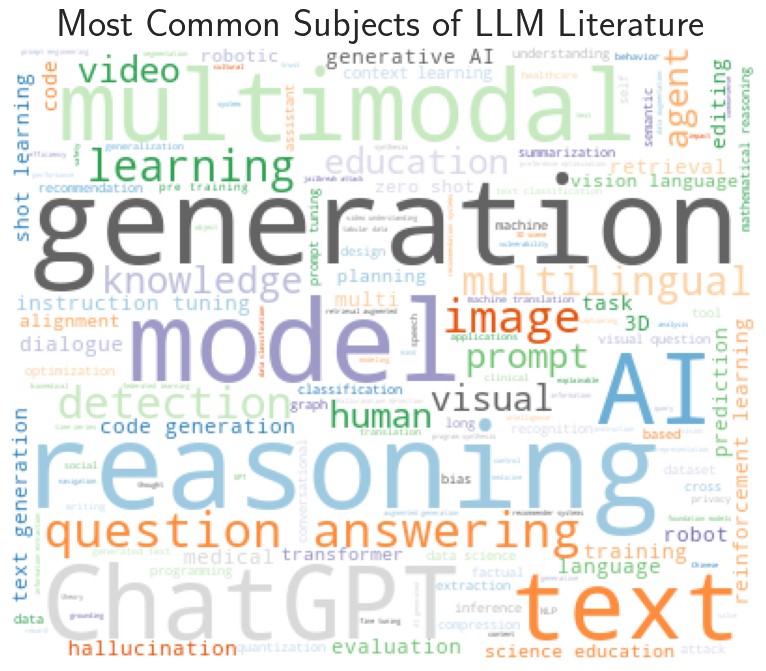

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

content = [r["primary"] for r in merged_df["Results"].tolist()]
def norm(x):
    if "LLM" in x:
        x = x.replace("LLM", "large language model")
    return x
content = [norm(c) for c in content]
content = [c for c in content if "language model" not in c]

wordcloud = WordCloud(colormap='tab20c',
                     width=400,
                      height=330,
                      background_color='white',
                      max_words=150,
                      #mask = mask,
                     collocations=True).generate("\n".join(content))
plt.figure(figsize=(10,8))
plt.title("Most Common Subjects of LLM Literature", fontsize=28)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


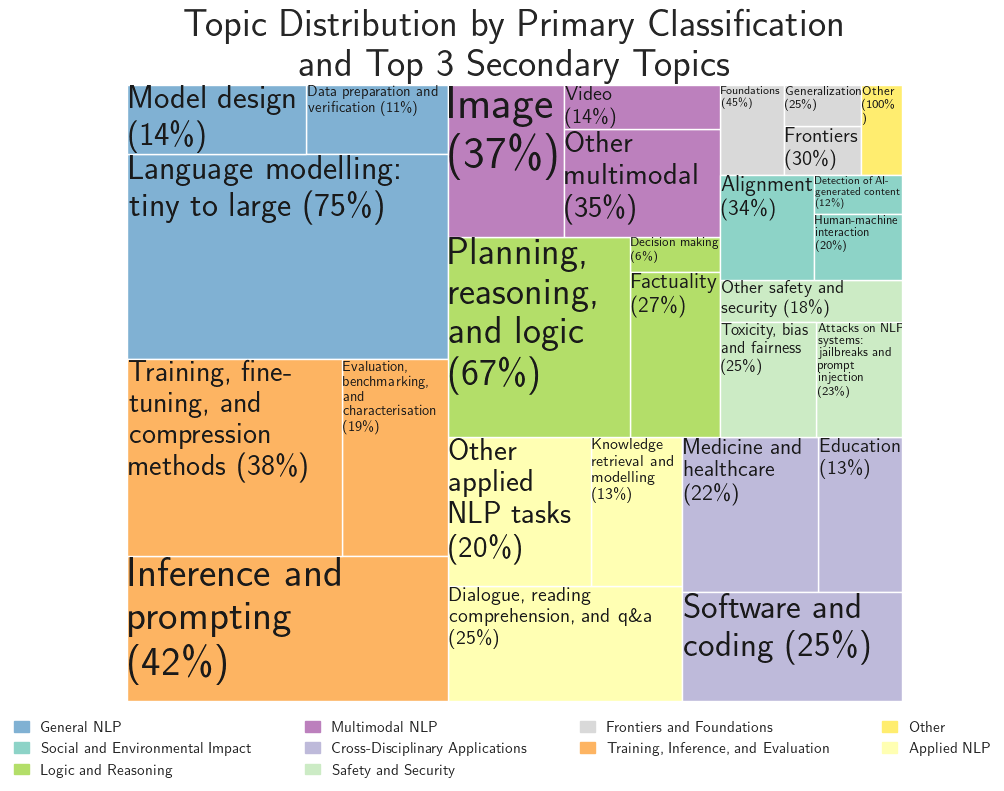

In [9]:
# https://github.com/chenyulue/matplotlib-extra/tree/master/src/mpl_extra
import mpl_extra.treemap as tr

def lookup_primary(secondary):
    for i in range(len(merged_df["Results"])):
        if merged_df["Results"].iloc[i]["primary_secondary_category"] == secondary:
            return merged_df["Results"].iloc[i]["primary_main_category"]
    return ""


fd = []
counter1 = Counter([x["primary_main_category"] for x in merged_df["Results"].tolist()])
counter2 = Counter()
for cat in counter1.keys():
    counter_tmp = Counter([x["primary_secondary_category"] for x in merged_df["Results"].tolist() if lookup_primary(x["primary_secondary_category"]) == cat])
    counter2.update(dict(counter_tmp.most_common(3)))


def format_secondary(secondary, vol):
    primary = lookup_primary(secondary)
    secondary = secondary if "Q&A" not in secondary else "dialogue, reading comprehension, and Q\&A"
    secondary = secondary.capitalize()
    if " ai " in secondary:
        secondary = secondary.replace("ai", "AI")
    if "ai-" in secondary:
        secondary = secondary.replace("ai-", "AI-")
    if "nlp" in secondary:
        secondary = secondary.replace("nlp", "NLP")
    if "q&a" in secondary:
        secondary = secondary.replace("q&a", "Q&A")
    total = counter1[primary]
    secondary += f"\n({round(vol*100/total)}\%)"
    return secondary

for secondary, secondary_volume in counter2.items():
    entry = {"Main": "main",
             "Primary": lookup_primary(secondary),
             "Secondary": format_secondary(secondary, secondary_volume),
             "SecondaryVolume": secondary_volume}
    fd.append(entry)
this_df = pd.DataFrame(fd)


fig, ax = plt.subplots(figsize=(10,8), dpi=100) #, subplot_kw=dict(aspect=1.5))

this_cmap = tr.get_colormap('Set3', this_df['Primary'])

trc = tr.treemap(
    ax, this_df, area='SecondaryVolume', fill='Primary', labels='Secondary',
    levels=['Primary', 'Secondary'], cmap=this_cmap,
    rectprops=dict(ec='w'),
    textprops=dict(c='k', reflow=True, place='top left'),
        subgroup_rectprops=dict(region={}),
)

ax.axis('off')
ax.set_title('Topic Distribution by Primary Classification\nand Top 3 Secondary Topics', fontsize=28)
handles = sorted(trc.handles['Secondary'], key=lambda x: (x.get_ec(),x.get_label()))
legend = fig.legend(handles=[handles[i] for i in range(0, len(handles))],
                    ncol=4, loc='lower left',
                    handlelength=1, mode='expand', frameon=False)
plt.show()

In [7]:
def get_correlated_compositions_for_topic(do_sota=False):
    x_by_year_df = get_by_year_df()
    if do_sota:
        z = x_by_year_df[x_by_year_df["SOTA"] == "y"]
    counters = []
    for year in [2021, 2022, 2023, 2024]:
        _yearly = x_by_year_df[x_by_year_df["year"] == year]
        counter = Counter([x for x in _yearly["primary_main_category"].tolist()])
        counters.append(counter)
    return counters

table = "Topic & 2021 (\%) & 2022 (\%) & 2023 (\%) & 2024 (\%) \\\\ \\hline\n"
topics_by_year = get_correlated_compositions_for_topic()

for topic in topics_by_year[-1]:
    table += f"{topic} & "
    for i, year in enumerate([2021, 2022, 2023, 2024]):
        this_year = topics_by_year[i]
        if topic not in this_year:
            c = 0
        else:
            c = this_year[topic]
        yearly_total = sum([v for k,v in this_year.items()])
        c = c*100./yearly_total
        table += f"{str(round(c))} &"
    table = table[:-2] + " "
    table += "\\\\ \n"

table += "\\hline"

print(table)

Topic & 2021 (\%) & 2022 (\%) & 2023 (\%) & 2024 (\%) \\ \hline
Logic and Reasoning & 8 &12 &12 &10 \\ 
Applied NLP & 26 &21 &20 &17 \\ 
Multimodal NLP & 2 &6 &8 &16 \\ 
Cross-Disciplinary Applications & 8 &10 &18 &19 \\ 
Training, Inference, and Evaluation & 30 &27 &19 &16 \\ 
General NLP & 20 &15 &15 &11 \\ 
Safety and Security & 2 &4 &3 &6 \\ 
Social and Environmental Impact & 1 &2 &4 &3 \\ 
Other & 0 &0 &1 &0 \\ 
Frontiers and Foundations & 2 &3 &1 &1 \\ 
\hline


## Some Statistics

In [10]:
print(f"Total dataset size: {len(_all_lines)} | Is LLM: {len(df_gpt3_llm) + len(df_gpt4_llm)}")
sota_merged_df = merged_df[merged_df["SOTA"] == "y"]
print(f"Total: {len(df_gpt3) + len(df_gpt4)} | All articles: {len(merged_df)}; SOTA claims: {len(sota_merged_df)}; Proportion: {round(len(sota_merged_df)*100/len(merged_df), 2)}%")

Total dataset size: 3914 | Is LLM: 2054
Total: 3914 | All articles: 2054; SOTA claims: 1164; Proportion: 56.67%


In [11]:
def get_correlated_compositions(metric, dependents = ["stat_sig", "errors", "randomness", "human-metric", "llm-metric", "automatic-metric"], do_sota=True, is_binary=False):

    x_by_year_df = get_by_year_df()
    is_only = "only" in metric
    if is_only:
        metric = metric.split(" ")[-1]
    
    if do_sota:
        z = x_by_year_df[x_by_year_df["SOTA"] == "y"]
    if is_binary:
        z = x_by_year_df[x_by_year_df[f"{metric}-metric"] == 1]
        print("original", len(z))
        if is_only:
            others = [t for t in ["human-metric", "llm-metric", "automatic-metric"] if t != metric + "-metric"] #, "automatic-metric"
            for o in others:
                _z = z[z[f"{o}"] == 0]
                print(f"{metric} without {o} ONLY: {len(_z)} | {round(len(_z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")
                print(f"{metric} without {o} &ONLY: {len(_z)} | {round(len(_z)*100/len(x_by_year_df), 2)}%")

            for o in others:
                z = z[z[f"{o}"] == 0]
                print(f"{metric} without {o}: {len(z)} | {round(len(z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")
            print(f"Final size ablated: {metric}, others, {len(z)} | {round(len(z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")
    else:
        if m == "mean":
            z = x_by_year_df
        else:
            z = x_by_year_df[x_by_year_df[metric] == "y"]
    corrs = [len(z)*100/len(x_by_year_df)]
    for dependent in dependents:
        if "metric" in dependent:
            x = z[z[dependent] == 1]
        else:
            x = z[z[dependent] == "y"]
        if len(z) == 0:
            corrs.append(0)
        else:
            corrs.append(len(x)*100/len(z))
    return corrs

In [12]:
def tf(name, corr, m_arr, end=False):
    if m_arr is None:
        m_arr = corr
    tab = f"{name} & "
    for i, c in enumerate(corr):
        _f = str(round(c))
        if c < m_arr[i] and i != 0:
            tab += " \\cellcolor{blue!10}"
        if c == 0:
            tab += " \\cellcolor{gray!10}"
        if c == 100:
            tab += " \\cellcolor{gray!10}"
        tab += f" {_f} & "
    tab = tab[:-2] + " "
    tab += "\\\\"
    if end:
        tab += "\\hline"
    tab += "\n"
    return tab

mean_array = None
table = "Criterion & Percentage in Corpus & Stat Sig & Error Breakdown & Randomness & Parameters & Human Evaluators & LLM Evaluators & Automatic Evaluators  \\\\ \\hline\n"

for n, m in [("Corpus Average", "mean"), ("Ethics Section", "ethics"), ("Limitations Section", "limitations"), ("Negative Results", "negative"),
             ("Error Breakdown", "errors"),
             ("Emergent Behaviour Claims", "emergence"), ("Can Reason Claims", "can reason"), ("Cannot Reason Claims", "cannot reason"),
             ("Super-Human Capabilities Claims", "superhuman"), ("Human Evaluators", "human"), ("LLM Evaluators", "llm"), ("Automatic Evaluators", "automatic")]:
    r = get_correlated_compositions(m, is_binary=m in ["human", "llm", "automatic", "only human", "only llm", "only automatic"])
    table += tf(n, r, mean_array, end=m in ["mean", "negative", "superhuman"])
    if m == "mean":
        mean_array = r

table += "\\hline"

original 316
original 148
original 1000


In [13]:
print(table)

Criterion & Percentage in Corpus & Stat Sig & Error Breakdown & Randomness & Parameters & Human Evaluators & LLM Evaluators & Automatic Evaluators  \\ \hline
Corpus Average &  \cellcolor{gray!10} 100 &  25 &  16 &  10 &  27 &  13 &  86  \\\hline
Ethics Section &  30 &  30 &  21 &  11 &  39 &  17 &  \cellcolor{blue!10} 85  \\
Limitations Section &  61 &  31 &  18 &  11 &  32 &  16 &  86  \\
Negative Results &  13 &  40 &  32 &  15 &  39 &  \cellcolor{blue!10} 7 &  \cellcolor{blue!10} 81  \\\hline
Error Breakdown &  16 &  33 &  \cellcolor{gray!10} 100 &  16 &  49 &  17 &  95  \\
Emergent Behaviour Claims &  39 &  26 &  \cellcolor{blue!10} 14 &  13 &  \cellcolor{blue!10} 26 &  \cellcolor{blue!10} 12 &  \cellcolor{blue!10} 83  \\
Can Reason Claims &  27 &  \cellcolor{blue!10} 24 &  \cellcolor{blue!10} 14 &  14 &  28 &  15 &  87  \\
Cannot Reason Claims &  6 &  39 &  24 &  17 &  37 &  \cellcolor{blue!10} 11 &  \cellcolor{blue!10} 76  \\
Super-Human Capabilities Claims &  5 &  40 &  27 &  18

In [14]:
def get_correlated_compositions2(metric, dependents = ["stat_sig", "errors", "randomness", "can reason", "cannot reason", "emergence", "human-metric", "llm-metric", "automatic-metric"], do_sota=True, is_binary=False, mean_array=False):

    x_by_year_df = get_by_year_df(do_sota=do_sota)
    z = x_by_year_df
    if do_sota:
        z = x_by_year_df[x_by_year_df["SOTA"] == "y"]

    corrs = []
    if mean_array:
        _corrs = [f"Mean {'(SOTA)' if do_sota else ''}", 100, 100]
        for dependent in dependents:
            if "metric" in dependent:
                x = z[z[dependent] == 1]
            else:
                x = z[z[dependent] == "y"]
            if len(z) == 0:
                _corrs.append(0)
            else:
                _corrs.append(len(x)*100/len(z))
        corrs.append(_corrs)
        return corrs
    
    is_only = "only" in metric
    if is_only:
        metric = metric.split(" ")[-1]
    
    z = x_by_year_df[x_by_year_df[f"{metric}-metric"] == 1]
    print("original", len(z))

    others = [t for t in ["human-metric", "llm-metric", "automatic-metric"] if t != metric + "-metric"] #, "automatic-metric"
    corrs = []

    for o in others:
        _z = z[z[f"{o}"] == 0]
        #print(f"{metric} without {o} ONLY: {len(_z)} | {round(len(_z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")
        #print(f"{metric} without {o} &ONLY: {len(_z)} | {round(len(_z)*100/len(x_by_year_df), 2)}%")
        _corrs = [f"{metric} without {o.replace("-metric", "")} *ONLY", len(_z)*100/len(x_by_year_df), len(_z)*100/len(z)]
        for dependent in dependents:
            if "metric" in dependent:
                x = _z[_z[dependent] == 1]
            else:
                x = _z[_z[dependent] == "y"]
            if len(z) == 0:
                _corrs.append(0)
            else:
                _corrs.append(len(x)*100/len(_z))
        corrs.append(_corrs)
        #corrs.append(f"{metric} without {o} ONLY: {len(_z)} | {round(len(_z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")

    _o = ""
    for o in others:
        _o += _o + f"{o.replace("-metric", "")} and "
        z = z[z[f"{o}"] == 0]        
        _corrs = [f"{metric} without {_o}", len(z)*100/len(x_by_year_df), len(z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1])]
        #print(f"{metric} without {o}: {len(z)} | {round(len(z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")
        for dependent in dependents:
            if "metric" in dependent:
                x = z[z[dependent] == 1]
            else:
                x = z[z[dependent] == "y"]
            if len(z) == 0:
                _corrs.append(0)
            else:
                _corrs.append(len(x)*100/len(z))
        corrs.append(_corrs)
    #print(f"Final size ablated: {metric}, others, {len(z)} | {round(len(z)*100/len(x_by_year_df[x_by_year_df[f'{metric}-metric'] == 1]), 2)}%")

    return corrs

In [15]:
def tf(name, corr, m_arr, end=False):
    if m_arr is None:
        m_arr = corr
    tab = f"{name} & "
    for i, c in enumerate(corr[:-3]):
        _f = str(round(c))
        if c < m_arr[i] - 2 and i != 0:
            tab += " \\cellcolor{blue!10}"
        tab += f" {_f} & "
    tab = tab[:-2] + " "
    tab += "\\\\"
    if end:
        tab += "\\hline"
    tab += "\n"
    return tab

mean_array = None
table = "Criterion & Corpus (\%) & Subset (\%) & Stat Sig. & Error Breakdown & Random. & Can Reason & Cannot Reason & Emergence \\\\ \\hline\n"

for n, m in [("*Human Eval.", "only human"), ("*LLM Eval.", "only llm"), ("*Automatic Eval.", "only automatic")]:
    r = get_correlated_compositions2(m, is_binary=True, do_sota=True)
    mean_r = get_correlated_compositions2(m, is_binary=True, do_sota=False)
    for arr, m_arr in zip(r, mean_r):
        _n = arr[0]
        _r = arr[1:]
        table += tf(_n, _r, m_arr[1:], end=m in ["only human", "only llm", "only automatic"])

r = get_correlated_compositions2(m, is_binary=True, mean_array=True, do_sota=True)[0]
table += tf(r[0], r[1:], mean_array, end=True)

table += "\\hline"

original 316
original 578
original 148
original 229
original 1000
original 1519


In [16]:
print(table)

Criterion & Corpus (\%) & Subset (\%) & Stat Sig. & Error Breakdown & Random. & Can Reason & Cannot Reason & Emergence \\ \hline
human without llm *ONLY &  23 &  \cellcolor{blue!10} 84 &  \cellcolor{blue!10} 35 &  31 &  \cellcolor{blue!10} 11 &  29 &  8 &  38  \\\hline
human without automatic *ONLY &  4 &  \cellcolor{blue!10} 16 &  \cellcolor{blue!10} 31 &  18 &  \cellcolor{blue!10} 12 &  27 &  12 &  35  \\\hline
human without llm and  &  23 &  \cellcolor{blue!10} 84 &  \cellcolor{blue!10} 35 &  31 &  \cellcolor{blue!10} 11 &  29 &  8 &  38  \\\hline
human without llm and llm and automatic and  &  2 &  \cellcolor{blue!10} 9 &  \cellcolor{blue!10} 29 &  25 &  \cellcolor{blue!10} 7 &  36 &  14 &  43  \\\hline
llm without human *ONLY &  8 &  66 &  \cellcolor{blue!10} 22 &  23 &  15 &  35 &  4 &  \cellcolor{blue!10} 39  \\\hline
llm without automatic *ONLY &  2 &  \cellcolor{blue!10} 18 &  \cellcolor{blue!10} 35 &  \cellcolor{blue!10} 8 &  19 &  \cellcolor{blue!10} 19 &  8 &  \cellcolor{bl

## Dataset Composition

In [17]:
def get_cats(df, names, keys):
    cats = []
    for k in keys:
        _cats = []
        df_len = sum([len(df[df[k] == n]) for n in names])
        for n in names:
            x = round(len(  df[df[k] == n] )*100/df_len, 1 )
            _cats.append(x)
        cats.append(_cats)
    return cats[0]


def survey(results, category_names, label_override=["yes", "no", "n/a"], category_colors=default_binary):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.95,
                        label=colname, color=color)

        text_color = 'white' #'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, label_override, ncols=len(category_names), bbox_to_anchor=(1, 0),
              loc='best', fontsize='small')

    fig.tight_layout()
    return fig, ax

### Full Corpus

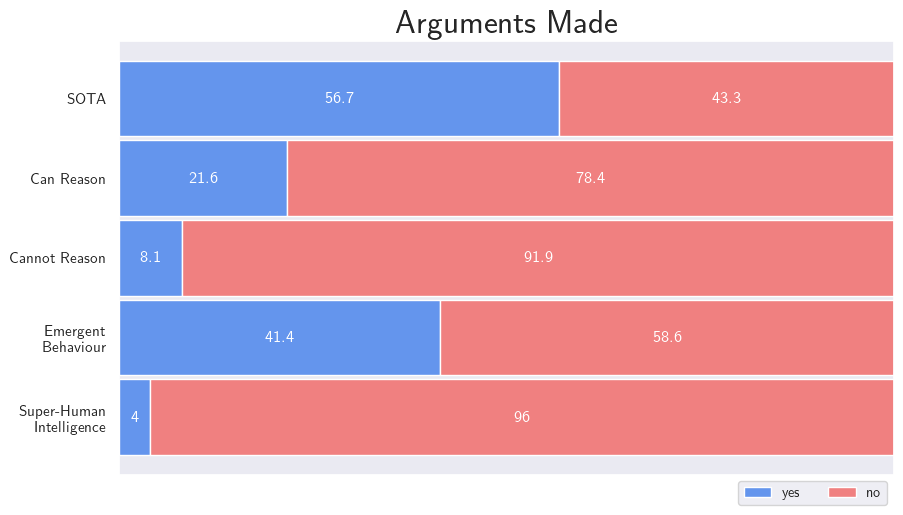

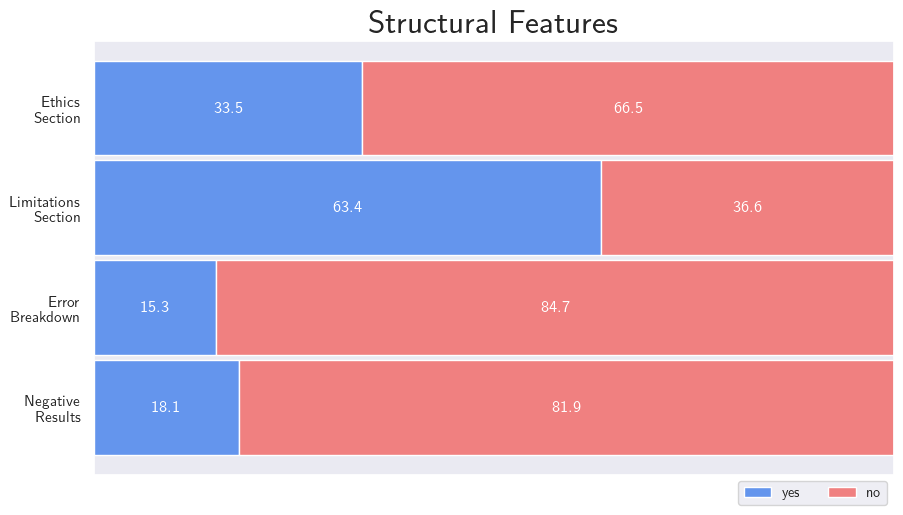

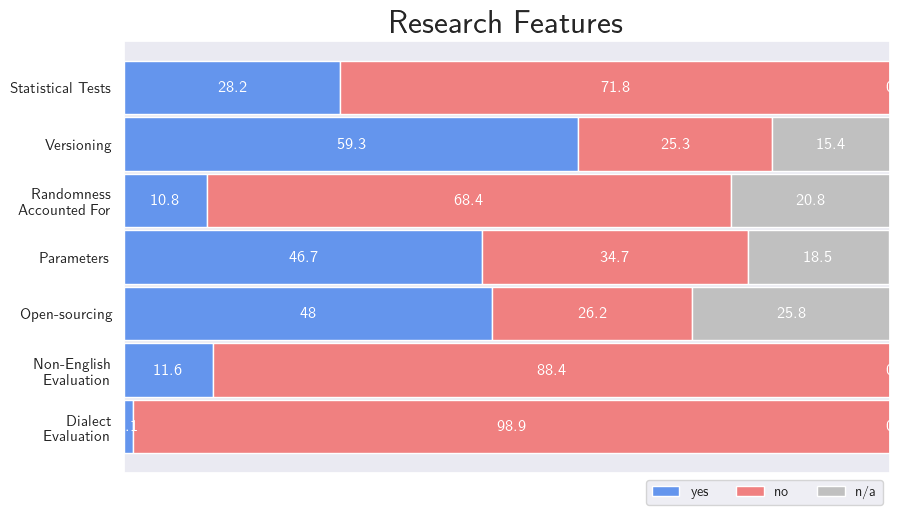

In [18]:
category_names = ['y', 'n']

arr = [('SOTA', "SOTA"),
       ("can reason", 'Can Reason'),
        ("cannot reason", "Cannot Reason"),
       ("emergence", "Emergent\nBehaviour"),
       ("superhuman", "Super-Human\nIntelligence")
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(merged_df, category_names, [key])
survey(results, category_names)
plt.title("Arguments Made", fontsize=24)
plt.show()


arr = [('ethics', "Ethics\nSection"),
       ("limitations", 'Limitations\nSection'),
       ("errors", "Error\nBreakdown"),
       ("negative", "Negative\nResults")
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(merged_df, category_names, [key])
survey(results, category_names)
plt.title("Structural Features", fontsize=24)
plt.show()


category_names = ['y', 'n', 'na']

arr = [("stat_sig", "Statistical Tests"),
       ('versions', "Versioning"),
       ("randomness", "Randomness\nAccounted For"),
       ("parameters", 'Parameters'),
       ("opensourcing", "Open-sourcing"),
       ("nonenglish", "Non-English\nEvaluation"),
       ("dialects", "Dialect\nEvaluation"),
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(merged_df, category_names, [key])
survey(results, category_names)
plt.title("Research Features", fontsize=24)
plt.show()

### SOTA Claims

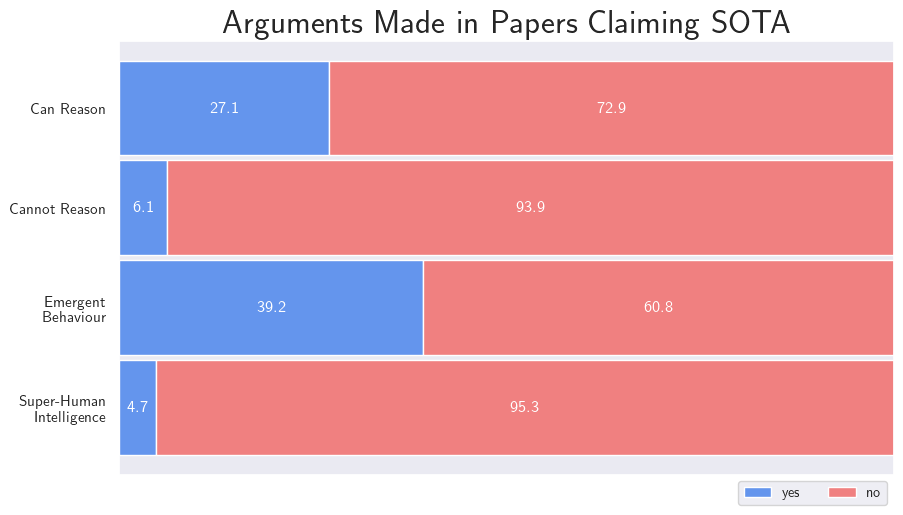

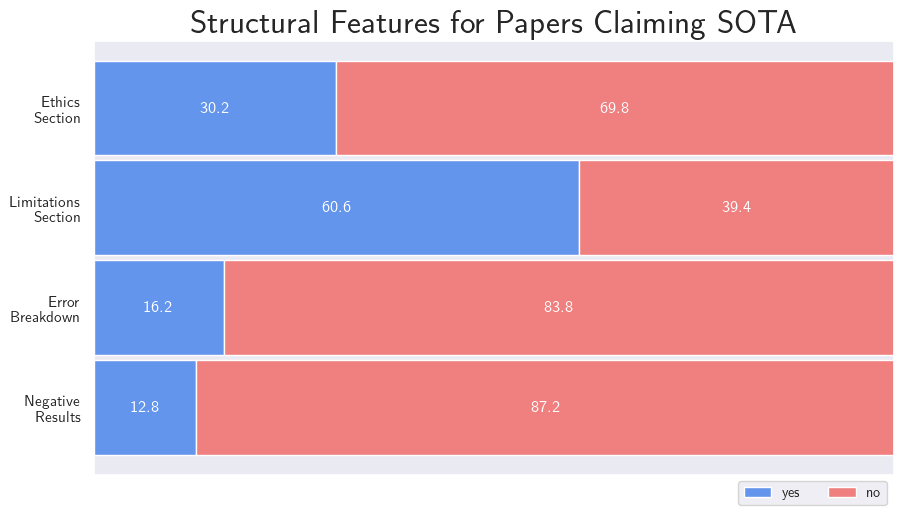

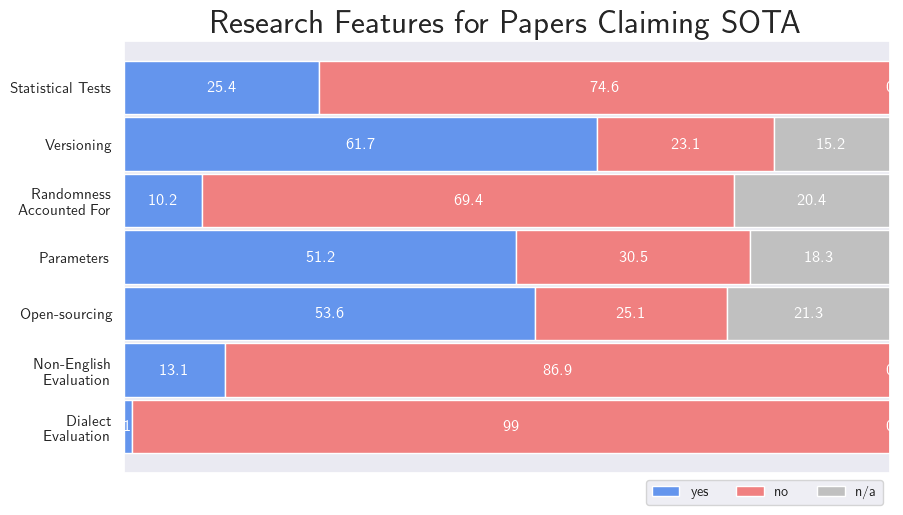

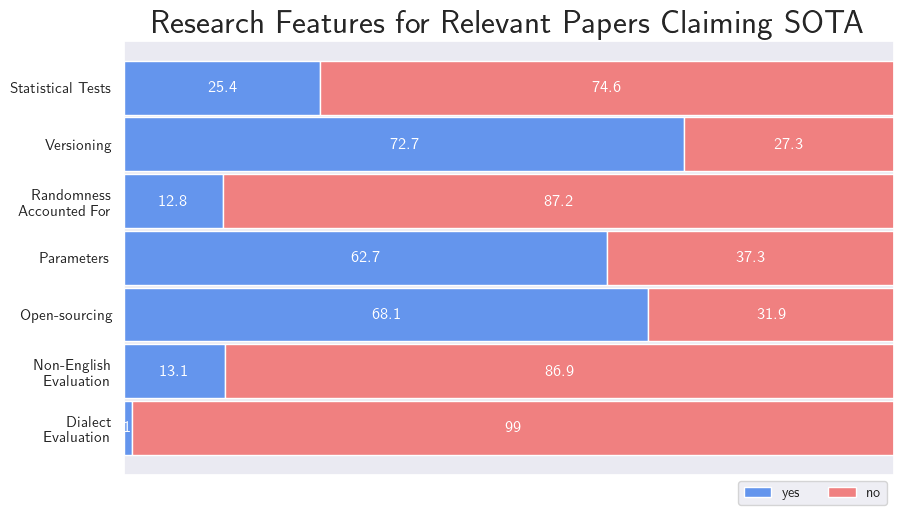

In [19]:
sota_merged_df = merged_df[merged_df["SOTA"] == "y"]
category_names = ['y', 'n']

arr = [("can reason", 'Can Reason'),
       ("cannot reason", "Cannot Reason"),
       ("emergence", "Emergent\nBehaviour"),
       ("superhuman", "Super-Human\nIntelligence")
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(sota_merged_df, category_names, [key])
survey(results, category_names)
plt.title("Arguments Made in Papers Claiming SOTA", fontsize=24)
plt.show()


arr = [('ethics', "Ethics\nSection"),
       ("limitations", 'Limitations\nSection'),
       ("errors", "Error\nBreakdown"),
       ("negative", "Negative\nResults")
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(sota_merged_df, category_names, [key])
survey(results, category_names)
plt.title("Structural Features for Papers Claiming SOTA", fontsize=24)
plt.show()


category_names = ['y', 'n', 'na']

arr = [("stat_sig", "Statistical Tests"),
       ('versions', "Versioning"),
       ("randomness", "Randomness\nAccounted For"),
       ("parameters", 'Parameters'),
       ("opensourcing", "Open-sourcing"),
       ("nonenglish", "Non-English\nEvaluation"),
       ("dialects", "Dialect\nEvaluation"),
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(sota_merged_df, category_names, [key])
survey(results, category_names)
plt.title("Research Features for Papers Claiming SOTA", fontsize=24)
plt.show()

category_names = ['y', 'n'] #, 'na']

arr = [("stat_sig", "Statistical Tests"),
       ('versions', "Versioning"),
       ("randomness", "Randomness\nAccounted For"),
       ("parameters", 'Parameters'),
       ("opensourcing", "Open-sourcing"),
       ("nonenglish", "Non-English\nEvaluation"),
       ("dialects", "Dialect\nEvaluation"),
      ]
results = {}
for key, title in arr:
    results[title] = get_cats(sota_merged_df, category_names, [key])
survey(results, category_names)
plt.title("Research Features for Relevant Papers Claiming SOTA", fontsize=24)
plt.show()


### Selected Results

I.e., the main bits in the paper

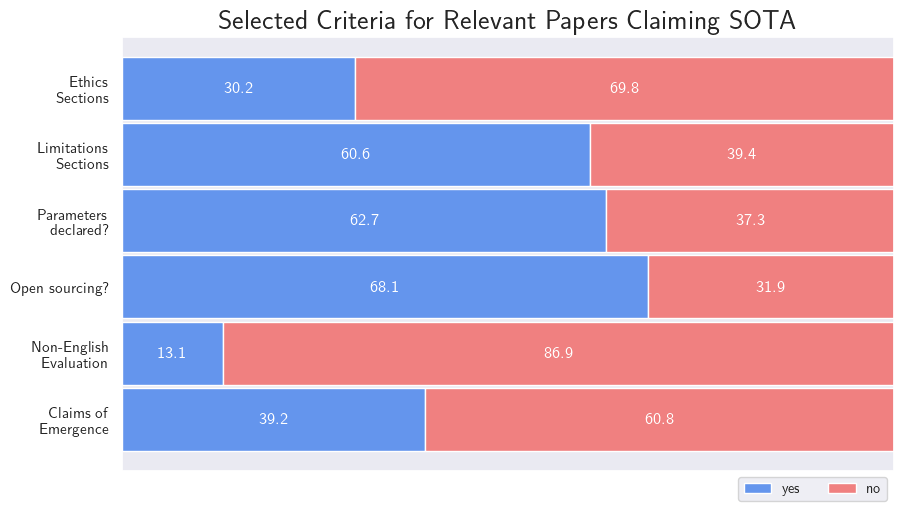

In [20]:
category_names = ['y', 'n'] #, 'na']

arr = [("ethics", "Ethics\nSections"),
       ('limitations', "Limitations\nSections"),
       ("parameters", 'Parameters\ndeclared?'),
       ("opensourcing", "Open sourcing?"),
       ("nonenglish", "Non-English\nEvaluation"),
       ("emergence", "Claims of\nEmergence")
      ]

results = {}
for key, title in arr:
    results[title] = get_cats(sota_merged_df, category_names, [key])
survey(results, category_names)
plt.title("Selected Criteria for Relevant Papers Claiming SOTA", fontsize=20)
plt.show()

## Aggregates

In [21]:
unrolled_by_year_df = get_by_year_df()
print("Yearly proportions: ", [f"{year}: | {round(len(unrolled_by_year_df[unrolled_by_year_df["year"] == year])*100/len(unrolled_by_year_df), 2)}%" for year in [2021, 2022, 2023, 2024] ])

Yearly proportions:  ['2021: | 6.87%', '2022: | 21.65%', '2023: | 25.26%', '2024: | 45.96%']


### Yearly Percentage Changes

In [22]:
by_year_df = get_by_year_df()

def plot_difference_over_year(metric, title, title_override=None, labels_override=None):

    # Remove 2020
    _by_year_df = by_year_df[by_year_df["year"] != 2020]

    if metric not in ["llm-metric", "human-metric", "automatic-metric"]:
        sota_merged_df_y = _by_year_df[_by_year_df[metric] == "y"]
        sota_merged_df_y[metric].apply(lambda x: 1 if x == "y" else 0)
    else:
        sota_merged_df_y = _by_year_df[_by_year_df[metric] == 1]
    sota_merged_df_y = sota_merged_df_y.loc[:, ["year", "Citations"]]
    if metric not in ["llm-metric", "human-metric", "automatic-metric"]:
        sota_merged_df_n = _by_year_df[_by_year_df[metric] == "n"]
        sota_merged_df_n[metric].apply(lambda x: 1 if x == "y" else 0)
    else:
        sota_merged_df_n = _by_year_df[_by_year_df[metric] == 0]
    sota_merged_df_n = sota_merged_df_n.loc[:, ["year", "Citations"]]

    if "llm" in metric:
        for y in [2021, 2022, 2023, 2024]:
            if sota_merged_df_n[sota_merged_df_n["year"] == y].empty:
                ddf = pd.DataFrame([[y, 0]], columns=["year", "Citations"])
                sota_merged_df_n = pd.concat([sota_merged_df_n, ddf])
            if sota_merged_df_y[sota_merged_df_y["year"] == y].empty:
                ddf = pd.DataFrame([[y, 0]], columns=["year", "Citations"])
                sota_merged_df_y = pd.concat([sota_merged_df_y, ddf])

    
    bins = len(list(set(_by_year_df["year"].tolist()))) # Ideally 4
    labels = [f"{title}", f"No {title}"] if labels_override is None else labels_override
    _title = f"Yearly Gap of {title} Versus Citation Count" if title_override is None else title

    fig, ax = plt.subplots() #figsize=(10,6))
    with plt.style.context(['fivethirtyeight']): #['seaborn-v0_8-poster']):
        ax.hist(sota_merged_df_y["year"], bins=bins, label=labels[0], weights=sota_merged_df_y["Citations"])
        ax.hist(sota_merged_df_n["year"], bins=bins, label=labels[1], weights=sota_merged_df_n["Citations"], alpha=0.25)
        fig.tight_layout()
        ax.set_xticks([2020.5, 2021., 2021.37, 2021.75, 2022.13, 2022.5, 2022.88, 2023.25, 2023.62])
        ax.set_xticklabels(["", "", 2021, "", 2022, "", 2023, "", 2024]) 
        plt.title(_title, fontsize=24)
        plt.ylabel("Citation Count", fontsize=20)
        plt.xlabel("Year", fontsize=20)
        plt.legend()
        plt.show()
    
        # Plot the Difference
        a_hist, _ = np.histogram(sota_merged_df_y["year"], bins=bins, weights=sota_merged_df_y["Citations"])
        b_hist, bin_edges = np.histogram(sota_merged_df_n["year"], bins=bins, weights=sota_merged_df_n["Citations"])
        h_diff = (a_hist - b_hist)/(a_hist + b_hist)
        fig, ax = plt.subplots(figsize=(7, 5))
        fig.tight_layout()
        sns.barplot(x=bin_edges[:-1], y=h_diff, color='tab:blue', ec='k', width=1, alpha=0.8, ax=ax)
        ax.margins(x=0.1)
        ax.set_xticklabels([2021, 2022, 2023, 2024])
    
        def formatter(x, pos):
            del pos
            return str(round(x*100, 1))
        ax.yaxis.set_major_formatter(formatter)
        
        plt.title(f'Yearly Percentage Difference for {title}\nWith Respect to Number of Citations', fontsize=24, fontname="Arial")
        plt.ylabel(ylabel='Difference (%)', fontsize=20, fontname="Arial")
        plt.xlabel(xlabel='Year', fontsize=20, fontname="Arial")
        plt.show()
        return (title, h_diff, [j - i for i, j in zip(h_diff[:], h_diff[1:])])


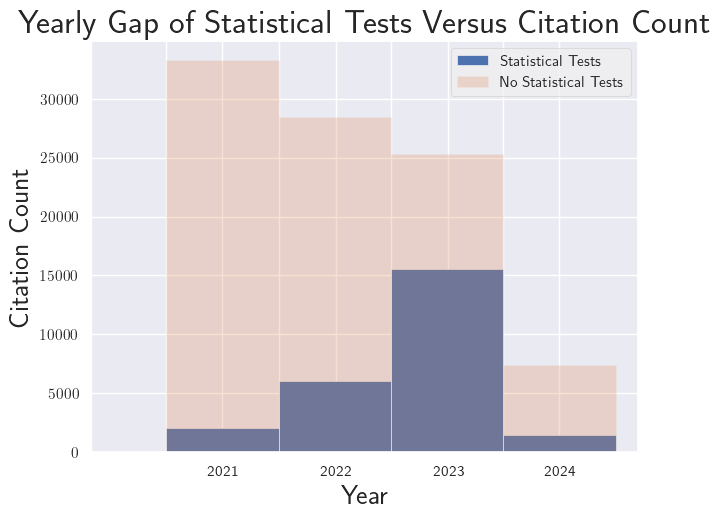

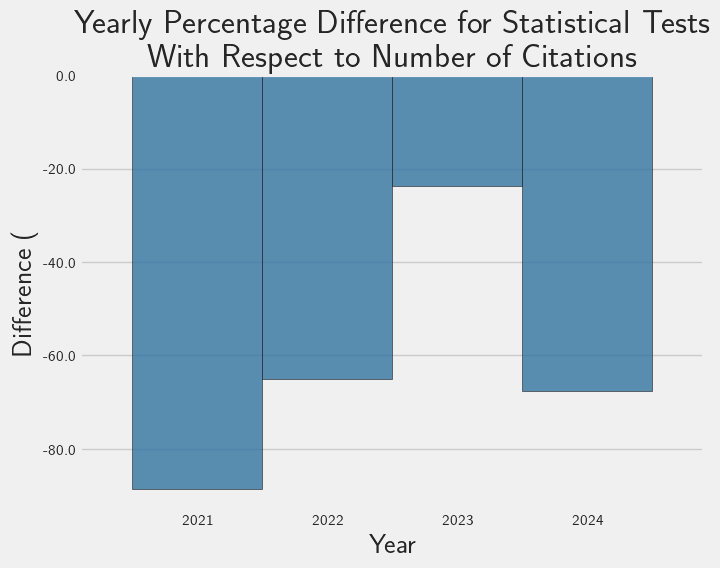

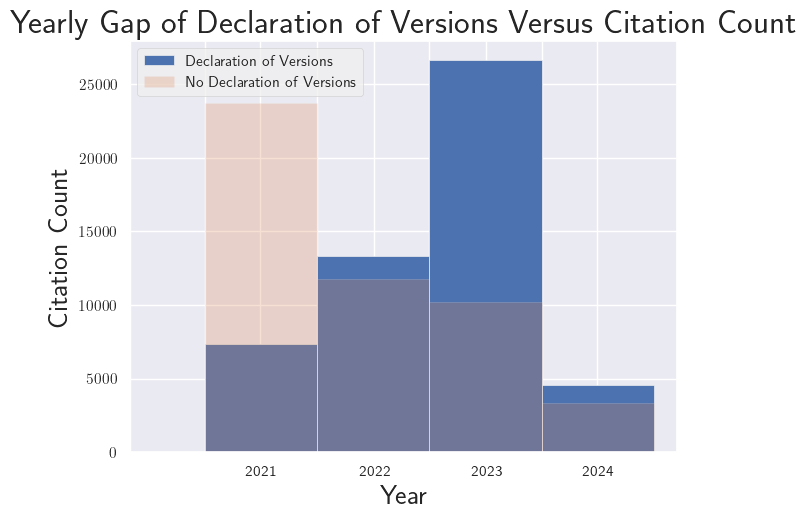

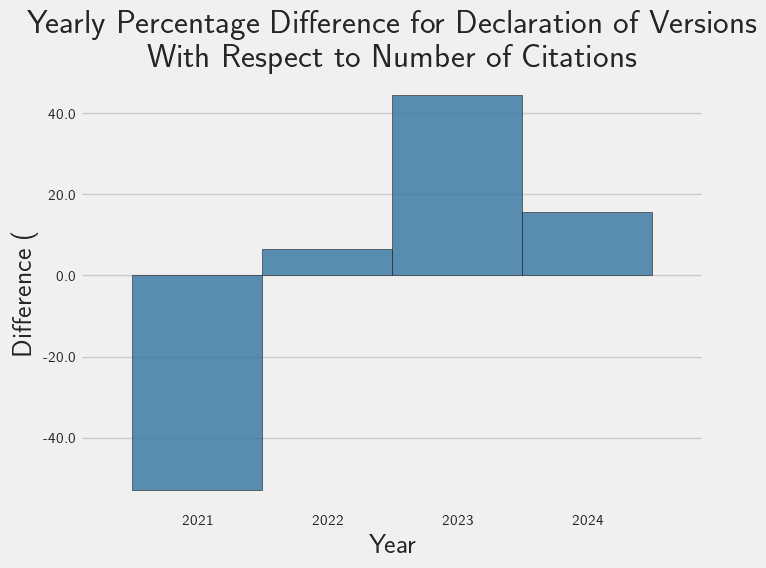

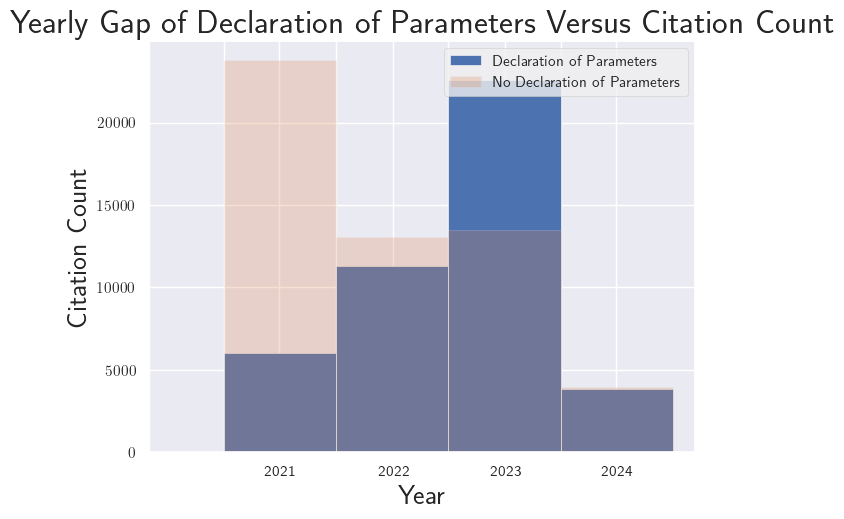

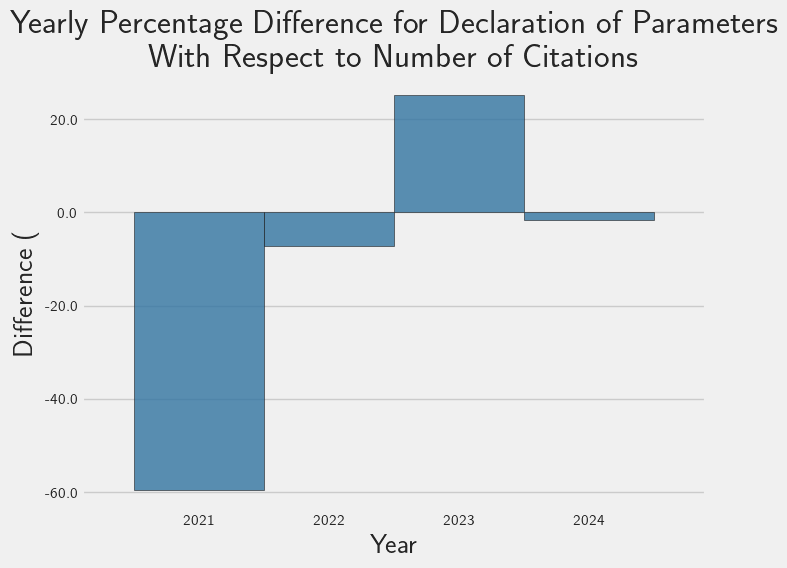

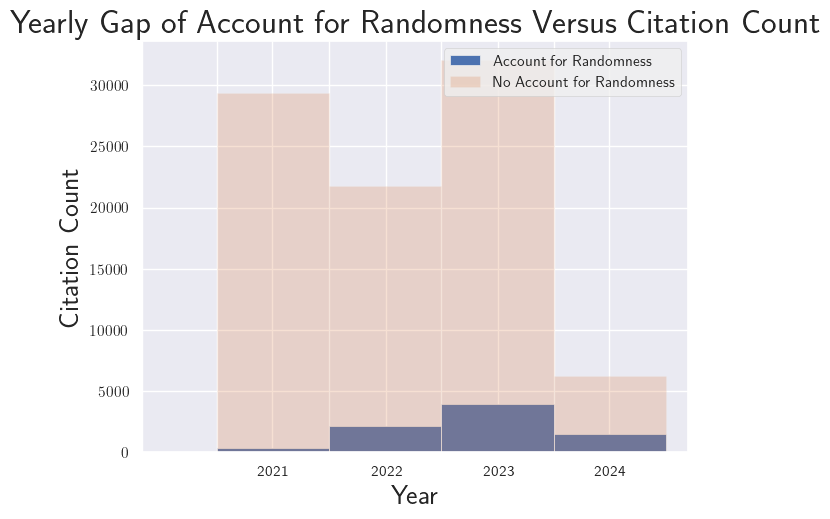

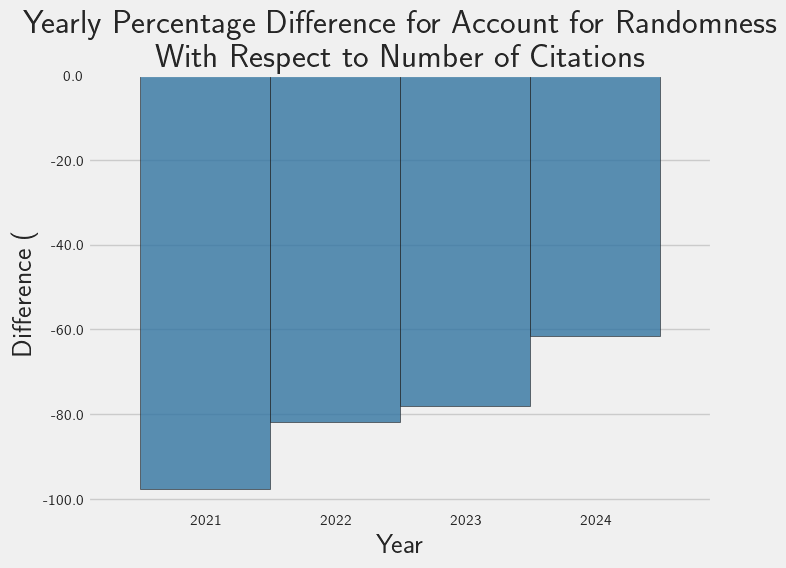

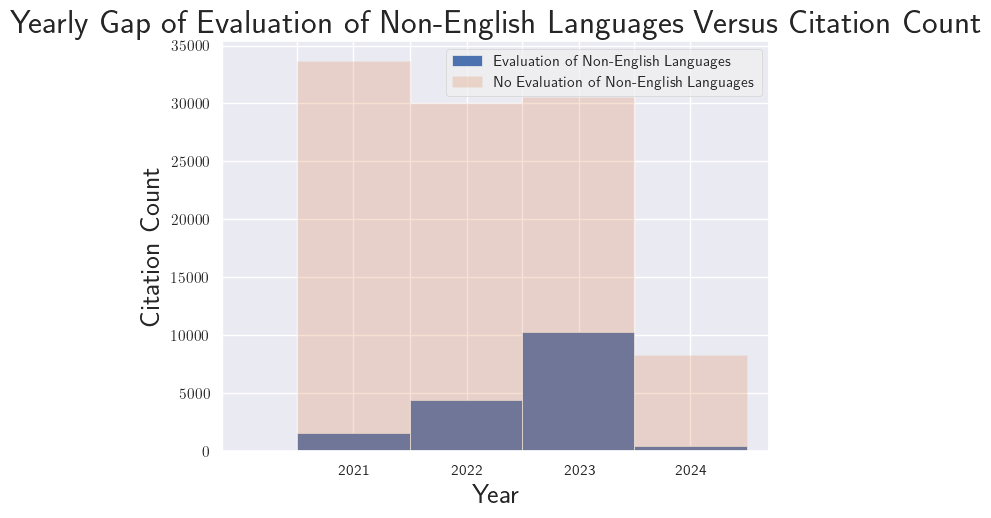

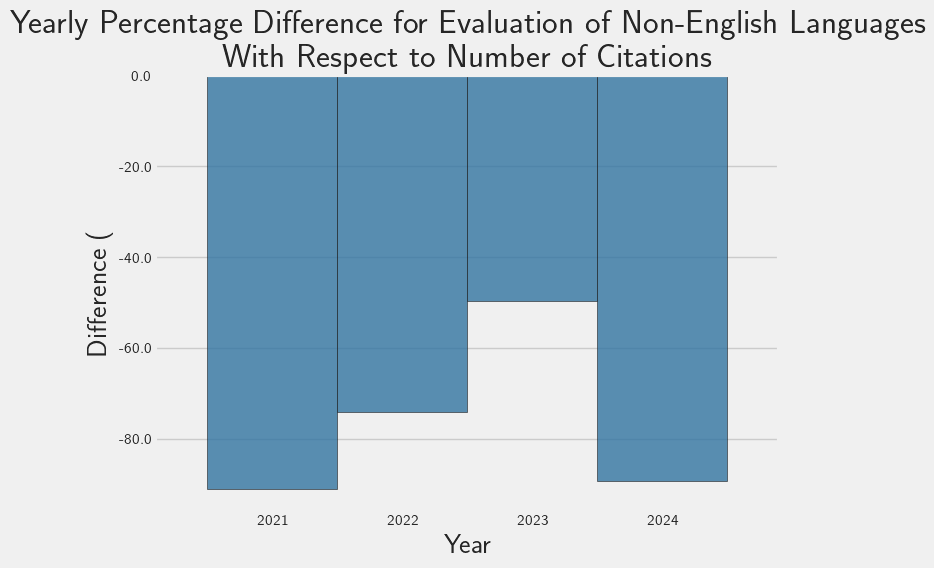

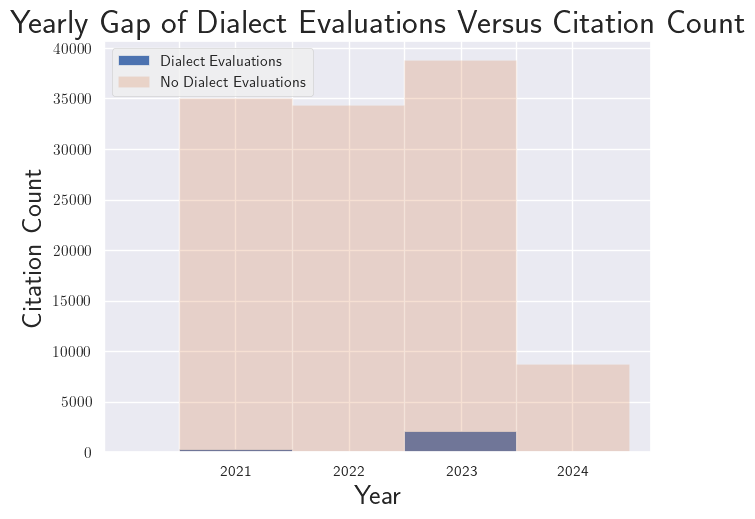

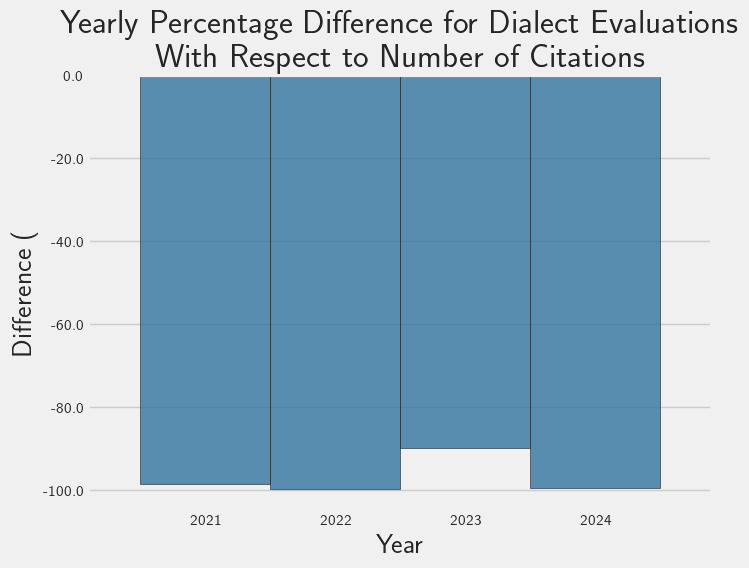

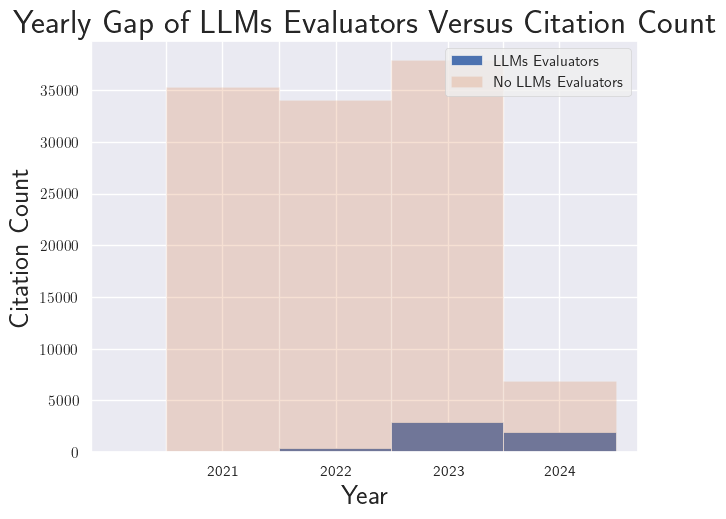

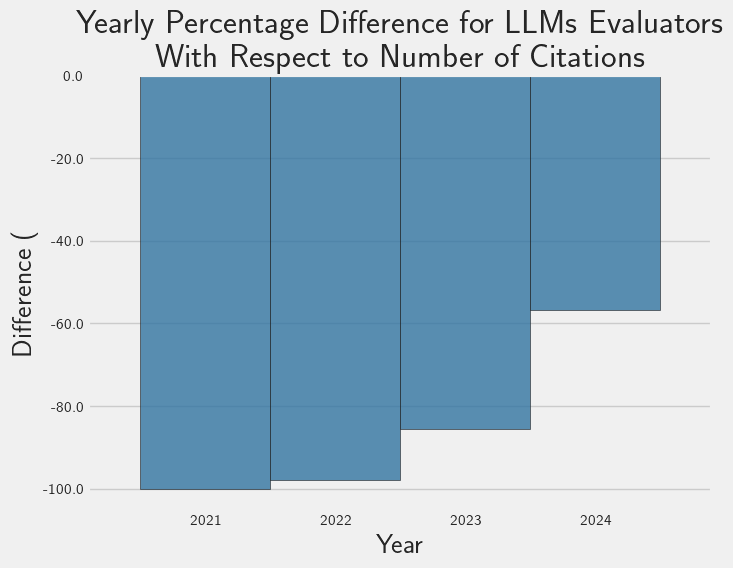

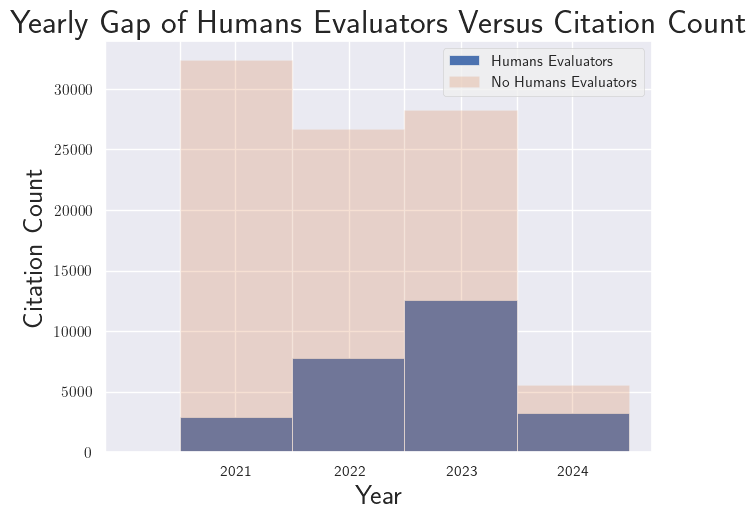

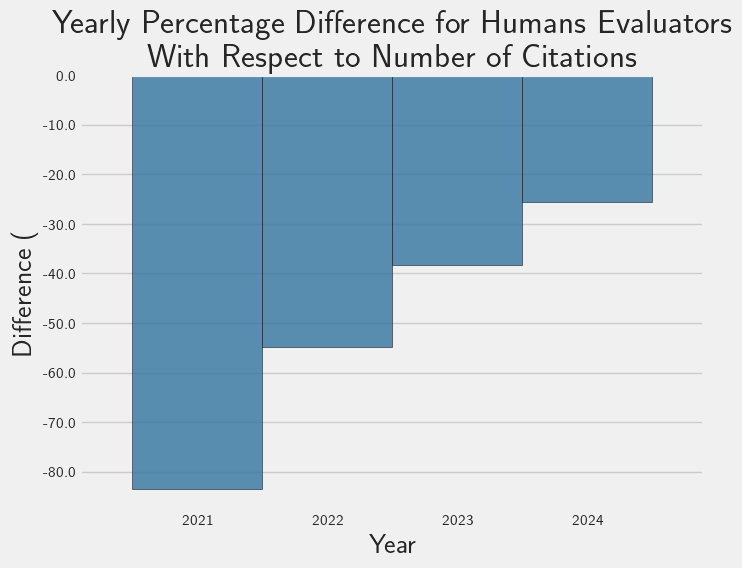

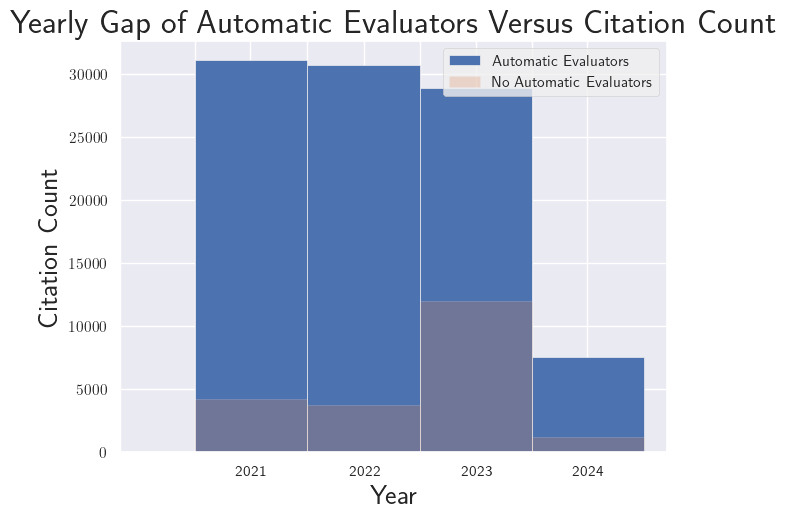

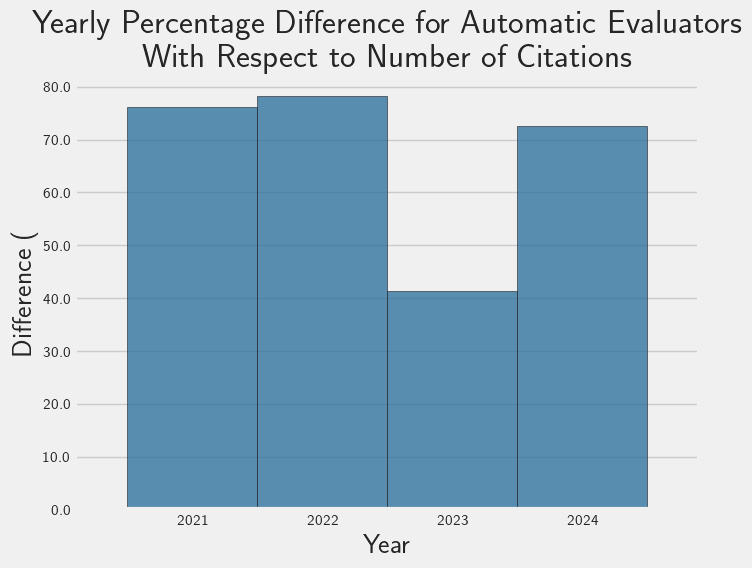

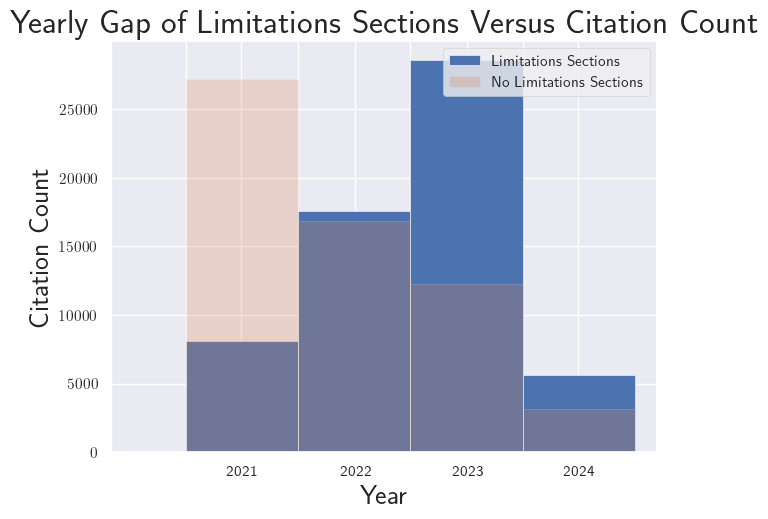

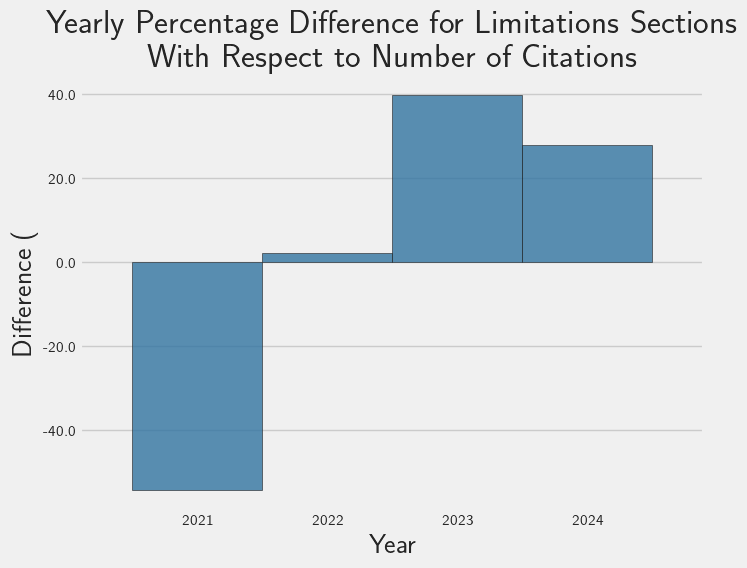

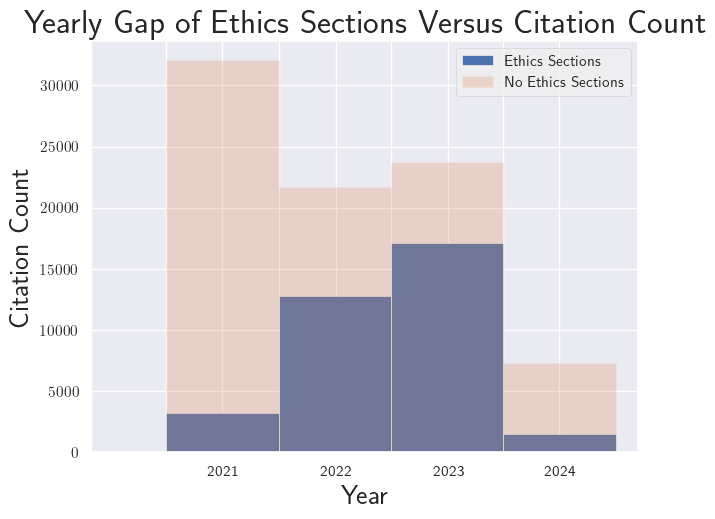

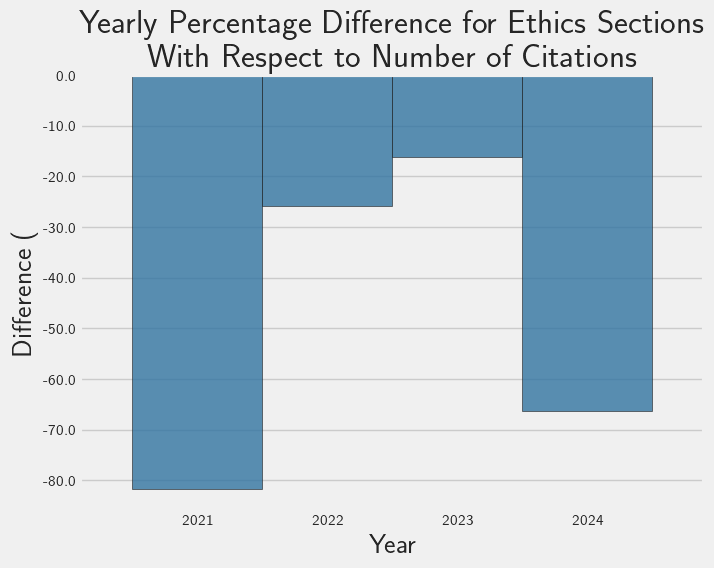

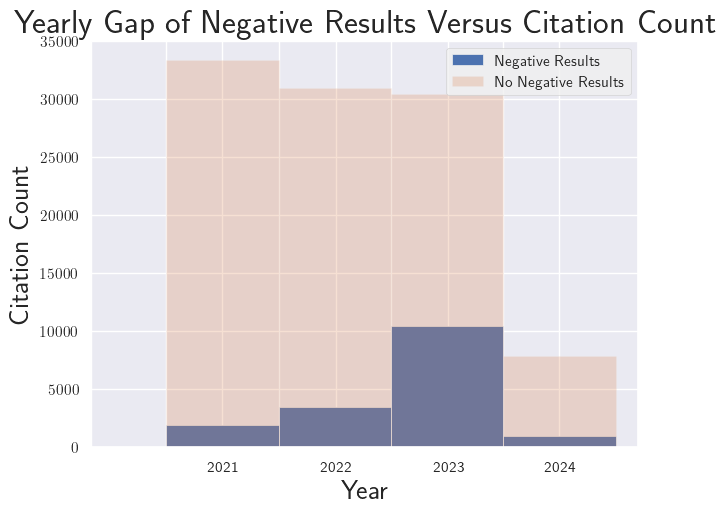

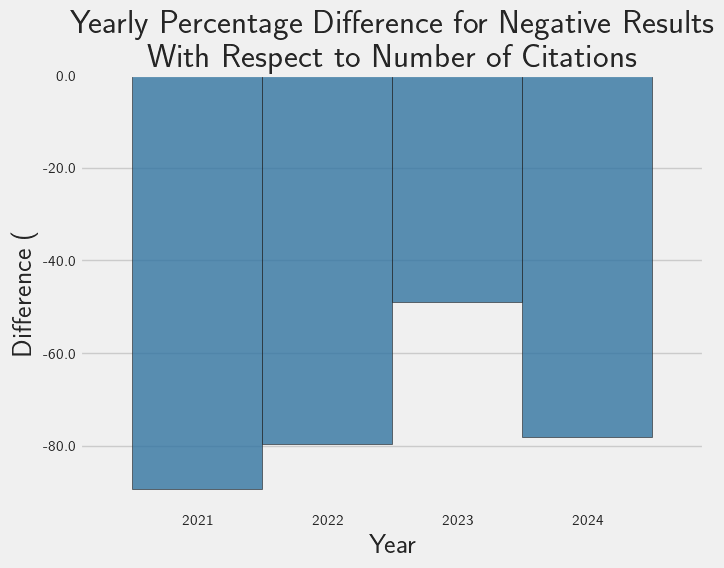

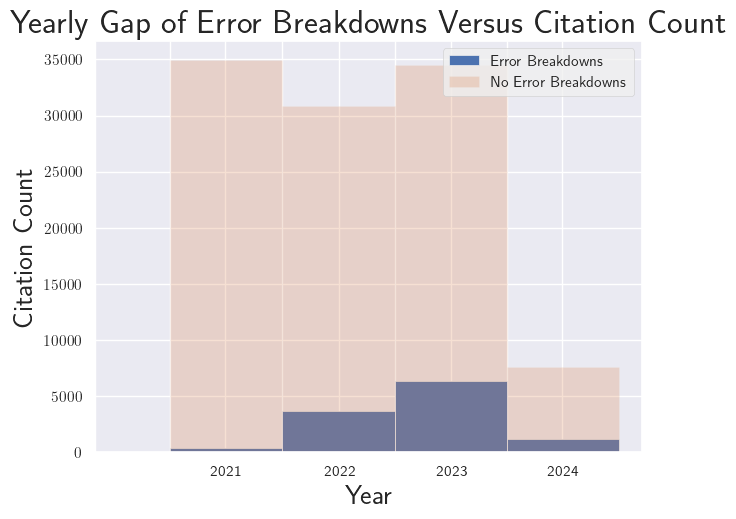

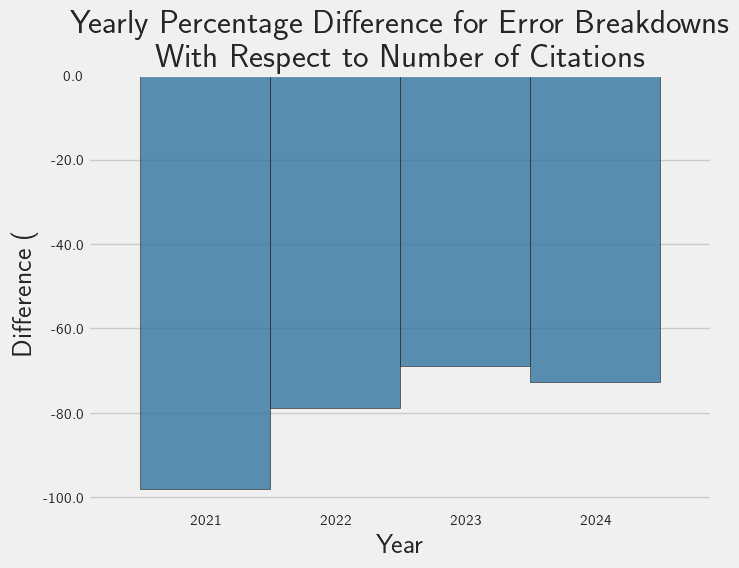

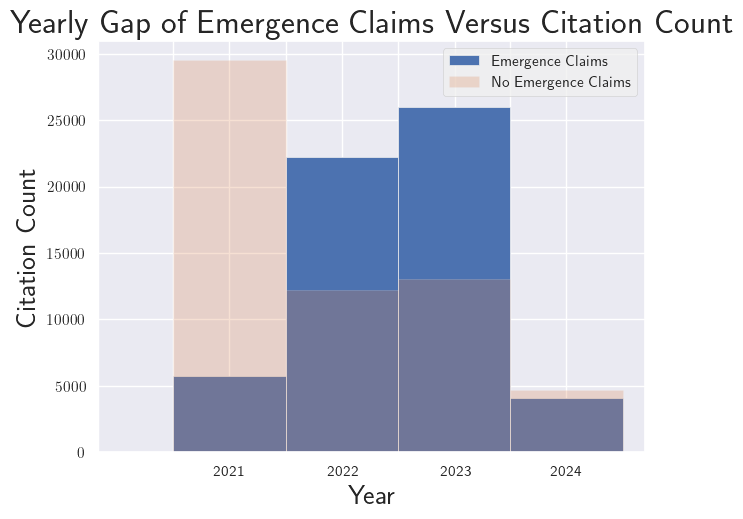

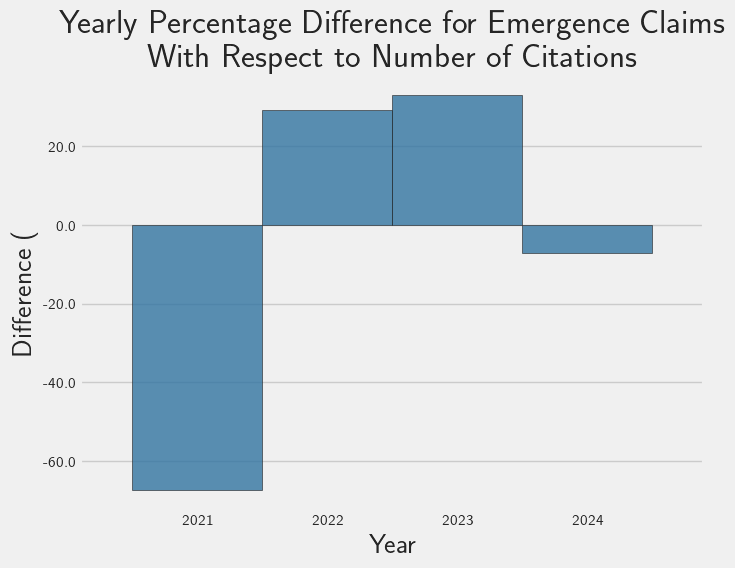

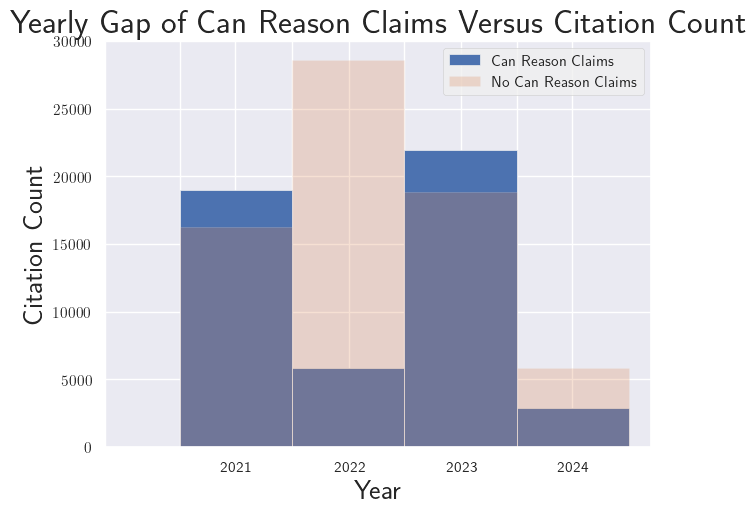

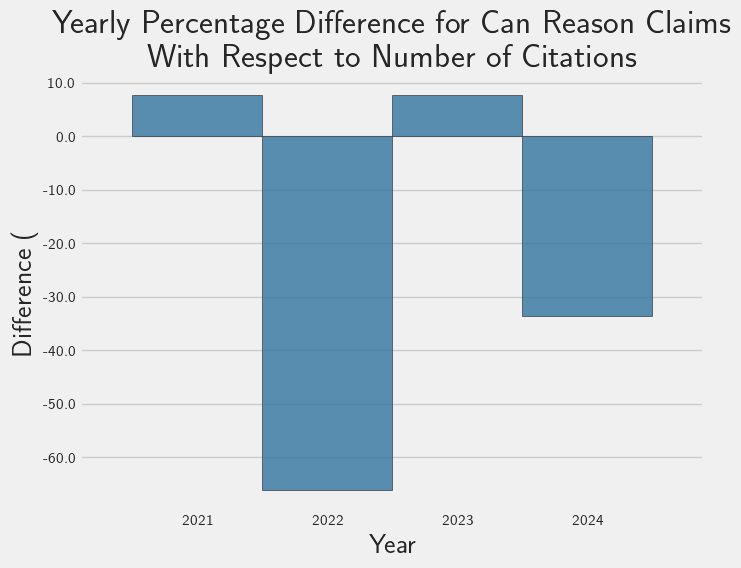

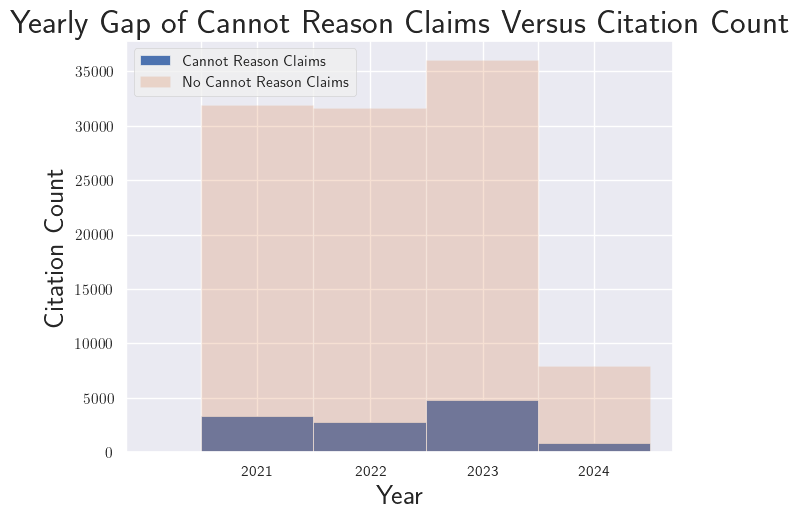

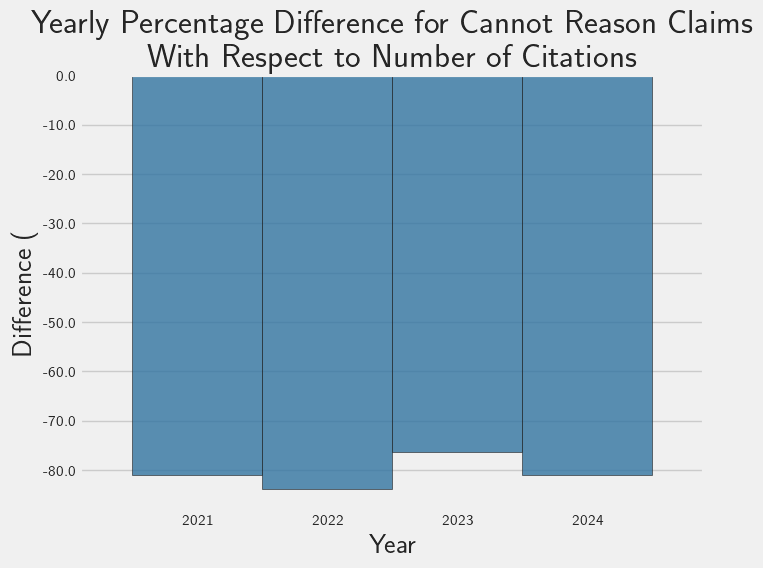

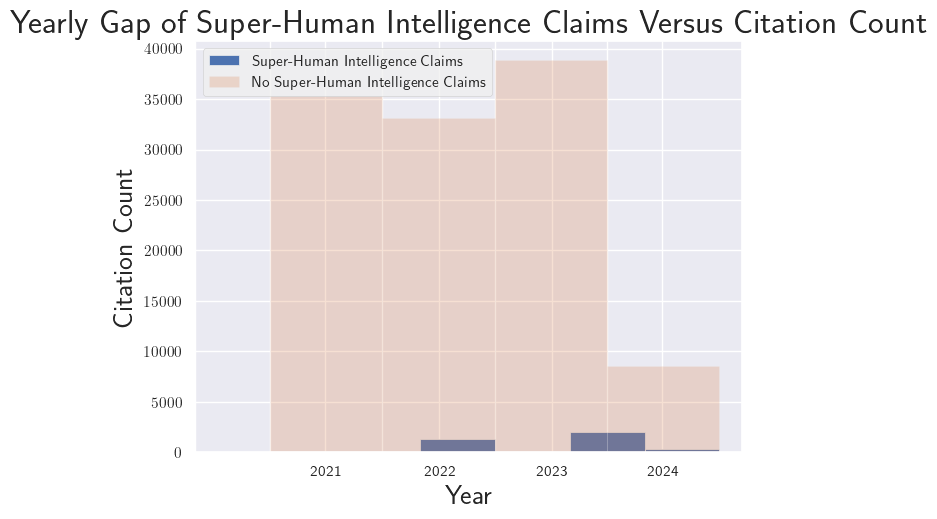

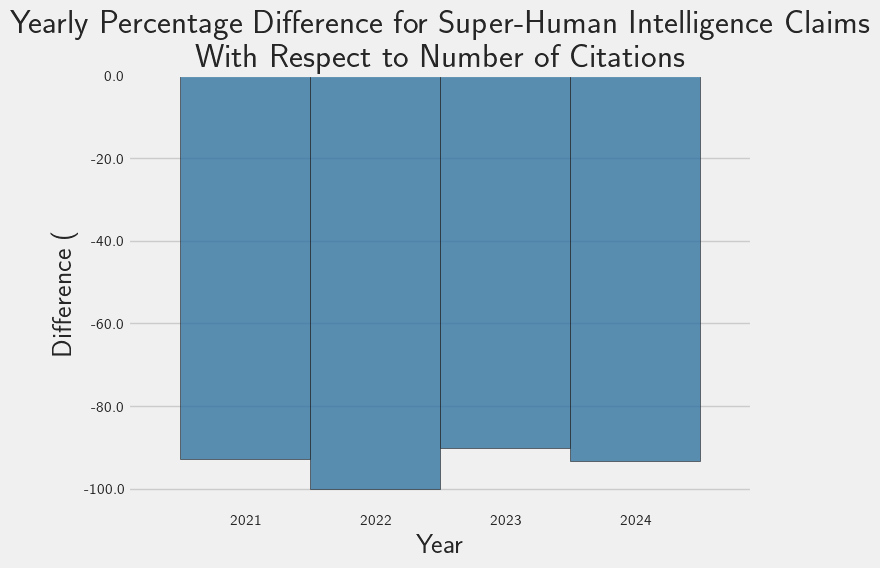

In [23]:
def tf(feature, yearly_diffs, end=False):
    tab = f"{feature} & "
    for f in yearly_diffs:
        _f = str(round(f*100))
        if _f[0] == "-":
            tab += " \\cellcolor{blue!10}"
        tab += f" {_f} & "
    tab = tab[:-2] + " "
    tab += "\\\\"
    if end:
        tab += "\\hline"
    tab += "\n"
    return tab

table = "Criterion & 2022-23 & 2022-23 & 2022-23 \\\\ \\hline\n"

#-- research
t, _, h = plot_difference_over_year("stat_sig", "Statistical Tests")
table += tf(t, h)
t, _, h = plot_difference_over_year("versions", "Declaration of Versions")
table += tf(t, h)
t, _, h = plot_difference_over_year("parameters", "Declaration of Parameters")
table += tf(t, h)
t, _, h = plot_difference_over_year("randomness", "Account for Randomness")
table += tf(t, h)
t, _, h = plot_difference_over_year("nonenglish", "Evaluation of Non-English Languages")
table += tf(t, h)
t, _, h = plot_difference_over_year("dialects", "Dialect Evaluations")
table += tf(t, h)
t, _, h = plot_difference_over_year("llm-metric", "LLMs Evaluators")
table += tf(t, h)
t, _, h = plot_difference_over_year("human-metric", "Humans Evaluators")
table += tf(t, h)
t, _, h = plot_difference_over_year("automatic-metric", "Automatic Evaluators")
table += tf(t, h, end=True)
# ---- structural
t, _, h = plot_difference_over_year("limitations", "Limitations Sections")
table += tf(t, h)
t, _, h = plot_difference_over_year("ethics", "Ethics Sections")
table += tf(t, h)
t, _, h = plot_difference_over_year("negative", "Negative Results")
table += tf(t, h)
t, _, h = plot_difference_over_year("errors", "Error Breakdowns")
table += tf(t, h, end=True)
# ---- arguments
t, _, h = plot_difference_over_year("emergence", "Emergence Claims")
table += tf(t, h)
t, _, h = plot_difference_over_year("can reason", "Can Reason Claims")
table += tf(t, h)
t, _, h = plot_difference_over_year("cannot reason", "Cannot Reason Claims")
table += tf(t, h)
t, _, h = plot_difference_over_year("superhuman", "Super-Human Intelligence Claims")
table += tf(t, h, end=True)

In [24]:
print(table)

Criterion & 2022-23 & 2022-23 & 2022-23 \\ \hline
Statistical Tests &  24 &  41 &  \cellcolor{blue!10} -44  \\
Declaration of Versions &  59 &  38 &  \cellcolor{blue!10} -29  \\
Declaration of Parameters &  52 &  32 &  \cellcolor{blue!10} -27  \\
Account for Randomness &  16 &  4 &  17  \\
Evaluation of Non-English Languages &  17 &  25 &  \cellcolor{blue!10} -40  \\
Dialect Evaluations &  \cellcolor{blue!10} -1 &  10 &  \cellcolor{blue!10} -10  \\
LLMs Evaluators &  2 &  12 &  29  \\
Humans Evaluators &  29 &  16 &  13  \\
Automatic Evaluators &  2 &  \cellcolor{blue!10} -37 &  31  \\\hline
Limitations Sections &  56 &  38 &  \cellcolor{blue!10} -12  \\
Ethics Sections &  56 &  10 &  \cellcolor{blue!10} -50  \\
Negative Results &  10 &  31 &  \cellcolor{blue!10} -29  \\
Error Breakdowns &  19 &  10 &  \cellcolor{blue!10} -4  \\\hline
Emergence Claims &  96 &  4 &  \cellcolor{blue!10} -40  \\
Can Reason Claims &  \cellcolor{blue!10} -74 &  74 &  \cellcolor{blue!10} -41  \\
Cannot Reaso

### Kolmogorov-Smirnov Tests

In [25]:
from scipy import stats

def ks_compute(sota_merged_df_y_, sota_merged_df_n_):
    y_distro = np.array(sota_merged_df_y_["Citations"].tolist())
    n_distro = np.array(sota_merged_df_n_["Citations"].tolist())
    np.random.seed(123)    
    n_distro_indices = np.random.choice(len(n_distro), len(y_distro))
    n_distro_indices.sort()
    n_distro = [n_distro[i] for i in n_distro_indices]
    res = stats.kstest(y_distro, n_distro)
    return res.statistic, res.pvalue, len(y_distro), len(n_distro)

def u_compute(sota_merged_df_y_, sota_merged_df_n_):
    y_distro = np.array(sota_merged_df_y_["Citations"].tolist())
    n_distro = np.array(sota_merged_df_n_["Citations"].tolist())
    np.random.seed(123)    
    n_distro_indices = np.random.choice(len(n_distro), len(y_distro))
    n_distro_indices.sort()
    n_distro = [n_distro[i] for i in n_distro_indices]
    res = stats.mannwhitneyu(y_distro, n_distro)
    return res.statistic, res.pvalue


sota_merged_df = get_by_year_df(do_sort=False)

def per_year_frequency(metric, title):

    fig, ax = plt.subplots()
    tau = 250
    
    _sota_merged_df = sota_merged_df.sort_values(by="Citations")
    _sota_merged_df = _sota_merged_df[_sota_merged_df["Citations"] < tau]
    _sota_merged_df["PaperId"] = [i for i in range(len(_sota_merged_df))] # Dummy variable
    
    if metric not in ["llm-metric", "human-metric", "automatic-metric"]:
        sota_merged_df_y = _sota_merged_df[_sota_merged_df[metric] == "y"]
        sota_merged_df_y[metric].apply(lambda x: 1 if x == "y" else 0)
    else:
        sota_merged_df_y = _sota_merged_df[_sota_merged_df[metric] == 1]
    sota_merged_df_y = sota_merged_df_y.loc[:, ["year", "Citations"]]
    if metric not in ["llm-metric", "human-metric", "automatic-metric"]:
        sota_merged_df_n = _sota_merged_df[_sota_merged_df[metric] == "n"]
        sota_merged_df_n[metric].apply(lambda x: 1 if x == "y" else 0)
    else:
        sota_merged_df_n = _sota_merged_df[_sota_merged_df[metric] == 0]
    sota_merged_df_n = sota_merged_df_n.loc[:, ["year", "Citations"]]

    
    bins = 10
    ax.hist(sota_merged_df_y["Citations"], bins=bins, label=f"{title}")
    ax.hist(sota_merged_df_n["Citations"], bins=bins, label=f"No {title}", alpha=0.25)
    fig.tight_layout()

    ks, pval, m, n = ks_compute(sota_merged_df_y, sota_merged_df_n)
    D = (-np.log(0.05/2)*(1 + (m/n))/(2*m) )**0.5
    #print(len(sota_merged_df_y["Citations"]), len(sota_merged_df_n["Citations"]), D)
    #utest, upval = u_compute(sota_merged_df_y, sota_merged_df_n)

    # The two below are equivalent
    rej = "Reject" if pval < 0.05 else "Fail to Reject"
    rej = "Reject" if ks > D else "Fail to Reject"
    
    plt.tight_layout()
    plt.title(f"Presence of {title} over Citations", fontsize=24, y=1.1)
    suptitle = f"{round(D, 3)} $|$ D = {round(ks, 3)} : {rej} "
    plt.suptitle("$D_{m, n}$=" + suptitle + "$H_{0}$", y=1.03)
    print(title, "$D_{m, n}$=" + suptitle + "$H_{0}$")
    plt.ylabel("Metric Count", fontsize=20)
    plt.xlabel("Citations", fontsize=20)
    plt.legend()
    plt.show()
    return (title, D, ks, pval, rej)


Statistical Tests $D_{m, n}$=0.117 $|$ D = 0.103 : Fail to Reject $H_{0}$


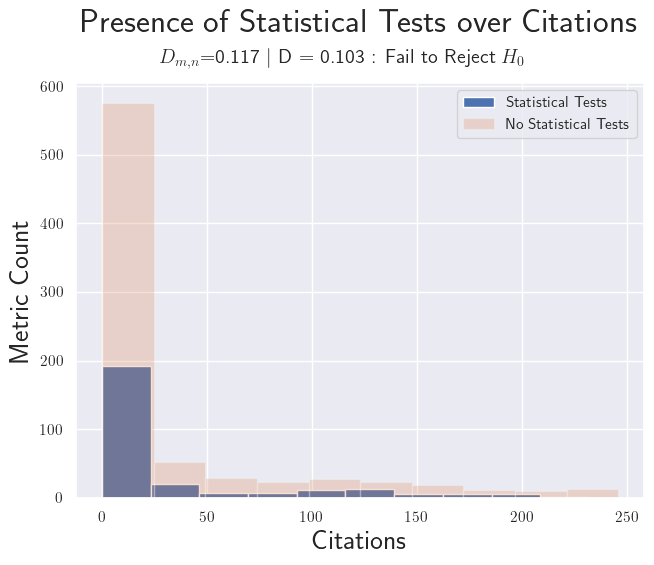

Declaration of Versions $D_{m, n}$=0.075 $|$ D = 0.077 : Reject $H_{0}$


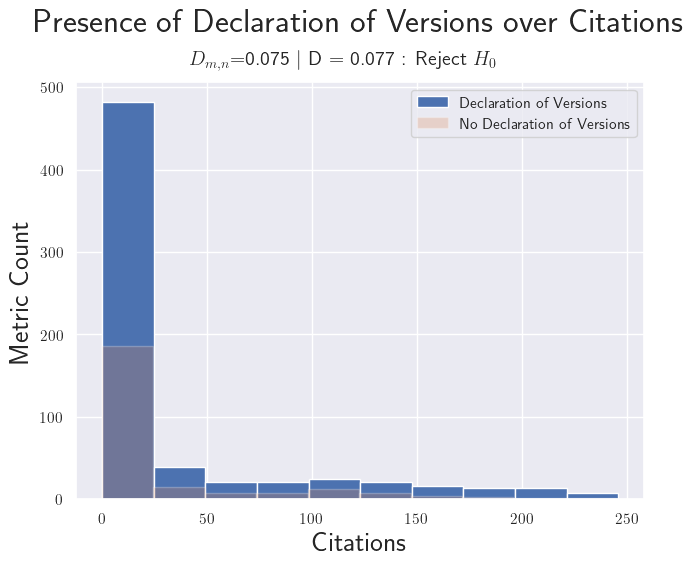

Declaration of Parameters $D_{m, n}$=0.082 $|$ D = 0.066 : Fail to Reject $H_{0}$


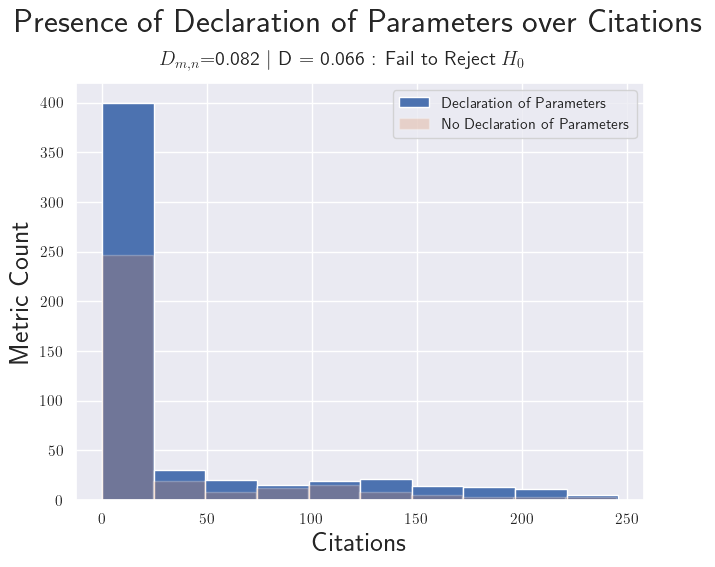

Account for Randomness $D_{m, n}$=0.182 $|$ D = 0.162 : Fail to Reject $H_{0}$


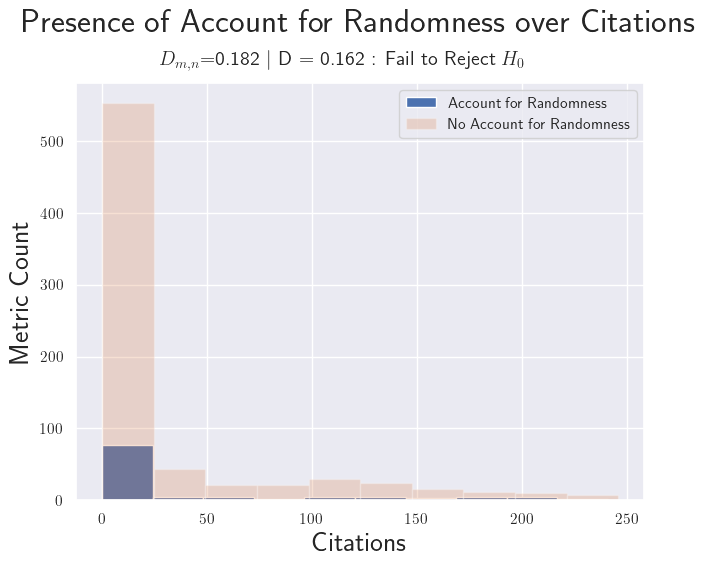

Evaluation of Non-English Languages $D_{m, n}$=0.165 $|$ D = 0.111 : Fail to Reject $H_{0}$


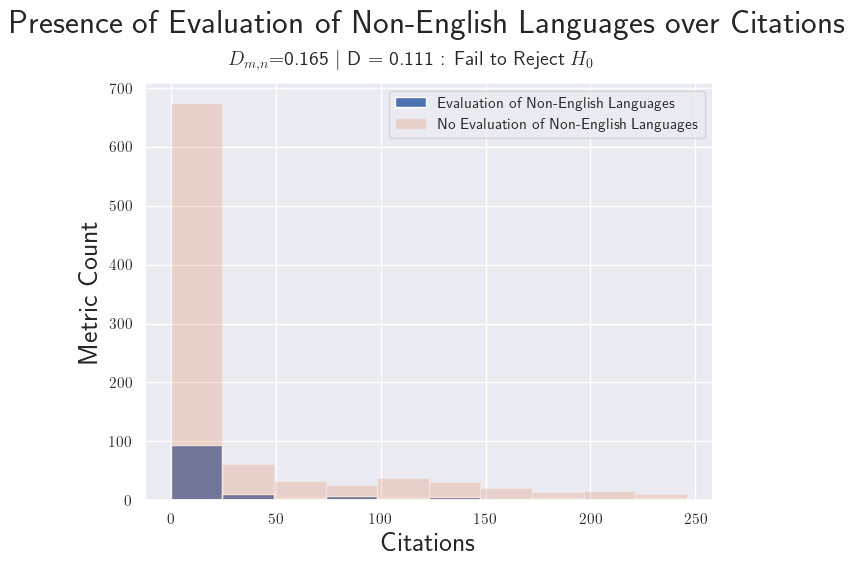

Dialect Evaluations $D_{m, n}$=0.607 $|$ D = 0.5 : Fail to Reject $H_{0}$


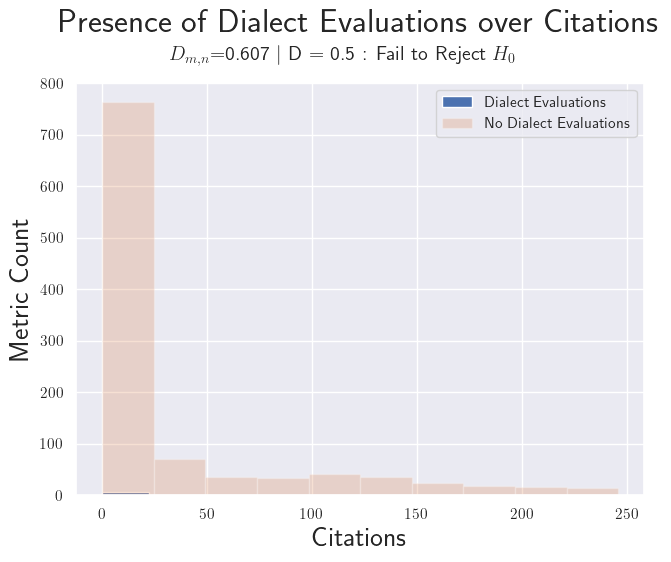

LLMs Evaluators $D_{m, n}$=0.16 $|$ D = 0.264 : Reject $H_{0}$


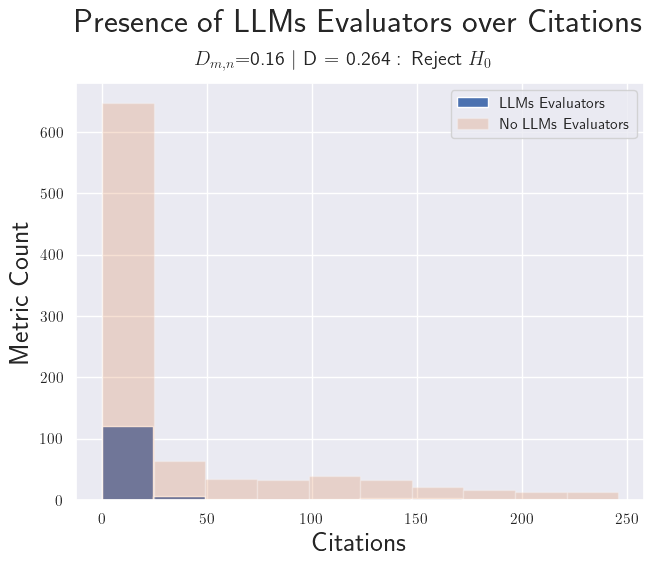

Humans Evaluators $D_{m, n}$=0.113 $|$ D = 0.052 : Fail to Reject $H_{0}$


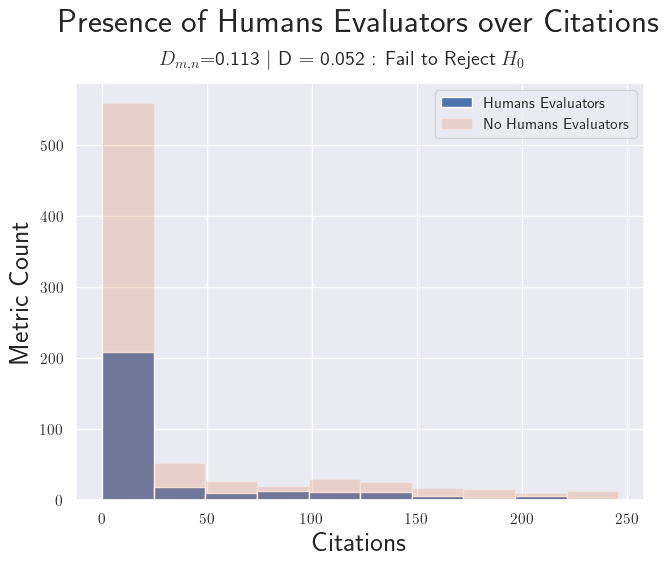

Automatic Evaluators $D_{m, n}$=0.063 $|$ D = 0.094 : Reject $H_{0}$


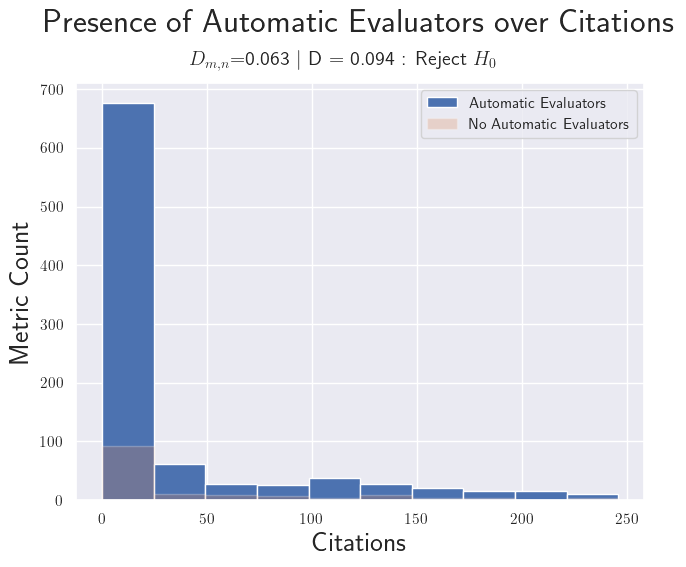

Limitations Sections $D_{m, n}$=0.076 $|$ D = 0.103 : Reject $H_{0}$


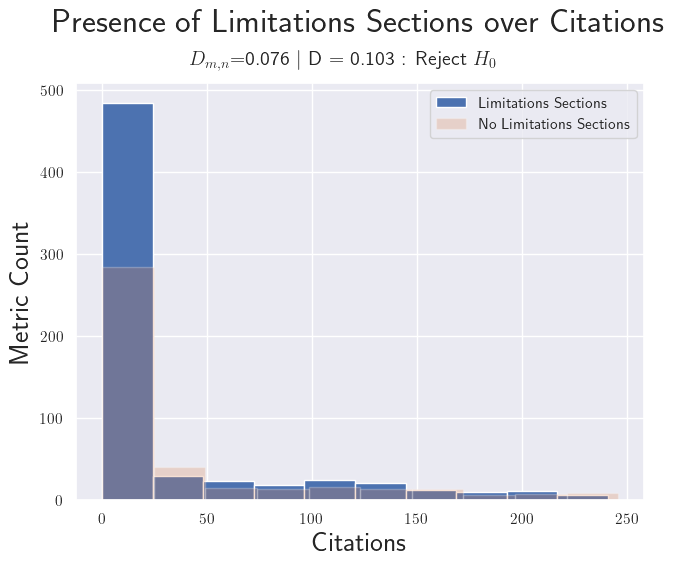

Ethics Sections $D_{m, n}$=0.108 $|$ D = 0.123 : Reject $H_{0}$


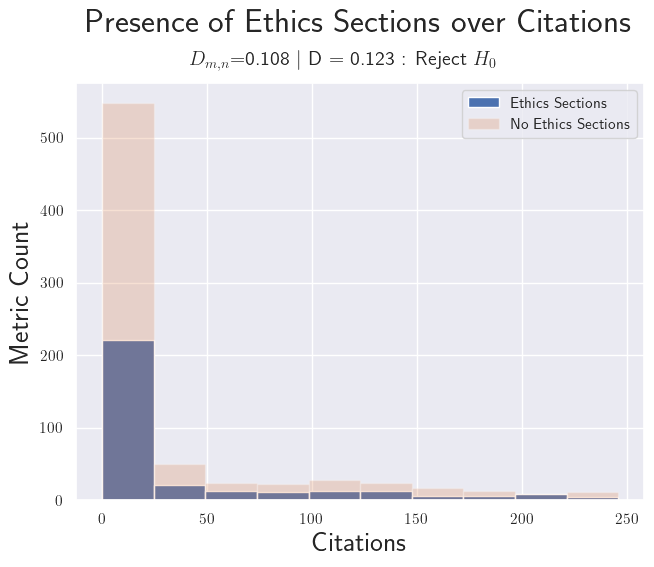

Negative Results $D_{m, n}$=0.165 $|$ D = 0.096 : Fail to Reject $H_{0}$


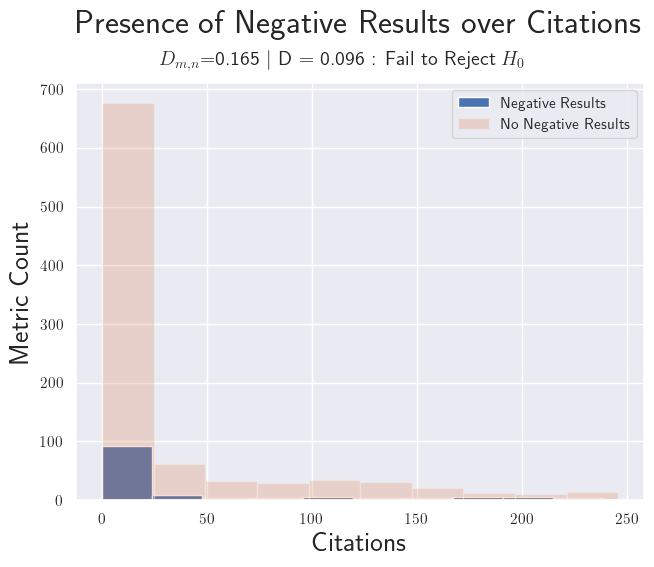

Error Breakdowns $D_{m, n}$=0.143 $|$ D = 0.083 : Fail to Reject $H_{0}$


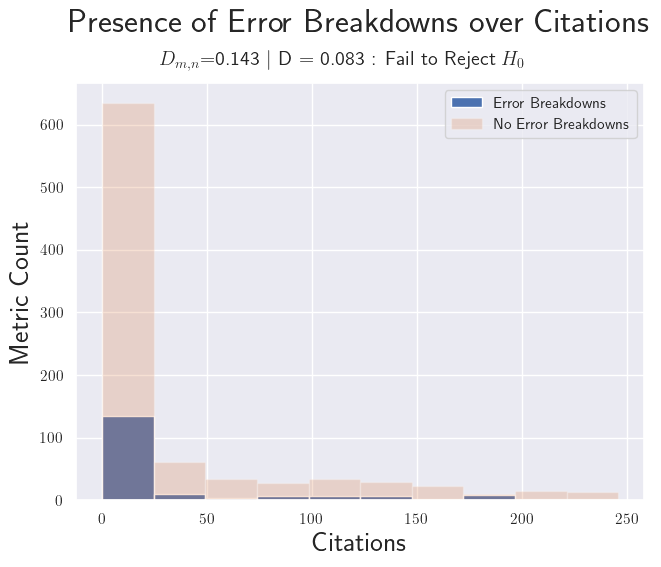

Emergence Claims $D_{m, n}$=0.097 $|$ D = 0.081 : Fail to Reject $H_{0}$


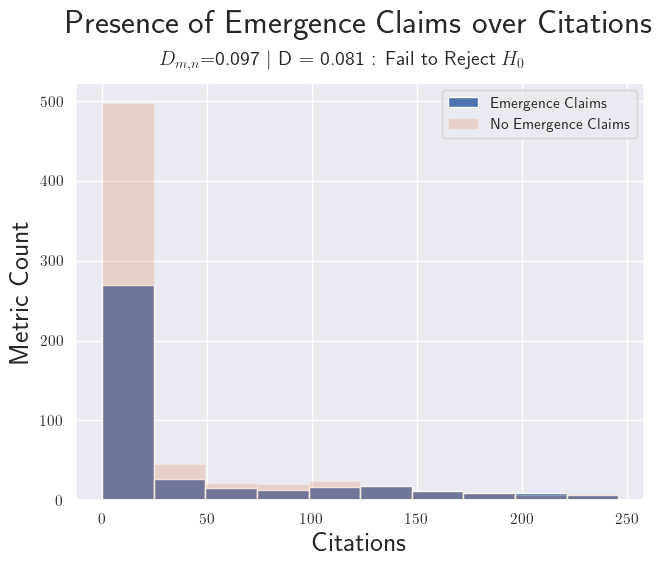

Can Reason Claims $D_{m, n}$=0.115 $|$ D = 0.147 : Reject $H_{0}$


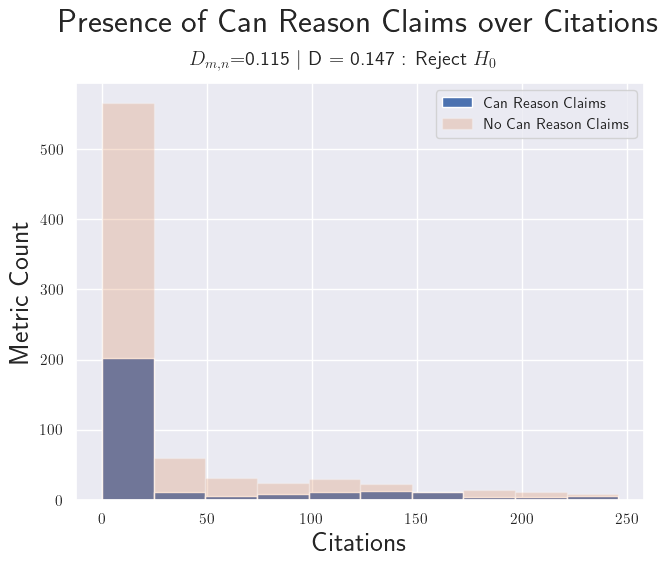

Cannot Reason Claims $D_{m, n}$=0.248 $|$ D = 0.183 : Fail to Reject $H_{0}$


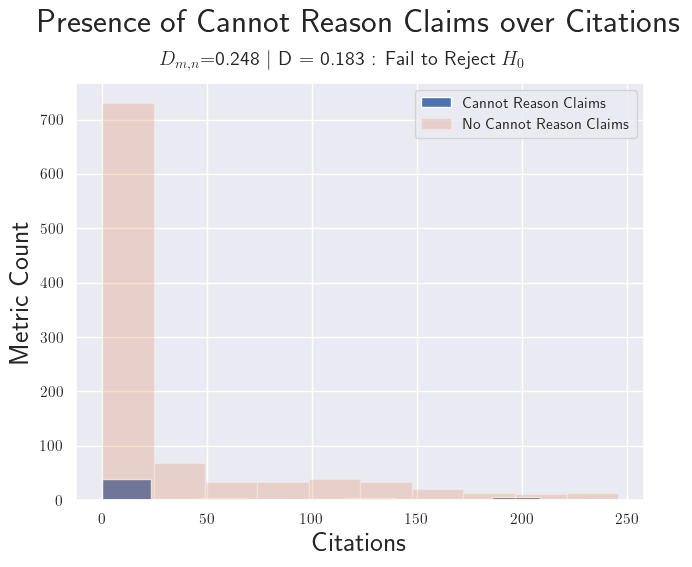

Super-Human Intelligence Claims $D_{m, n}$=0.266 $|$ D = 0.25 : Fail to Reject $H_{0}$


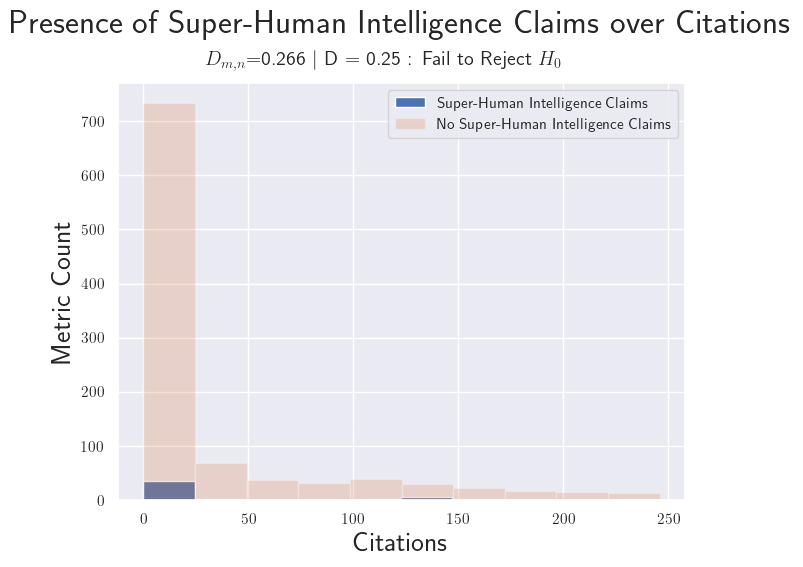

In [26]:
def tf(feature, D, ks, rej, end=False):
    tab = f"{feature} & "
    for f in [D, ks]:
        _f = str(round(f*100))
        tab += f" {_f} & "
    r = "Accept" if "Fail" in rej else "Reject"
    tab += f" {r} \\\\"
    if end:
        tab += "\\hline"
    tab += "\n"
    return tab

table = "Criterion & $D_{m,n}$ & $D$ & $H_{0}$ \\\\ \\hline\n"

#-- research
title, D, ks, pval, rej = per_year_frequency("stat_sig", "Statistical Tests")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("versions", "Declaration of Versions")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("parameters", "Declaration of Parameters")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("randomness", "Account for Randomness")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("nonenglish", "Evaluation of Non-English Languages")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("dialects", "Dialect Evaluations")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("llm-metric", "LLMs Evaluators")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("human-metric", "Humans Evaluators")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("automatic-metric", "Automatic Evaluators")
table += tf(title, D, ks, rej, end=True)
# ---- structural
title, D, ks, pval, rej = per_year_frequency("limitations", "Limitations Sections")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("ethics", "Ethics Sections")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("negative", "Negative Results")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("errors", "Error Breakdowns")
table += tf(title, D, ks, rej, end=True)
# ---- arguments
title, D, ks, pval, rej = per_year_frequency("emergence", "Emergence Claims")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("can reason", "Can Reason Claims")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("cannot reason", "Cannot Reason Claims")
table += tf(title, D, ks, rej)
title, D, ks, pval, rej = per_year_frequency("superhuman", "Super-Human Intelligence Claims")
table += tf(title, D, ks, rej, end=True)

In [27]:
print(table)

Criterion & $D_{m,n}$ & $D$ & $H_{0}$ \\ \hline
Statistical Tests &  12 &  10 &  Accept \\
Declaration of Versions &  7 &  8 &  Reject \\
Declaration of Parameters &  8 &  7 &  Accept \\
Account for Randomness &  18 &  16 &  Accept \\
Evaluation of Non-English Languages &  17 &  11 &  Accept \\
Dialect Evaluations &  61 &  50 &  Accept \\
LLMs Evaluators &  16 &  26 &  Reject \\
Humans Evaluators &  11 &  5 &  Accept \\
Automatic Evaluators &  6 &  9 &  Reject \\\hline
Limitations Sections &  8 &  10 &  Reject \\
Ethics Sections &  11 &  12 &  Reject \\
Negative Results &  17 &  10 &  Accept \\
Error Breakdowns &  14 &  8 &  Accept \\\hline
Emergence Claims &  10 &  8 &  Accept \\
Can Reason Claims &  12 &  15 &  Reject \\
Cannot Reason Claims &  25 &  18 &  Accept \\
Super-Human Intelligence Claims &  27 &  25 &  Accept \\\hline



## Yearly Trends

In [28]:
from matplotlib.ticker import PercentFormatter
import itertools
import numpy as np

def get_ols(_y):
    x = np.array([i + 1 for i in range(len(_y))])
    y = np.array(_y)
    A = np.vstack([x, np.ones(len(x))]).T
    mc, residuals, _, _ = np.linalg.lstsq(A, y)
    beta, c = mc
    r2 = 1 - residuals / (y.size * y.var())
    return beta, r2[0], c

pd.options.mode.chained_assignment = None

new_default_with_darker_neutral_5 = [
    "firebrick",
    "lightcoral",
    "silver",
    "cornflowerblue",
    "darkblue",
]

new_default_with_darker_neutral_3 = [
    "lightcoral",
    "silver",
    "cornflowerblue",
]


by_year_df = get_by_year_df()

def plot_over_year_single(metric, title, labels=["Yes", "No"]):
    fig, ax = plt.subplots(figsize=(10,6))

    ax = sns.histplot(
        data=by_year_df,
        x="year", hue=metric,
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8,
    )  #hist_kws={"alpha":1})
    fig.tight_layout()
    
    for bars in ax.containers:
        ax.bar_label(bars, labels = [f'{x.get_height():.0%}' for x in bars], label_type="center")

    plt.title(f"Presence of {title} over Years", fontsize=20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylabel("Citations")
    plt.ylabel("Percentage of Papers")
    plt.xlabel("Year")
    plt.legend(labels=labels)
    plt.show()

MARKERS = ["v", "*", "s", "x", "+", "o", "^","h", "<", ">", "1", "2", "3", "4", "8", "p"]

def plot_over_year(metrics, title, labels=["Yes", "No"], account_for_na=False, already_binary=[]):
    palette = new_default_with_darker_neutral_3 if len(metrics) == 3 else new_default_with_darker_neutral_5
    fig, ax = plt.subplots() #figsize=(10,6))
    fig.tight_layout()
    by_year_df = get_by_year_df()
    #plot = px.Figure() 
    metric_names, proportions = [], []

    with plt.style.context(['fivethirtyeight']): #['seaborn-v0_8-poster']):
        for i, (metric, mname) in enumerate(metrics):
            #_by_year_df = by_year_df[by_year_df[metric_name] == "y"]
            #_by_year_df[metric_name] = _by_year_df[metric_name].map(lambda x: 1)
            #count1 = by_year_df.loc[df[metric_name] == "y", ["year", metric_name]].value_counts(sort=True, ascending=False).reset_index()
            x = [2021, 2022, 2023, 2024] #2020, 
            df = pd.DataFrame()
            _df_by_year_df = by_year_df
            if account_for_na:
                _df_by_year_df = by_year_df[by_year_df[metric] != "na"]
            if already_binary == []:
                df[metric] = _df_by_year_df[metric].map(lambda x: 1 if x=="y" else 0)
            else:
                if i in already_binary:
                    df[metric] = _df_by_year_df[metric]
                else:
                    df[metric] = _df_by_year_df[metric].map(lambda x: 1 if x=="y" else 0)
            df["year"] = _df_by_year_df["year"]
            df = df[df["year"] > 2020]
            df = df.groupby(['year']).apply(lambda dft: pd.Series({'is_yes': dft[metric].sum(), 'total': len(dft[metric])}))
            df['proportion'] = df['is_yes']*100./df["total"]
            print("---")
            print(mname)
            print([round(_x, 2) for _x in df['proportion'].tolist()]) #, df["is_yes"])
            print([_x for _x in df["is_yes"].tolist()])
            print([_x for _x in df["total"].tolist()])
            print(f"Absolute: {round(df.iloc[-1]["proportion"] - df.iloc[1]["proportion"], 2)}% | Relative: {round((df.iloc[-1]["is_yes"] - df.iloc[1]["is_yes"])*100./df.iloc[1]["is_yes"], 2)}%")
            df = df.sort_values(by="year")
            plt.scatter(x=x, y=df["proportion"], label=mname, marker=MARKERS[i], s=70)
            plt.plot(df["proportion"], linewidth=1)
            metric_names.append(mname)
            # Do growth rate instead
            beta, r2, c = get_ols(df["proportion"].tolist())
            print([df.iloc[1]["proportion"] - df.iloc[0]["proportion"],
                                df.iloc[2]["proportion"] - df.iloc[1]["proportion"],
                                df.iloc[3]["proportion"] - df.iloc[2]["proportion"],
                                beta, r2])
            # Can't be relative. That's dumb.
            proportions.append([df.iloc[1]["proportion"] - df.iloc[0]["proportion"],
                                df.iloc[2]["proportion"] - df.iloc[1]["proportion"],
                                df.iloc[3]["proportion"] - df.iloc[2]["proportion"],
                                beta, r2])
            #proportions.append([(df.iloc[1]["is_yes"] - df.iloc[0]["is_yes"])*100./df.iloc[1]["is_yes"],
            #                    (df.iloc[2]["is_yes"] - df.iloc[1]["is_yes"])*100./df.iloc[2]["is_yes"],
            #                    (df.iloc[3]["is_yes"] - df.iloc[2]["is_yes"])*100./df.iloc[3]["is_yes"],
            #                    beta, r2])
            
        plt.title(title, fontsize=24)
        plt.xticks(x)
        plt.tight_layout()
        plt.legend()
        plt.xlabel("Year", fontsize=20)
        plt.ylabel("Yearly Proportion of Papers ($\%$)", fontsize=20)
        plt.show()
        return metric_names, proportions

---
Statistical Tests
[15.0, 27.38, 29.25, 23.93]
[12, 69, 86, 128]
[80, 252, 294, 535]
Absolute: -3.46% | Relative: 85.51%
[12.38095238095238, 1.8707482993197289, -5.326467035412296, 2.864644923389916, 0.3420160294356672]
---
Versioning
[68.52, 65.93, 74.71, 74.64]
[37, 120, 195, 365]
[54, 182, 261, 489]
Absolute: 8.71% | Relative: 204.17%
[-2.584452584452592, 8.778577744094989, -0.07051688879485596, 2.714940255663756, 0.6261280164781584]
---
Parameters declared?
[57.14, 61.76, 64.68, 62.42]
[28, 105, 163, 299]
[49, 170, 252, 479]
Absolute: 0.66% | Relative: 184.76%
[4.621848739495796, 2.9178338001867417, -2.26082778274845, 1.875439807098903, 0.5855714092444082]
---
Randomness
[4.17, 10.3, 16.87, 12.5]
[2, 17, 42, 58]
[48, 165, 249, 464]
Absolute: 2.2% | Relative: 241.18%
[6.136363636363636, 6.56443957648777, -4.367469879518072, 3.156443957648777, 0.5940992930727713]


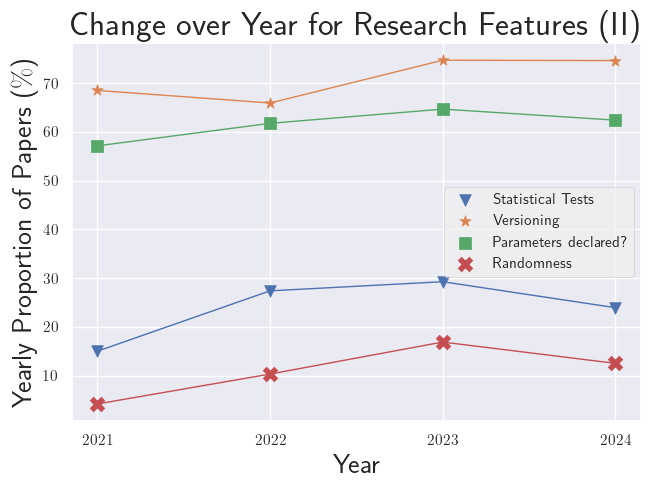

[12.38095238095238, 1.8707482993197289, -5.326467035412296, 2.864644923389916, 0.3420160294356672]
[-2.584452584452592, 8.778577744094989, -0.07051688879485596, 2.714940255663756, 0.6261280164781584]
[4.621848739495796, 2.9178338001867417, -2.26082778274845, 1.875439807098903, 0.5855714092444082]
[6.136363636363636, 6.56443957648777, -4.367469879518072, 3.156443957648777, 0.5940992930727713]
---
Non-English
[16.25, 13.1, 14.97, 11.78]
[13, 33, 44, 63]
[80, 252, 294, 535]
Absolute: -1.32% | Relative: 90.91%
[-3.154761904761905, 1.8707482993197289, -3.1902854599783836, -1.155214889694196, 0.5674062366344252]
---
Dialects
[2.5, 0.79, 1.7, 0.56]
[2, 2, 5, 3]
[80, 252, 294, 535]
Absolute: -0.23% | Relative: 50.0%
[-1.7063492063492065, 0.9070294784580498, -1.1399326085574417, -0.4910727530887746, 0.5083511877897358]
---
Open Sourcing
[83.33, 78.17, 69.72, 60.81]
[45, 154, 152, 270]
[54, 197, 218, 444]
Absolute: -17.36% | Relative: 75.32%
[-5.160744500846022, -8.447818190285474, -8.9139598313

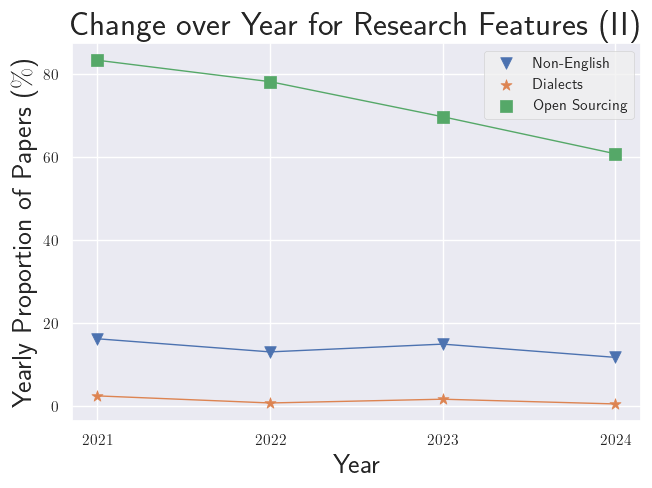

[-3.154761904761905, 1.8707482993197289, -3.1902854599783836, -1.155214889694196, 0.5674062366344252]
[-1.7063492063492065, 0.9070294784580498, -1.1399326085574417, -0.4910727530887746, 0.5083511877897358]
[-5.160744500846022, -8.447818190285474, -8.913959831391018, -7.601538575785307, 0.9866152633276246]
---
LLM
[0.0, 2.78, 7.48, 22.24]
[0, 7, 22, 119]
[80, 252, 294, 535]
Absolute: 19.47% | Relative: 1600.0%
[2.7777777777777777, 4.705215419501134, 14.759997456926694, 7.143418738211797, 0.8668331933956254]
---
Human
[26.25, 26.59, 26.53, 27.85]
[21, 67, 78, 149]
[80, 252, 294, 535]
Absolute: 1.26% | Relative: 122.39%
[0.33730158730158877, -0.05668934240362944, 1.3198550448216686, 0.4744712526755231, 0.7387342348076642]
---
Automatic
[85.0, 90.08, 78.23, 88.22]
[68, 227, 230, 472]
[80, 252, 294, 535]
Absolute: -1.86% | Relative: 107.93%
[5.0793650793650755, -11.848072562358269, 9.99300654841376, -0.21751753660966852, 0.0029054572264115563]


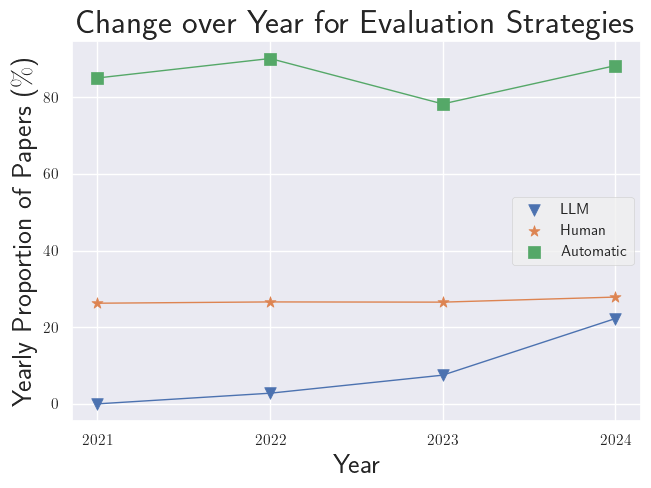

[2.7777777777777777, 4.705215419501134, 14.759997456926694, 7.143418738211797, 0.8668331933956254]
[0.33730158730158877, -0.05668934240362944, 1.3198550448216686, 0.4744712526755231, 0.7387342348076642]
[5.0793650793650755, -11.848072562358269, 9.99300654841376, -0.21751753660966852, 0.0029054572264115563]
---
Limitations Section
[40.0, 61.9, 62.93, 62.06]
[32, 156, 185, 332]
[80, 252, 294, 535]
Absolute: 0.15% | Relative: 112.82%
[21.904761904761905, 1.0204081632653086, -0.8690953016720755, 6.718863246233071, 0.6044583571984371]
---
Ethics Section
[28.75, 39.29, 29.25, 26.73]
[23, 99, 86, 143]
[80, 252, 294, 535]
Absolute: -12.56% | Relative: 44.44%
[10.535714285714285, -10.034013605442176, -2.522728717655287, -1.6097097717591735, 0.13635743397041733]
---
Negative Results
[10.0, 13.89, 14.29, 11.96]
[8, 35, 42, 64]
[80, 252, 294, 535]
Absolute: -1.93% | Relative: 82.86%
[3.8888888888888893, 0.3968253968253972, -2.3230974632843804, 0.6284675864115112, 0.16948859082295065]
---
Error Bre

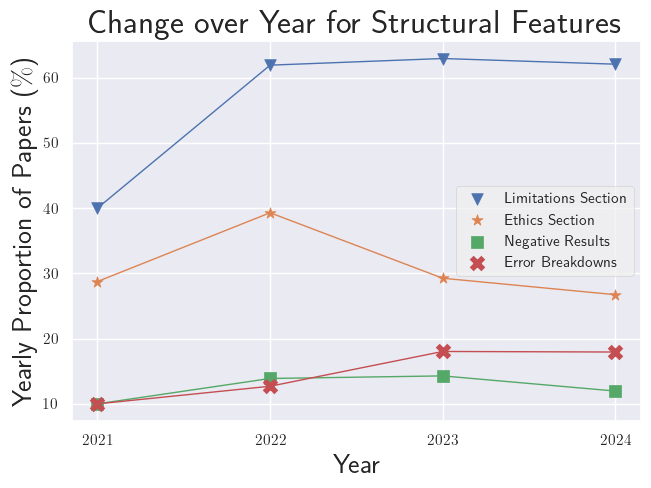

[21.904761904761905, 1.0204081632653086, -0.8690953016720755, 6.718863246233071, 0.6044583571984371]
[10.535714285714285, -10.034013605442176, -2.522728717655287, -1.6097097717591735, 0.13635743397041733]
[3.8888888888888893, 0.3968253968253972, -2.3230974632843804, 0.6284675864115112, 0.16948859082295065]
[2.6984126984126977, 5.328798185941045, -0.08328565070888416, 2.916057388687561, 0.8916121425321077]
---
Can Reason
[7.5, 16.27, 35.03, 30.84]
[6, 41, 103, 165]
[80, 252, 294, 535]
Absolute: 14.57% | Relative: 302.44%
[8.769841269841269, 18.764172335600907, -4.192892110115075, 8.878753682158223, 0.8036577906336296]
---
Cannot Reason
[5.0, 7.54, 6.8, 5.23]
[4, 19, 20, 28]
[80, 252, 294, 535]
Absolute: -2.31% | Relative: 47.37%
[2.5396825396825395, -0.7369614512471658, -1.56907622862229, -0.003602687180791965, 1.435983570519106e-05]
---
Emergence
[30.0, 40.08, 44.22, 37.2]
[24, 101, 130, 199]
[80, 252, 294, 535]
Absolute: -2.88% | Relative: 97.03%
[10.079365079365083, 4.13832199546485,

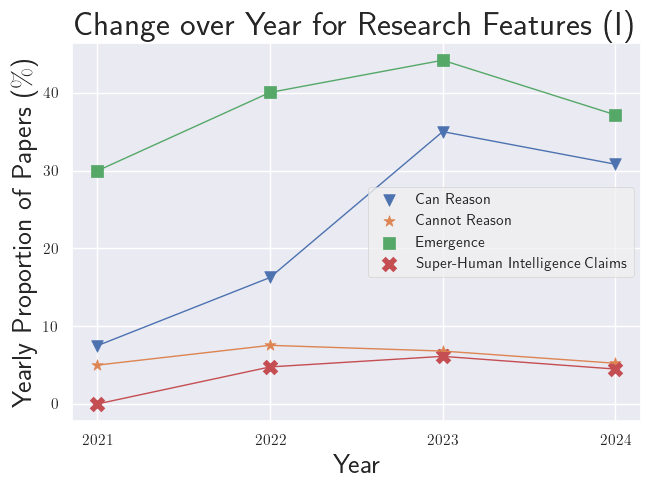

[8.769841269841269, 18.764172335600907, -4.192892110115075, 8.878753682158223, 0.8036577906336296]
[2.5396825396825395, -0.7369614512471658, -1.56907622862229, -0.003602687180791965, 1.435983570519106e-05]
[10.079365079365083, 4.13832199546485, -7.021425392586941, 2.5727107042193826, 0.3076664248969415]
[4.761904761904762, 1.3605442176870746, -1.6364676711806219, 1.4818488142920718, 0.5173499237930419]


In [29]:
def tf(feature_names, metrics, end=False):
    tab = ""
    for f, m in zip(feature_names, metrics):
        tab += f"{f} & "
        print(m)
        for j, _m in enumerate(m):
            if np.isnan(_m):
                _f = " - "
            else:
                if j == len(m) - 1:
                    _f = str(round(_m, 2))
                else:
                    _f = str(round(_m))
            if _f[0] == "-":
                tab += " \\cellcolor{blue!10}"
            tab += f" {_f} & "
        tab = tab[:-2]
        tab += f"\\\\"
        tab += "\n"
    tab = tab.strip()
    if end:
        tab += "\\hline"
    tab += "\n"
    return tab

table = "Criterion & 2021-2022 & 2022-2023 & 2023-2024 & $\\beta$ & $R^2$ \\\\ \\hline\n"

f, m = plot_over_year([("stat_sig", "Statistical Tests"), ("versions", "Versioning"), ("parameters", "Parameters declared?"),
                      ("randomness", "Randomness")], 
                      "Change over Year for Research Features (II)", account_for_na=True)
table += tf(f, m)
f, m = plot_over_year([("nonenglish", "Non-English"), ("dialects", "Dialects"), ("opensourcing", "Open Sourcing")], 
                      "Change over Year for Research Features (II)", account_for_na=True)
table += tf(f, m)
f, m = plot_over_year([("llm-metric", "LLM"), ("human-metric", "Human"), ("automatic-metric", "Automatic")],
                      "Change over Year for Evaluation Strategies", account_for_na=True, already_binary=[0, 1, 2])
table += tf(f, m, end=True)

f, m = plot_over_year([("limitations", "Limitations Section"), ("ethics", "Ethics Section"),("negative", "Negative Results"),("errors", "Error Breakdowns")],
                      "Change over Year for Structural Features")
table += tf(f, m, end=True)
f, m = plot_over_year([("can reason", "Can Reason"), ("cannot reason", "Cannot Reason"), ("emergence", "Emergence"), ("superhuman", "Super-Human Intelligence Claims")],
                      "Change over Year for Research Features (I)", account_for_na=True)
table += tf(f, m)


In [30]:
print(table)

Criterion & 2021-2022 & 2022-2023 & 2023-2024 & $\beta$ & $R^2$ \\ \hline
Statistical Tests &  12 &  2 &  \cellcolor{blue!10} -5 &  3 &  0.34 \\
Versioning &  \cellcolor{blue!10} -3 &  9 &  0 &  3 &  0.63 \\
Parameters declared? &  5 &  3 &  \cellcolor{blue!10} -2 &  2 &  0.59 \\
Randomness &  6 &  7 &  \cellcolor{blue!10} -4 &  3 &  0.59 \\
Non-English &  \cellcolor{blue!10} -3 &  2 &  \cellcolor{blue!10} -3 &  \cellcolor{blue!10} -1 &  0.57 \\
Dialects &  \cellcolor{blue!10} -2 &  1 &  \cellcolor{blue!10} -1 &  0 &  0.51 \\
Open Sourcing &  \cellcolor{blue!10} -5 &  \cellcolor{blue!10} -8 &  \cellcolor{blue!10} -9 &  \cellcolor{blue!10} -8 &  0.99 \\
LLM &  3 &  5 &  15 &  7 &  0.87 \\
Human &  0 &  0 &  1 &  0 &  0.74 \\
Automatic &  5 &  \cellcolor{blue!10} -12 &  10 &  0 &  0.0 \\\hline
Limitations Section &  22 &  1 &  \cellcolor{blue!10} -1 &  7 &  0.6 \\
Ethics Section &  11 &  \cellcolor{blue!10} -10 &  \cellcolor{blue!10} -3 &  \cellcolor{blue!10} -2 &  0.14 \\
Negative Resul

## Inflation

In [31]:
def plot_over_year_special(title):
    by_year_df = get_by_year_df()
    palette = new_default_with_darker_neutral_3
    fig, ax = plt.subplots() #figsize=(10,6))
    metric = "Citations"
    with plt.style.context(['fivethirtyeight']): #['seaborn-v0_8-poster']):
        x = [2021, 2022, 2023, 2024] #2020,
        df = by_year_df[by_year_df["year"] > 2020]
        df = df.groupby(['year']).apply(lambda dft: pd.Series({'is_yes': dft[metric].sum(),
                                                               'count': len(dft[metric])}))
        fd = by_year_df[by_year_df["year"] > 2020]
        df['proportion'] = df['is_yes']*100./fd['Citations'].sum()
        df['count_proportion'] = df['count']*100./len(fd) #fd['Citations'].sum()
        print("---")
        print(metric, df['proportion'], df["is_yes"])
        print(df.iloc[-1]["proportion"] - df.iloc[1]["proportion"], (df.iloc[-1]["is_yes"] - df.iloc[1]["is_yes"])*100./df.iloc[1]["is_yes"])
        df = df.sort_values(by="year")
        plt.scatter(x=x, y=df["proportion"], s=80, label="Citation Proportion", marker=MARKERS[0])
        plt.plot(df["proportion"], linewidth=1.0)

        plt.scatter(x=x, y=df["count_proportion"], s=80, label="Paper Volume", marker=MARKERS[1])
        plt.plot(df["count_proportion"], linewidth=1.0)

        plt.title(title, fontsize=24)
        plt.xticks(x)
        plt.tight_layout()
        plt.legend()
        plt.xlabel("Year", fontsize=20)
        plt.ylabel("Citations", fontsize=20)
        plt.show()

---
Citations year
2021    29.555891
2022    28.863751
2023    34.217362
2024     7.362996
Name: proportion, dtype: float64 year
2021    35272
2022    34446
2023    40835
2024     8787
Name: is_yes, dtype: int64
-21.500754147812973 -74.49050688033444


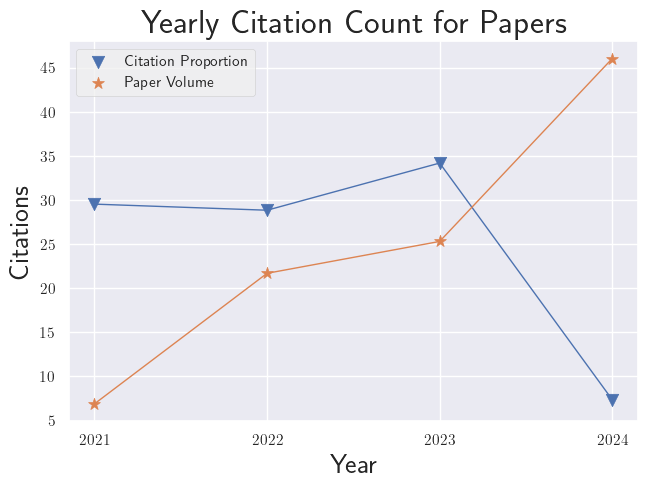

In [32]:
plot_over_year_special("Yearly Citation Count for Papers")

# Reliability Analysis

A t-Test - This doesn't run but will give you an idea of how it was done

In [ ]:
import random, json
import pandas as pd
import numpy as np

random.seed(123)

def confacc(mu, sigma, n):
    return mu, 2.145*sigma/(n - 1)**(0.5)

df_all = pd.DataFrame([json.loads(l) for l in open(filename, "r", encoding="utf-8").readlines()])

def extract_from():
    df_all = [json.loads(l) for l in open(filename, "r", encoding="utf-8").readlines()]
    all_lines_gpt3 = [l for l in df_all if l["Metadata"]["Isfrom"] == "GPT-3"]
    all_lines_gpt4 = [l for l in df_all if l["Metadata"]["Isfrom"] == "GPT-4"]
    
    df_gpt3 = pd.DataFrame(all_lines_gpt3)
    df_gpt4 = pd.DataFrame(all_lines_gpt4)
    #print(len(_all_lines))
    df_gpt3 = df_gpt3.join(pd.json_normalize(df_gpt3['Results']))
    df_gpt4 = df_gpt4.join(pd.json_normalize(df_gpt4['Results']))
    
    df_gpt3 = df_gpt3.sort_values(by="Citations")
    df_gpt4 = df_gpt4.sort_values(by="Citations")
    
    df_gpt3_llm = df_gpt3[df_gpt3["llm"] == "y"]
    df_gpt4_llm = df_gpt4[df_gpt4["llm"] == "y"]
    print(len(df_gpt3_llm) + len(df_gpt4_llm))
    df_gpt3_llm_subs = df_gpt3_llm[df_gpt3_llm["type"] == "article"]
    df_gpt4_llm_subs = df_gpt4_llm[df_gpt4_llm["type"] == "article"]
    merged_df = pd.concat([df_gpt3_llm, df_gpt4_llm])
    return merged_df


In [ ]:
df_all = extract_from()
# So you can construct an index array by sampling:
indices = random.sample(df.index, k=100)
# Here are the indices I used
indices = [214, 1096, 357, 3149, 1668, 1091, 441, 3434, 3691, 3583, 156, 1552, 2196, 2303, 1360, 1395, 3490, 212, 653, 553, 1381, 2297, 1367, 2874, 1004, 670, 6, 3710, 1786, 3168, 358, 3598, 2447, 1546, 286, 27, 1292, 2998, 1836, 417, 3708, 179, 379, 2732, 582, 517, 3236, 3713, 86, 1195, 3732, 1763, 2348, 1953, 1086, 1922, 3431, 150, 3148, 1249, 1406, 2136, 3282, 1978, 847, 3363, 2494, 2616, 2158, 2313, 3315, 1291, 51, 1631, 3657, 3150, 2646, 2100, 1779, 2805, 2205, 2614, 3262, 2730, 2443, 3645, 3414, 1991, 2132, 2738, 1718, 1534, 2089, 130, 3470, 3089, 2643, 743, 2972, 3359]

# To find specific metrics, like LLM/etc, we do a search first and then sample:
def nested_find_value(d, needle=4):
    # we assume d is always a list or dictionary
    haystack = d.values() if isinstance(d, dict) else d
    for hay in haystack:
        if isinstance(hay, (list, dict)):
            yield from nested_find_value(hay, needle)
        else:
            yield hay == needle


def find_keys(d, needle="LLM"):
    return any(nested_find_value(d, needle))

df_all = df_all[df_all["Results"].apply(find_keys)]
# Here are the sampled indices for the second part:
indices2 = [1376, 2853, 1127, 417, 2876, 896, 1488, 713, 462, 530, 1380, 348, 2473, 438, 481, 2327, 327, 1907, 355, 1131, 715, 1326, 1911, 610, 894, 959, 1565, 1036, 490, 666, 1659, 2372, 359, 776, 2078, 129, 1547, 2903, 528, 202, 2061, 608, 1944, 273, 315, 666, 486, 766, 1533, 217, 1073, 371, 2452, 2022, 488, 456, 213, 1311, 192, 785, 424, 1703, 176, 1130, 985, 1943, 890, 2469, 168, 1, 1469, 2431, 33, 2692, 69]
indices3 = [1148, 2980, 1879, 3692, 3152, 3903, 2110, 3787, 3844, 912, 3124, 3320, 3376, 3046, 3052, 3818, 3905, 2393, 2242, 3047, 3849, 3867, 3594, 2953, 2403, 152, 3178, 3708, 3902, 3437, 3118, 1552, 209, 3025, 3632, 3202, 2109, 1067, 1888, 3558, 2330, 2146, 600, 3011, 3171, 3382, 3241, 2974, 3236, 3862, 3022, 3837, 3282, 3243, 2648, 3449, 3500, 3300, 3378, 3739, 405, 3141, 3526, 3272, 3774, 3851, 3606, 3765, 3247, 3626, 3164, 3113, 3264, 807, 2526, 1796, 3554, 3650, 2410, 3792, 3813, 3351, 3133, 1560, 3209, 3132, 3663, 3451, 2530]

In [ ]:
# Then you print out the text like so (but you can't):
print(df_all.iloc[912]["Text"])

In [ ]:
results = pd.read_excel("Book1.xlsx") # Manual labels are here -- won't be released because it includes paper titles
results = results.fillna(np.nan)

def remap(k):
    if type(k) != list:
        if k == "y":
            return 1
        if k == "n":
            return 0
        if k == "na":
            return -1
    if type(k) == str:
        if "," in k:
            return [i.strip() for i in k.split(",") if i.strip() != ""]
    return k

accuracies = {k: [] for (k, v) in df_all.iloc[indices[0]].Results.items() if "_reason" not in k}
METRICS = ["human", "na", "LLM", "automatic"]
for m in METRICS:
    accuracies[m] = []

cutoff = 0

j = 0
for i in indices:
    #if  np.isnan(results.iloc[j]["SOTA"]):
    #    print(i, df_all.iloc[i]["Metadata"]["Title"])
    #    continue
    #if j > cutoff:
    #    print("\n")
    #    print(i, df_all.iloc[i]["Metadata"]["Title"])

    for k, v in df_all.iloc[i].Results.items():
        if "_reason" in k:
            continue
        if type(results.iloc[j][k]) != str and np.isnan(results.iloc[j][k]):
            continue
        if k == "metrics":
            continue
        else:
            accuracies[k].append(remap(v) == remap(results.iloc[j][k]))
            #if remap(v) != remap(results.iloc[j][k]):
            #    if j > cutoff:
            #        print(k, df_all.iloc[i]["Results"][k], df_all.iloc[i]["Results"][k + "_reason"])

    for ix, m in enumerate(df_all.iloc[i]["Results"]["metrics"]):
        if m == "na" and len(df_all.iloc[i]["Results"]["metrics"]) > 1:
            continue
        label = 0
        if m in [l.strip() for l in results.iloc[j]["metrics"].split(",")]:
            label = 1
        #else:
        #    if j > cutoff:
        #        print(m, df_all.iloc[i]["Results"]["metrics_reason"][f"metric{ix}"])
        accuracies[m].append(label)
    j += 1

avg = []
for k, v in accuracies.items():
    _v = np.array(v)
    if k != "metrics":
        avg += v
        x, w = confacc(_v.mean(), _v.std(), len(v))
        print(f"{k}: {round(x*100, 2)} +/- {round(w*100, 2)} | {len(_v)}")

k = "Total" 
_avg = np.array(avg)
x, w = confacc(_avg.mean(), _avg.std(), len(_avg))
print(f"{k}: {round(x*100, 2)} +/- {round(w*100, 2)}")

_accuracies = {k:v for k,v in accuracies.items()}

In [ ]:
results2 = pd.read_excel("Book2.xlsx", sheet_name="Sheet1") # Manual labels are here -- won't be released because it includes paper titles
results2 = results2.fillna(np.nan)

METRICS = ["human", "na", "LLM", "automatic"]
accuracies = {k:v for k,v in _accuracies.items()}

cutoff = 0
j = 0
for i in indices2 + indices3:
    #print(j, "df", df_all.iloc[i]["Metadata"]["Title"], "res", [l.strip() for l in results2.iloc[j]["Title"].split(",")])    
    flag = ""
    for ix, m in enumerate(df_all.iloc[i]["Results"]["metrics"]):
        if m == "na" and len(df_all.iloc[i]["Results"]["metrics"]) > 1:
            continue
        label = 0
        if m in [l.strip() for l in results2.iloc[j]["metrics"].split(",")]:
            label = 1
        else:
            if f"metric{ix}" in df_all.iloc[i]["Results"]["metrics_reason"]:
                flag += f'{m}: {df_all.iloc[i]["Results"]["metrics_reason"][f"metric{ix}"]}\n'
            else:
                flag += f'{m}: ?'
        accuracies[m].append(label)
    #if flag != "" and j > cutoff:
    #    print(i, df_all.iloc[i]["Metadata"]["Title"])
    #    print(j, "df", df_all.iloc[i]["Results"]["metrics"], "res", [l.strip() for l in results2.iloc[j]["metrics"].split(",")])
    #    print(flag)
    #    print("")
    j += 1

for k, v in accuracies.items():
    if k == "metrics":
        continue
    if k in METRICS:
        avg += v
    _v = np.array(v)
    x, w = confacc(_v.mean(), _v.std(), len(v))
    print(f"{k}: {round(x*100, 2)} +/- {round(w*100, 2)} | {len(_v)}")


k = "Total" 
_avg = np.array(avg)
x, w = confacc(_avg.mean(), _avg.std(), len(_avg))
print(f"{k}: {round(x*100, 2)} +/- {round(w*100, 2)}")